In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, least_squares, curve_fit
from scipy.stats import poisson, chi2, f, mode
import inspect
import re

In [2]:
# In file where $ENER_FIT: is listed, first value is b, second is m

def get_ener_at_bin(bin_num, m, b):
    return m*bin_num + b

def calc_ener_err(calib_val, calib_val_err, pcov, popt, par_num,sep = False):
    # sigma_E^2 = m^2*(sigma_mu)^2 + mu^2*(sigma_m)^2 + (sigma_b)^2
    # so i investigated each term separately. and the statistical error is overall really smalle. the systematic error from calibration depends
    # it is much larger on the intercept term than the slope, and if i remove the intercept term it gets much smaller and more reasonable

    # just statistical error from calibration
    # return np.sqrt( (popt[par_num]**2)*(calib_val_err[0]**2) + calib_val_err[1]**2)  

    # just systematic error from calibration
    # return np.sqrt( (popt[par_num]**2)*(calib_val_err[0]**2) + calib_val_err[1]**2)
    
    # if sep:
        # returns statistical error and systematic error (from calibration) separately
        # return np.sqrt( (calib_val[0]**2)*(pcov[par_num][par_num])),  np.sqrt((popt[par_num]**2)*(calib_val_err[0]**2) + calib_val_err[1]**2)
    return np.sqrt( (calib_val[0]**2)*(pcov[par_num][par_num])  + (popt[par_num]**2)*(calib_val_err[0]**2) + calib_val_err[1]**2 + 2*calib_val[0]*calib_val_err[2])


In [3]:
R = 3.2898419602500e15 # rydberg frequency in Hz
h = 4.135667696e-15 # planck's constant in eV s
alpha = 1/137.035999084 # fine structure constant

# Fitters

In [4]:
def gaussian(x, A, mu, sigma):
    return A * np.exp(-0.5 * ((x - mu)/sigma)**2)

def linear(x,m,b):
    return m*x + b

def gaussian_plus_linear(x,A,mu,sigma,m,b):
    return A * np.exp(-0.5 * ((x - mu)/sigma)**2) + m*x + b

def gaussian_plus_constant(x,A,mu,sigma,c):
    return A * np.exp(-0.5 * ((x - mu)/sigma)**2) + c

def two_gaussians(x,A1,mu1,sigma1,A2,mu2,sigma2):
    return A1 * np.exp(-0.5 * ((x - mu1)/sigma1)**2) + A2 * np.exp(-0.5 * ((x - mu2)/sigma2)**2)

def two_gaussians_plus_linear(x,A1,mu1,sigma1,A2,mu2,sigma2,m,b):
    return A1 * np.exp(-0.5 * ((x - mu1)/sigma1)**2) + A2 * np.exp(-0.5 * ((x - mu2)/sigma2)**2) + m*x + b

def gaussian_plus_power_law(x,A1,mu,sigma,A2,alpha,b,ox,oy):
    return A1 * np.exp(-0.5 * ((x - mu)/sigma)**2) + A2*alpha**((x-ox)*b) + oy

def gaussian_plus_quadratic(x,A,mu,sigma,a,b,c,o):
    return A * np.exp(-0.5 * ((x - mu)/sigma)**2) + a*(x+o)**2 + b*(x+o) + c    


In [5]:
# Helper to "latexify" a parameter name
def latexify(name):
    # Common mappings for Greek letters, case-sensitive
    greek_map = {
        'mu': r'$\mu$',
        'sigma': r'$\sigma$',
        'theta': r'$\theta$',
        'phi': r'$\phi$',
        'lambda': r'$\lambda$',
        'tau': r'$\tau$',
        'omega': r'$\omega$',
        'alpha': r'$\alpha$',
        'beta': r'$\beta$',
        'gamma': r'$\gamma$',
        'delta': r'$\delta$',
        'A': r'$A$',
        'B': r'$B$',
        'C': r'$C$'
    }
    # If it's a known Greek or uppercase symbol, use the map
    if name in greek_map:
        return greek_map[name]
    # Otherwise, make it subscript-friendly: e.g. "x1" -> "$x_1$"
    match = re.match(r"([a-zA-Z]+)(\d+)", name)
    if match:
        return f"${match.group(1)}_{{{match.group(2)}}}$"
    # Default: wrap in math mode
    return f"${name}$"

def generate_text_string(fit_func, popt, pcov, chi2_value, reduced_chi2, p_val, precision=2):
    param_names = list(inspect.signature(fit_func).parameters.keys())[1:]

    # Build text dynamically
    param_text_parts = []
    for i, name in enumerate(param_names):
        value = popt[i]
        uncertainty = pcov[i, i]**0.5 if pcov[i, i] >= 0 else float('nan')
        fmt = f"{{:.{precision}f}}"  # dynamic precision format
        param_text_parts.append(f"{latexify(name)} = {fmt.format(value)} ± {fmt.format(uncertainty)}")

    param_text = ", ".join(param_text_parts)

    # Construct full annotation text
    fmt = f"{{:.{precision}f}}"
    text_display_string_info = (
        f"$\\chi^2$ = {fmt.format(chi2_value)}\n"
        f"Reduced $\\chi^2$ = {fmt.format(reduced_chi2)}\n"
        f"p-value = {fmt.format(p_val)}\n"
        f"Best-fit values: {param_text}"
    )

    return text_display_string_info

In [6]:
def fit_peak_with_residuals(
    data, 
    range_beg, 
    range_end, 
    fit_func, 
    initial_guess, 
    xlabel="Bin Number", 
    ylabel="Counts", 
    title=None,
    annotate_fit=True,
    display_plot = False,
    precision=2
):
    # Prepare histogram data
    data_for_hist = []
    for bin_num, counts in enumerate(data):
        if range_beg <= bin_num <= range_end:
            try:
                for _ in range(int(counts)):
                    data_for_hist.append(bin_num)
            except Exception:
                break

    bins = np.arange(range_beg - 0.5, range_end + 1.5, 1)
    hist_counts, bin_edges = np.histogram(data_for_hist, bins=bins)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    hist_uncertainties = np.sqrt(hist_counts)
    had_to_fix_div_by_zero = False
    for i in range(len(hist_uncertainties)):
        if hist_uncertainties[i] == 0:
            hist_uncertainties[i] = 1
            had_to_fix_div_by_zero = True

    # Fit
    popt, pcov = curve_fit(
        fit_func, bin_centers, hist_counts, initial_guess, 
        sigma=hist_uncertainties, absolute_sigma=True
    )
    if had_to_fix_div_by_zero:
        popt, pcov = curve_fit(
            fit_func, bin_centers, hist_counts, popt, 
            sigma=[popt[1]**0.5]*len(hist_counts), absolute_sigma=True
        )

    # Chi2
    chi2_value = np.sum(((fit_func(bin_centers, *popt) - hist_counts) / hist_uncertainties) ** 2)
    dof = len(hist_counts) - len(popt)
    reduced_chi2 = chi2_value / dof
    chi2_prob = chi2.cdf(chi2_value, dof)
    p_val = 1 - chi2_prob

    # Residuals
    residuals = hist_counts - fit_func(bin_centers, *popt)
    pulls = residuals / hist_uncertainties

    # Plot
    if display_plot:
        fig, (ax, ax_res) = plt.subplots(2, 1, figsize=(8, 8), sharex=True, 
                                        gridspec_kw={'height_ratios': [3, 1]})
        ax.errorbar(bin_centers, hist_counts, yerr=hist_uncertainties, fmt='o', capsize=3, alpha=0.7)
        overplot_x = np.linspace(range_beg-0.5, range_end+0.5, num=200)
        overplot_y = fit_func(overplot_x, *popt)
        ax.plot(overplot_x, overplot_y, 'r--', label='Fit')
        ax.hist(data_for_hist,bins=bins,histtype = 'step', color='black')
        ax.set_ylabel(ylabel, fontsize=14)
        if title:
            ax.set_title(title)
        if annotate_fit:
            from inspect import signature
            param_names = list(signature(fit_func).parameters.keys())[1:]
            param_text = "\n".join(
                f"{name} = {popt[i]:.{precision}f} ± {np.sqrt(pcov[i,i]):.{precision}f}" 
                for i, name in enumerate(param_names)
            )
            fit_text = (
                f"χ² = {chi2_value:.{precision}f}\n"
                f"Reduced χ² = {reduced_chi2:.{precision}f}\n"
                f"p-value = {p_val:.3f}\n"
                f"{param_text}"
            )
            fig.text(0.2, 0.8, fit_text, ha='left', va='top', fontsize=12,
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7))

        # Residuals
        ax_res.errorbar(bin_centers, pulls, yerr=1, fmt='o', capsize=3)
        ax_res.axhline(0, color='k', linestyle='--', linewidth=1)
        ax_res.set_xlabel(xlabel, fontsize=14)
        ax_res.set_ylabel("Pull", fontsize=12)
        ax_res.set_ylim(-4, 4)
        plt.tight_layout()
        plt.show()

    # Return fit results
    return {
        "popt": popt,
        "pcov": pcov,
        "chi2_value": chi2_value,
        "reduced_chi2": reduced_chi2,
        "p_val": p_val,
        "bin_centers": bin_centers,
        "hist_counts": hist_counts,
        "hist_uncertainties": hist_uncertainties,
        "residuals": residuals,
        "pulls": pulls
    }

def generate_candidate_ranges(bin1, bin2, bound=10, step_size=3):
    """
    Generate all (start, end) pairs where start is within 'bound' of bin1,
    end is within 'bound' of bin2, and start < end.
    """
    starts = range(bin1 - bound, bin1 + bound + 1, step_size)
    ends = range(bin2 - bound, bin2 + bound + 1, step_size)
    return [(s, e) for s in starts for e in ends if s < e]

In [7]:
moseleys_lines = {}

# 10-06 pair annihilation analysis

In [8]:
# # Commented cell for Isa for generally curve fitting to calibration spectra
# # Loading the data
# na1 = "10_06\\sodium_calibration_spectra_10_06.Spe"
# na1_calib = {}
# data = np.genfromtxt(na1, delimiter='\n', skip_header=12)

# # Plotting the entire spectrum
# plt.bar(range(2048),data[:2048], color = '#1E88E5')

# # Selecting range of bins that the relevant peak is in
# range_beg = 690
# range_end = 705

# data_for_hist = []
# for bin_num,counts in enumerate(data):
#     if bin_num >= range_beg and bin_num <= range_end:
#         try:
#             for _ in range(int(counts)):
#                 data_for_hist.append(bin_num)
#         except:
#             break


# fig, ax = plt.subplots(figsize=(8,6))

# bins = np.arange(range_beg - 0.5, range_end + 1.5, 1)
# hist_counts,bin_edges = ax.hist(data_for_hist,bins=bins)[:2] 

# bin_centers = ((bin_edges[:-1] + bin_edges[1:]) / 2)
# hist_uncertainties = [x**(0.5) for x in hist_counts]
# ax.hist(data_for_hist,bins=bins,histtype = 'step', color='black')

# # Choosing a function to fit for the peak and a guess
# initial_guess = [hist_counts.max(),mode(data_for_hist)[0],20, 0,0]
# fit_func = gaussian_plus_linear

# popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,initial_guess,sigma=hist_uncertainties, absolute_sigma=True)

# # Calculating chi2
# chi2_value = 0
# for index,bin_center in enumerate(bin_centers):
#     chi2_value += (fit_func(bin_center, *popt) - hist_counts[index])**2/hist_uncertainties[index]**2
# dof = len(hist_counts) - len(popt)
# reduced_chi2 = chi2_value/dof
# chi2_prob = chi2.cdf(chi2_value, dof)
# p_val = 1 - chi2_prob

# # Plotting the fit result on top of the histogram as a dashed line
# overplot_x = np.linspace(range_beg-0.5, range_end+0.5, num=200)
# overplot_y = fit_func(overplot_x, *popt)
# ax.plot(overplot_x, overplot_y, linestyle='--')

# # Annotating with fit results
# fig.text(
#     0.2, 0.8,  # position relative to the figure, not just the axis
#     generate_text_string(fit_func,popt,pcov,chi2_value,reduced_chi2,p_val),
#     ha='left', va='top',
#     fontsize=12,
#     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
# )
# ax.set_xlabel("Bin Number", fontsize=14)
# ax.set_ylabel("Counts", fontsize=14)

# # Saving calibration results, to eventually get a linear relationship out of for then determining the energy of unknown peaks
# na1_calib[511] = (popt[1], pcov[1][1]**0.5)

# 10-01 bremsstrahlung analysis, lead and bismuth

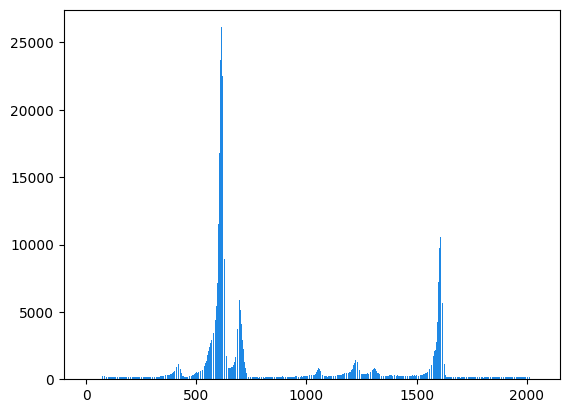

In [9]:
ba3 = "10_01\\barium_mid_gain_calibration_x_ray_spectra_10_01.Spe"
data = np.genfromtxt(ba3, delimiter='\n', skip_header=12)
plt.bar(range(2048),data[:2048], color = '#1E88E5')
brem_calib = {} # used to for Pb X-ray energy calculations

In [10]:
# # Finding optimal range for 133 Barium, 31 keV peak (single peak, assuming two gaussians (KL3 and KL2) are not resolvable)
# # Candidate fit ranges (tuples of (start, end))
# candidate_ranges = generate_candidate_ranges(595, 625,bound = 10, step_size= 2)
# # Candidate models and their initial guesses
# candidate_models = [
#     (gaussian, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10]),
#     (gaussian_plus_linear, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10, 0, 0]),
#     (gaussian_plus_constant, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10, 0])
# ]

# results = []

# for fit_range in candidate_ranges:
#     # Prepare histogram for this range
#     data_for_hist = []
#     for bin_num, counts in enumerate(data):
#         if fit_range[0] <= bin_num <= fit_range[1]:
#             try:
#                 for _ in range(int(counts)):
#                     data_for_hist.append(bin_num)
#             except Exception:
#                 break
#     bins = np.arange(fit_range[0] - 0.5, fit_range[1] + 1.5, 1)
#     hist_counts, bin_edges = np.histogram(data_for_hist, bins=bins)
#     bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

#     for model_func, guess_func in candidate_models:
#         try:
#             initial_guess = guess_func(hist_counts, bin_centers)
#             fit_result = fit_peak_with_residuals(
#                 data=data,
#                 range_beg=fit_range[0],
#                 range_end=fit_range[1],
#                 fit_func=model_func,
#                 initial_guess=initial_guess,
#                 xlabel="Bin Number",
#                 ylabel="Counts",
#                 title=f"Range {fit_range}, Model {model_func.__name__}",
#                 annotate_fit=False  # We'll annotate only the best fit
#             )
#             results.append({
#                 "range": fit_range,
#                 "model": model_func.__name__,
#                 "fit_result": fit_result
#             })
#         except Exception as e:
#             print(f"Fit failed for range {fit_range} and model {model_func.__name__}: {e}")

# # Select the best fit (lowest reduced chi²)
# best = min(results, key=lambda r: r["fit_result"]["reduced_chi2"])
# print(f"Best fit: Range {best['range']}, Model {best['model']}, Reduced chi² = {best['fit_result']['reduced_chi2']:.2f}")

# # Plot the best fit with annotation
# results = fit_peak_with_residuals(
#     data=data,
#     range_beg=best["range"][0],
#     range_end=best["range"][1],
#     fit_func=eval(best["model"]),
#     initial_guess=best["fit_result"]["popt"],
#     xlabel="Bin Number",
#     ylabel="Counts",
#     title=f"Best Fit: Range {best['range']}, Model {best['model']}",
#     annotate_fit=True,
#     display_plot = True
# )
# popt = results["popt"]

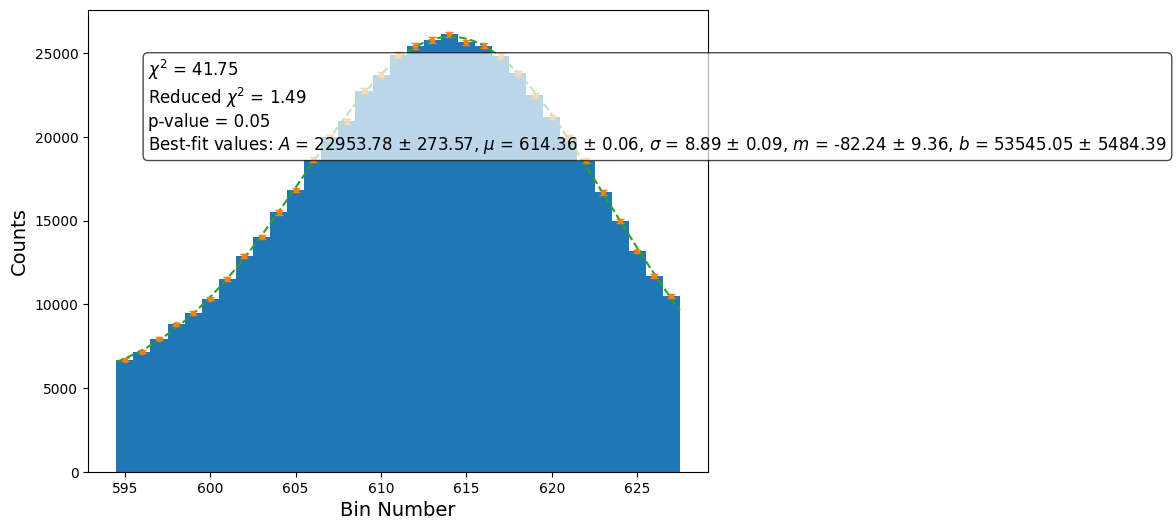

In [11]:
# Recording optimal fit for 133 Barium, 31 keV peak
range_beg = 595
range_end = 627

data_for_hist = []
for bin_num,counts in enumerate(data):
    if bin_num >= range_beg and bin_num <= range_end:
        try:
            for _ in range(int(counts)):
                data_for_hist.append(bin_num)
        except:
            break
fig, ax = plt.subplots(figsize=(8,6))

bins = np.arange(range_beg - 0.5, range_end + 1.5, 1)
hist_counts,bin_edges = ax.hist(data_for_hist,bins=bins)[:2] 

bin_centers = ((bin_edges[:-1] + bin_edges[1:]) / 2)
hist_uncertainties = [x**(0.5) for x in hist_counts]
ax.errorbar(bin_centers,hist_counts,yerr=hist_uncertainties,fmt = '.',capsize = 3)

initial_guess =[hist_counts.max(),mode(data_for_hist)[0],10,   0,0]
fit_func = gaussian_plus_linear

popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,initial_guess,sigma=hist_uncertainties, absolute_sigma=True)

chi2_value = 0
for index,bin_center in enumerate(bin_centers):
    chi2_value += (fit_func(bin_center, *popt) - hist_counts[index])**2/hist_uncertainties[index]**2
dof = len(hist_counts) - len(popt)
reduced_chi2 = chi2_value/dof
chi2_prob = chi2.cdf(chi2_value, dof)
p_val = 1 - chi2_prob

overplot_x = np.linspace(range_beg-0.5, range_end+0.5, num=200)
overplot_y = fit_func(overplot_x, *popt)

ax.plot(overplot_x, overplot_y, linestyle='--')
fig.text(
    0.2, 0.8,  # position relative to the figure, not just the axis
    generate_text_string(fit_func,popt,pcov,chi2_value,reduced_chi2,p_val),
    ha='left', va='top',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
)
ax.set_xlabel("Bin Number", fontsize=14)
ax.set_ylabel("Counts", fontsize=14)

brem_calib[30.85] = (popt[1], np.sqrt(pcov[1][1]))

In [12]:
# # Finding optimal range for 133 Barium, 35 keV peak
# # Candidate fit ranges (tuples of (start, end))
# candidate_ranges = generate_candidate_ranges(660, 730,bound = 20, step_size= 3)
# # Candidate models and their initial guesses
# candidate_models = [
#     (gaussian, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10]),
#     (gaussian_plus_linear, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10, 0, 0]),
#     (gaussian_plus_constant, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10, 0]),
# ]

# results = []

# for fit_range in candidate_ranges:
#     # Prepare histogram for this range
#     data_for_hist = []
#     for bin_num, counts in enumerate(data):
#         if fit_range[0] <= bin_num <= fit_range[1]:
#             try:
#                 for _ in range(int(counts)):
#                     data_for_hist.append(bin_num)
#             except Exception:
#                 break
#     bins = np.arange(fit_range[0] - 0.5, fit_range[1] + 1.5, 1)
#     hist_counts, bin_edges = np.histogram(data_for_hist, bins=bins)
#     bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

#     for model_func, guess_func in candidate_models:
#         try:
#             initial_guess = guess_func(hist_counts, bin_centers)
#             fit_result = fit_peak_with_residuals(
#                 data=data,
#                 range_beg=fit_range[0],
#                 range_end=fit_range[1],
#                 fit_func=model_func,
#                 initial_guess=initial_guess,
#                 xlabel="Bin Number",
#                 ylabel="Counts",
#                 title=f"Range {fit_range}, Model {model_func.__name__}",
#                 annotate_fit=False  # We'll annotate only the best fit
#             )
#             results.append({
#                 "range": fit_range,
#                 "model": model_func.__name__,
#                 "fit_result": fit_result
#             })
#         except Exception as e:
#             print(f"Fit failed for range {fit_range} and model {model_func.__name__}: {e}")

# # Select the best fit (lowest reduced chi²)
# best = min(results, key=lambda r: r["fit_result"]["reduced_chi2"])
# print(f"Best fit: Range {best['range']}, Model {best['model']}, Reduced chi² = {best['fit_result']['reduced_chi2']:.2f}")

# # Plot the best fit with annotation
# results = fit_peak_with_residuals(
#     data=data,
#     range_beg=best["range"][0],
#     range_end=best["range"][1],
#     fit_func=eval(best["model"]),
#     initial_guess=best["fit_result"]["popt"],
#     xlabel="Bin Number",
#     ylabel="Counts",
#     title=f"Best Fit: Range {best['range']}, Model {best['model']}",
#     annotate_fit=True,
#     display_plot = True
# )
# popt = results["popt"]

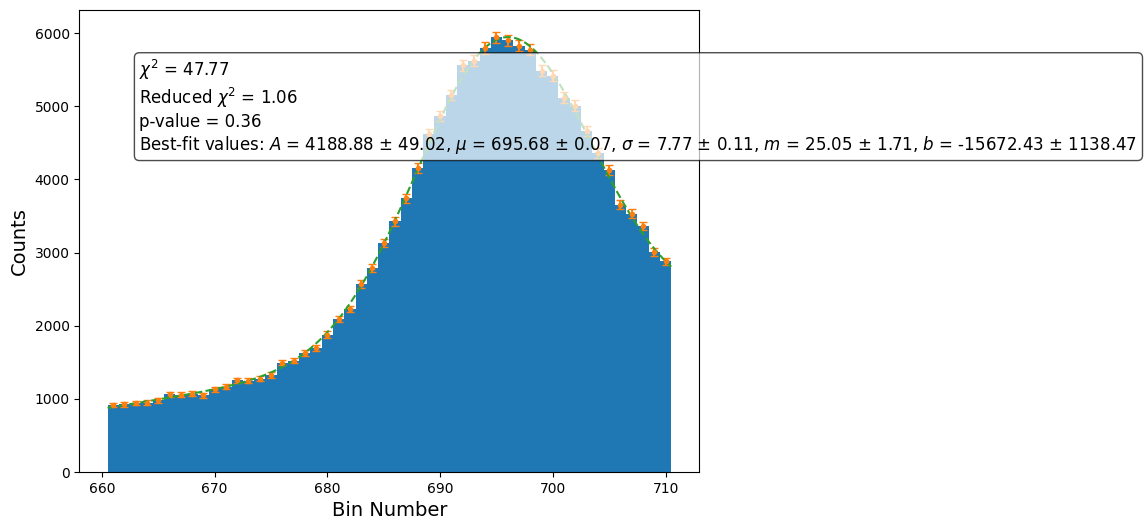

In [13]:
# Recording optimal fit for 133 Barium, 35 kev peak
range_beg = 661
range_end = 710
data_for_hist = []
for bin_num,counts in enumerate(data):
    if bin_num >= range_beg and bin_num <= range_end:
        try:
            for _ in range(int(counts)):
                data_for_hist.append(bin_num)
        except:
            break
fig, ax = plt.subplots(figsize=(8,6))

bins = np.arange(range_beg - 0.5, range_end + 1.5, 1)
hist_counts,bin_edges = ax.hist(data_for_hist,bins=bins)[:2] 

bin_centers = ((bin_edges[:-1] + bin_edges[1:]) / 2)
hist_uncertainties = [x**(0.5) for x in hist_counts]
ax.errorbar(bin_centers,hist_counts,yerr=hist_uncertainties,fmt = '.',capsize = 3)

initial_guess = [hist_counts.max(),mode(data_for_hist)[0],30, 0,0]
fit_func = gaussian_plus_linear

popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,initial_guess,sigma=hist_uncertainties, absolute_sigma=True)
chi2_value = 0
for index,bin_center in enumerate(bin_centers):
    chi2_value += (fit_func(bin_center, *popt) - hist_counts[index])**2/hist_uncertainties[index]**2
dof = len(hist_counts) - len(popt)
reduced_chi2 = chi2_value/dof
chi2_prob = chi2.cdf(chi2_value, dof)
p_val = 1 - chi2_prob

overplot_x = np.linspace(range_beg-0.5, range_end+0.5, num=200)
overplot_y = fit_func(overplot_x, *popt)

ax.plot(overplot_x, overplot_y, linestyle='--')
fig.text(
    0.2, 0.8,  # position relative to the figure, not just the axis
    generate_text_string(fit_func,popt,pcov,chi2_value,reduced_chi2,p_val),
    ha='left', va='top',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
)
ax.set_xlabel("Bin Number", fontsize=14)
ax.set_ylabel("Counts", fontsize=14)
brem_calib[34.986] = (popt[1], pcov[1][1]**0.5)

In [14]:
# # Finding optimal range for 133 Barium, 81 keV peak
# # Candidate fit ranges (tuples of (start, end))
# candidate_ranges = generate_candidate_ranges(1570, 1640,bound = 20, step_size= 3)
# # Candidate models and their initial guesses
# candidate_models = [
#     (gaussian, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10]),
#     (gaussian_plus_linear, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10, 0, 0]),
#     (gaussian_plus_constant, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10, 0]),
# ]

# results = []

# for fit_range in candidate_ranges:
#     # Prepare histogram for this range
#     data_for_hist = []
#     for bin_num, counts in enumerate(data):
#         if fit_range[0] <= bin_num <= fit_range[1]:
#             try:
#                 for _ in range(int(counts)):
#                     data_for_hist.append(bin_num)
#             except Exception:
#                 break
#     bins = np.arange(fit_range[0] - 0.5, fit_range[1] + 1.5, 1)
#     hist_counts, bin_edges = np.histogram(data_for_hist, bins=bins)
#     bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

#     for model_func, guess_func in candidate_models:
#         try:
#             initial_guess = guess_func(hist_counts, bin_centers)
#             fit_result = fit_peak_with_residuals(
#                 data=data,
#                 range_beg=fit_range[0],
#                 range_end=fit_range[1],
#                 fit_func=model_func,
#                 initial_guess=initial_guess,
#                 xlabel="Bin Number",
#                 ylabel="Counts",
#                 title=f"Range {fit_range}, Model {model_func.__name__}",
#                 annotate_fit=False  # We'll annotate only the best fit
#             )
#             results.append({
#                 "range": fit_range,
#                 "model": model_func.__name__,
#                 "fit_result": fit_result
#             })
#         except Exception as e:
#             print(f"Fit failed for range {fit_range} and model {model_func.__name__}: {e}")

# # Select the best fit (lowest reduced chi²)
# best = min(results, key=lambda r: r["fit_result"]["reduced_chi2"])
# print(f"Best fit: Range {best['range']}, Model {best['model']}, Reduced chi² = {best['fit_result']['reduced_chi2']:.2f}")

# # Plot the best fit with annotation
# results = fit_peak_with_residuals(
#     data=data,
#     range_beg=best["range"][0],
#     range_end=best["range"][1],
#     fit_func=eval(best["model"]),
#     initial_guess=best["fit_result"]["popt"],
#     xlabel="Bin Number",
#     ylabel="Counts",
#     title=f"Best Fit: Range {best['range']}, Model {best['model']}",
#     annotate_fit=True,
#     display_plot = True
# )
# popt = results["popt"]

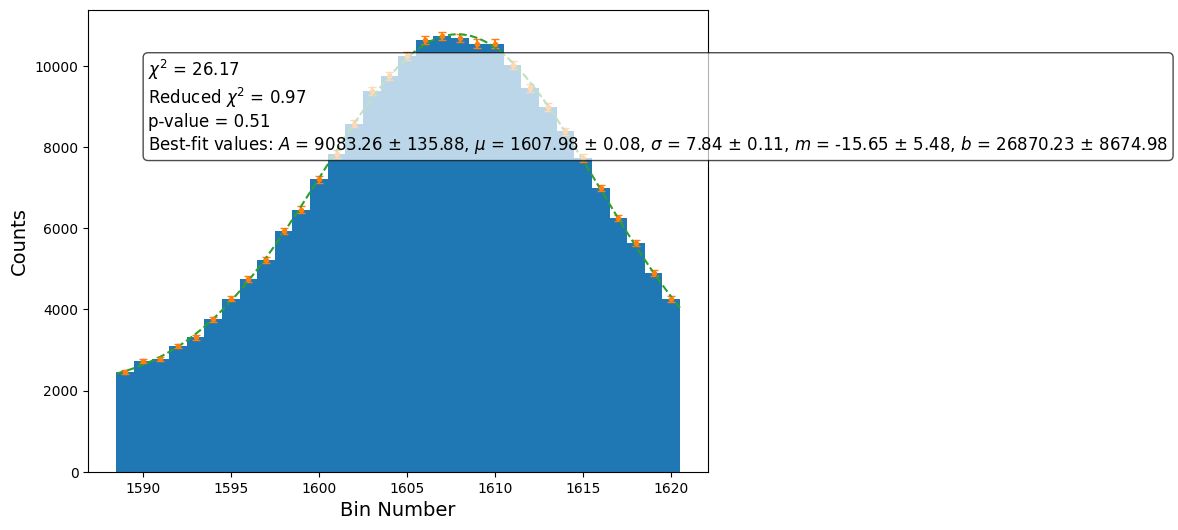

In [15]:
# Recording optimal fit for 133 Barium, 81 keV peak
range_beg = 1589
range_end = 1620
data_for_hist = []
for bin_num,counts in enumerate(data):
    if bin_num >= range_beg and bin_num <= range_end:
        try:
            for _ in range(int(counts)):
                data_for_hist.append(bin_num)
        except:
            break
fig, ax = plt.subplots(figsize=(8,6))

bins = np.arange(range_beg - 0.5, range_end + 1.5, 1)
hist_counts,bin_edges = ax.hist(data_for_hist,bins=bins)[:2] 

bin_centers = ((bin_edges[:-1] + bin_edges[1:]) / 2)
hist_uncertainties = [x**(0.5) for x in hist_counts]
ax.errorbar(bin_centers,hist_counts,yerr=hist_uncertainties,fmt = '.',capsize = 3)

initial_guess = [hist_counts.max(),mode(data_for_hist)[0],10, 0,0]
fit_func = gaussian_plus_linear

popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,initial_guess,sigma=hist_uncertainties, absolute_sigma=True)
chi2_value = 0
for index,bin_center in enumerate(bin_centers):
    chi2_value += (fit_func(bin_center, *popt) - hist_counts[index])**2/hist_uncertainties[index]**2
dof = len(hist_counts) - len(popt)
reduced_chi2 = chi2_value/dof
chi2_prob = chi2.cdf(chi2_value, dof)
p_val = 1 - chi2_prob

overplot_x = np.linspace(range_beg-0.5, range_end+0.5, num=200)
overplot_y = fit_func(overplot_x, *popt)

ax.plot(overplot_x, overplot_y, linestyle='--')
fig.text(
    0.2, 0.8,  # position relative to the figure, not just the axis
    generate_text_string(fit_func,popt,pcov,chi2_value,reduced_chi2,p_val),
    ha='left', va='top',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
)
ax.set_xlabel("Bin Number", fontsize=14)
ax.set_ylabel("Counts", fontsize=14)
brem_calib[81] = (popt[1], pcov[1][1]**0.5)

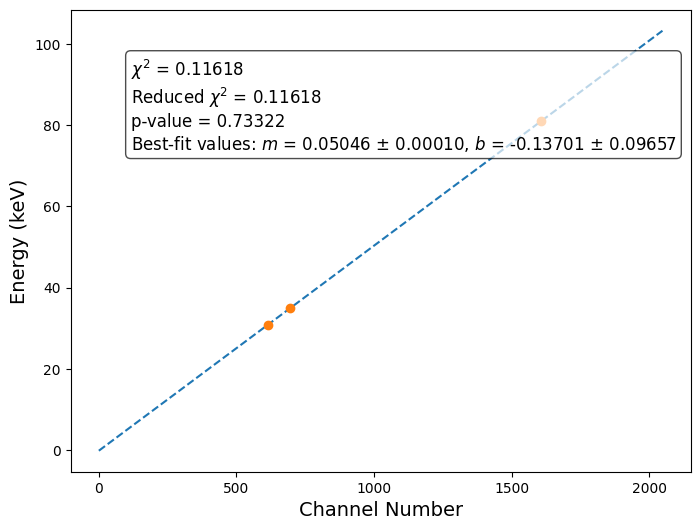

In [16]:
# Finding calibration fit for brem_calib
fit_func = linear
brem_calib_data_np = np.array([[key,*value] for key,value in brem_calib.items()])
channel_nums = brem_calib_data_np[:,1]
energies = brem_calib_data_np[:,0]
energy_errs = brem_calib_data_np[:,2]

popt, pcov = curve_fit(fit_func,channel_nums,energies,[0,0],sigma=brem_calib_data_np[:,2], absolute_sigma=True)

chi2_value = np.sum(((fit_func(channel_nums, *popt) - energies) / energy_errs) ** 2)
dof = len(energies) - len(popt)
reduced_chi2 = chi2_value / dof
chi2_prob = chi2.cdf(chi2_value, dof)
p_val = 1 - chi2_prob


overplot_x = np.linspace(0, 2048, num=200)
overplot_y = linear(overplot_x, *popt)

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(overplot_x, overplot_y, linestyle='--')
ax.errorbar(channel_nums,energies, yerr = brem_calib_data_np[:,2],fmt = 'o')
ax.set_xlabel("Channel Number", fontsize=14)
ax.set_ylabel("Energy (keV)", fontsize=14)
fig.text(
    0.2, 0.8,  # position relative to the figure, not just the axis
    generate_text_string(fit_func,popt,pcov,chi2_value,reduced_chi2,p_val,precision = 5),
    ha='left', va='top',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
)

brem_calib_val = popt
brem_calib_val_err = [pcov[0][0]**0.5, pcov[1][1]**0.5, pcov[0][1]]

<BarContainer object of 2048 artists>

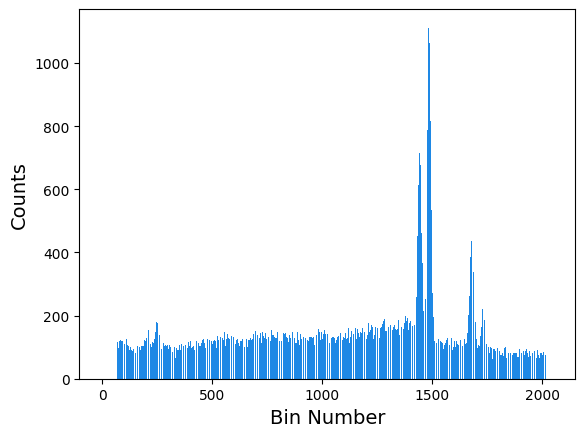

In [17]:
sr1 = "10_01\\sr_lead_slab_x_ray_spectra_10_01.Spe"
data = np.genfromtxt(sr1, delimiter='\n', skip_header=12)
plt.xlabel("Bin Number", fontsize=14)
plt.ylabel("Counts", fontsize=14)
plt.bar(range(2048),data[:2048], color = '#1E88E5')

In [18]:
# # Finding optimal range for Pb, 72 keV KL2 peak
# # Candidate fit ranges (tuples of (start, end))
# candidate_ranges = generate_candidate_ranges(1415, 1470,bound = 15, step_size= 3)
# # Candidate models and their initial guesses
# candidate_models = [
#     (gaussian, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10]),
#     (gaussian_plus_linear, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10, 0, 0]),
#     (gaussian_plus_constant, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10, 0]),
# ]

# results = []

# for fit_range in candidate_ranges:
#     # Prepare histogram for this range
#     data_for_hist = []
#     for bin_num, counts in enumerate(data):
#         if fit_range[0] <= bin_num <= fit_range[1]:
#             try:
#                 for _ in range(int(counts)):
#                     data_for_hist.append(bin_num)
#             except Exception:
#                 break
#     bins = np.arange(fit_range[0] - 0.5, fit_range[1] + 1.5, 1)
#     hist_counts, bin_edges = np.histogram(data_for_hist, bins=bins)
#     bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

#     for model_func, guess_func in candidate_models:
#         try:
#             initial_guess = guess_func(hist_counts, bin_centers)
#             fit_result = fit_peak_with_residuals(
#                 data=data,
#                 range_beg=fit_range[0],
#                 range_end=fit_range[1],
#                 fit_func=model_func,
#                 initial_guess=initial_guess,
#                 xlabel="Bin Number",
#                 ylabel="Counts",
#                 title=f"Range {fit_range}, Model {model_func.__name__}",
#                 annotate_fit=False  # We'll annotate only the best fit
#             )
#             results.append({
#                 "range": fit_range,
#                 "model": model_func.__name__,
#                 "fit_result": fit_result
#             })
#         except Exception as e:
#             print(f"Fit failed for range {fit_range} and model {model_func.__name__}: {e}")

# # Select the best fit (lowest reduced chi²)
# best = min(results, key=lambda r: r["fit_result"]["reduced_chi2"])
# print(f"Best fit: Range {best['range']}, Model {best['model']}, Reduced chi² = {best['fit_result']['reduced_chi2']:.2f}")

# # Plot the best fit with annotation
# final_results = fit_peak_with_residuals(
#     data=data,
#     range_beg=best["range"][0],
#     range_end=best["range"][1],
#     fit_func=eval(best["model"]),
#     initial_guess=best["fit_result"]["popt"],
#     xlabel="Bin Number",
#     ylabel="Counts",
#     title=f"Best Fit: Range {best['range']}, Model {best['model']}",
#     annotate_fit=True,
#     display_plot = True
# )
# popt = final_results["popt"]

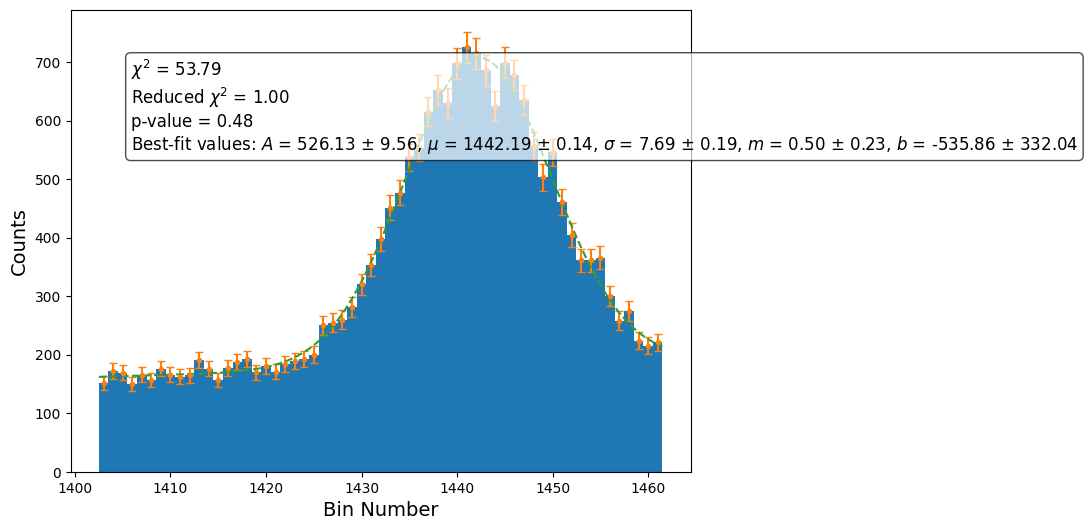

In [19]:
# Recording optimal fit for Pb KL2 peak
range_beg = 1403
range_end = 1461
data_for_hist = []
for bin_num,counts in enumerate(data):
    if bin_num >= range_beg and bin_num <= range_end:
        try:
            for _ in range(int(counts)):
                data_for_hist.append(bin_num)
        except:
            break
fig, ax = plt.subplots(figsize=(8,6))

bins = np.arange(range_beg - 0.5, range_end + 1.5, 1)
hist_counts,bin_edges = ax.hist(data_for_hist,bins=bins)[:2] 

bin_centers = ((bin_edges[:-1] + bin_edges[1:]) / 2)
hist_uncertainties = [x**(0.5) for x in hist_counts]
ax.errorbar(bin_centers,hist_counts,yerr=hist_uncertainties,fmt = '.',capsize = 3)

initial_guess = [hist_counts.max(),mode(data_for_hist)[0],20, 0,0]
fit_func = gaussian_plus_linear

popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,initial_guess,sigma=hist_uncertainties, absolute_sigma=True)

chi2_value = 0
for index,bin_center in enumerate(bin_centers):
    chi2_value += (fit_func(bin_center, *popt) - hist_counts[index])**2/hist_uncertainties[index]**2
dof = len(hist_counts) - len(popt)
reduced_chi2 = chi2_value/dof
chi2_prob = chi2.cdf(chi2_value, dof)
p_val = 1 - chi2_prob

overplot_x = np.linspace(range_beg-0.5, range_end+0.5, num=200)
overplot_y = fit_func(overplot_x, *popt)

ax.plot(overplot_x, overplot_y, linestyle='--')
fig.text(
    0.2, 0.8,  # position relative to the figure, not just the axis
    generate_text_string(fit_func,popt,pcov,chi2_value,reduced_chi2,p_val),
    ha='left', va='top',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
)
ax.set_xlabel("Bin Number", fontsize=14)
ax.set_ylabel("Counts", fontsize=14)
moseleys_lines[("Pb","KL2")] = (get_ener_at_bin(popt[1],*brem_calib_val), calc_ener_err(brem_calib_val, brem_calib_val_err, pcov,popt,1))

In [20]:
# # Finding optimal range for Pb, 75 keV KL3 peak
# # Candidate fit ranges (tuples of (start, end))
# candidate_ranges = generate_candidate_ranges(1465, 1515,bound = 15, step_size= 3)
# # Candidate models and their initial guesses
# candidate_models = [
#     (gaussian, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10]),
#     (gaussian_plus_linear, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10, 0, 0]),
#     (gaussian_plus_constant, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10, 0]),
# ]

# results = []

# for fit_range in candidate_ranges:
#     # Prepare histogram for this range
#     data_for_hist = []
#     for bin_num, counts in enumerate(data):
#         if fit_range[0] <= bin_num <= fit_range[1]:
#             try:
#                 for _ in range(int(counts)):
#                     data_for_hist.append(bin_num)
#             except Exception:
#                 break
#     bins = np.arange(fit_range[0] - 0.5, fit_range[1] + 1.5, 1)
#     hist_counts, bin_edges = np.histogram(data_for_hist, bins=bins)
#     bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

#     for model_func, guess_func in candidate_models:
#         try:
#             initial_guess = guess_func(hist_counts, bin_centers)
#             fit_result = fit_peak_with_residuals(
#                 data=data,
#                 range_beg=fit_range[0],
#                 range_end=fit_range[1],
#                 fit_func=model_func,
#                 initial_guess=initial_guess,
#                 xlabel="Bin Number",
#                 ylabel="Counts",
#                 title=f"Range {fit_range}, Model {model_func.__name__}",
#                 annotate_fit=False  # We'll annotate only the best fit
#             )
#             results.append({
#                 "range": fit_range,
#                 "model": model_func.__name__,
#                 "fit_result": fit_result
#             })
#         except Exception as e:
#             print(f"Fit failed for range {fit_range} and model {model_func.__name__}: {e}")

# # Select the best fit (lowest reduced chi²)
# best = min(results, key=lambda r: r["fit_result"]["reduced_chi2"])
# print(f"Best fit: Range {best['range']}, Model {best['model']}, Reduced chi² = {best['fit_result']['reduced_chi2']:.2f}")

# # Plot the best fit with annotation
# final_results = fit_peak_with_residuals(
#     data=data,
#     range_beg=best["range"][0],
#     range_end=best["range"][1],
#     fit_func=eval(best["model"]),
#     initial_guess=best["fit_result"]["popt"],
#     xlabel="Bin Number",
#     ylabel="Counts",
#     title=f"Best Fit: Range {best['range']}, Model {best['model']}",
#     annotate_fit=True,
#     display_plot = True
# )
# popt = final_results["popt"]

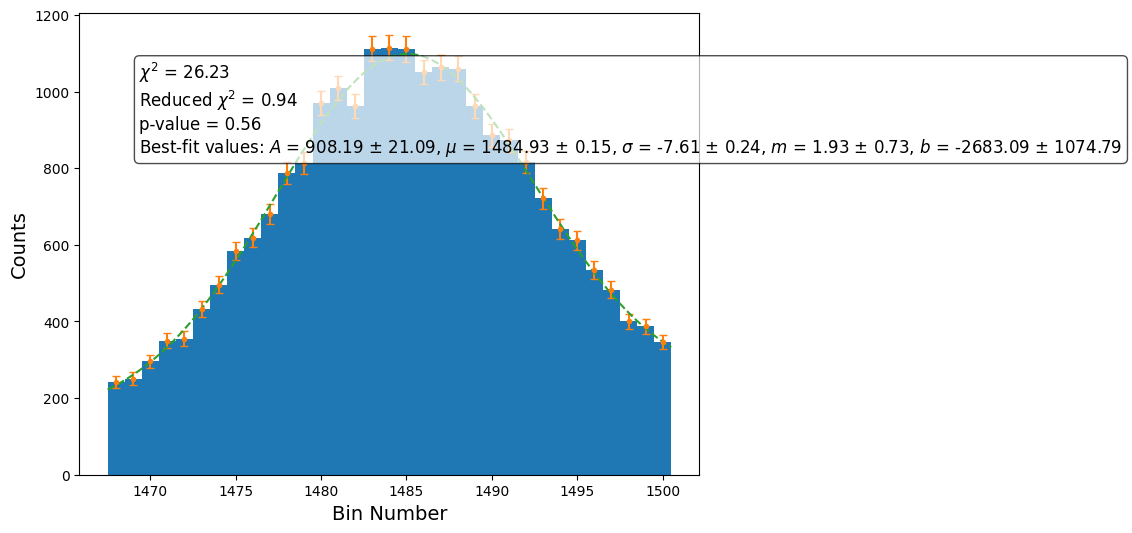

In [21]:
# Recording optimal fit for Pb KL3 75 keV peak
range_beg = 1468
range_end = 1500
data_for_hist = []
for bin_num,counts in enumerate(data):
    if bin_num >= range_beg and bin_num <= range_end:
        try:
            for _ in range(int(counts)):
                data_for_hist.append(bin_num)
        except:
            break
fig, ax = plt.subplots(figsize=(8,6))

bins = np.arange(range_beg - 0.5, range_end + 1.5, 1)
hist_counts,bin_edges = ax.hist(data_for_hist,bins=bins)[:2] 

bin_centers = ((bin_edges[:-1] + bin_edges[1:]) / 2)
hist_uncertainties = [x**(0.5) for x in hist_counts]
ax.errorbar(bin_centers,hist_counts,yerr=hist_uncertainties,fmt = '.',capsize = 3)

initial_guess = [hist_counts.max(),mode(data_for_hist)[0],20, 0,0]
fit_func = gaussian_plus_linear

popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,initial_guess,sigma=hist_uncertainties, absolute_sigma=True)

chi2_value = 0
for index,bin_center in enumerate(bin_centers):
    chi2_value += (fit_func(bin_center, *popt) - hist_counts[index])**2/hist_uncertainties[index]**2
dof = len(hist_counts) - len(popt)
reduced_chi2 = chi2_value/dof
chi2_prob = chi2.cdf(chi2_value, dof)
p_val = 1 - chi2_prob

overplot_x = np.linspace(range_beg-0.5, range_end+0.5, num=200)
overplot_y = fit_func(overplot_x, *popt)

ax.plot(overplot_x, overplot_y, linestyle='--')
fig.text(
    0.2, 0.8,  # position relative to the figure, not just the axis
    generate_text_string(fit_func,popt,pcov,chi2_value,reduced_chi2,p_val),
    ha='left', va='top',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
)
ax.set_xlabel("Bin Number", fontsize=14)
ax.set_ylabel("Counts", fontsize=14)
moseleys_lines[("Pb","KL3")] = (get_ener_at_bin(popt[1],*brem_calib_val), calc_ener_err(brem_calib_val, brem_calib_val_err, pcov,popt,1))

In [22]:
# brem2_calib = {} # used for nothing, would have been used for bremsstrahlung energy calculations
# na1 = "10_01\\na_calibration_x_ray_spectra_10_01.Spe"
# ba4 = "10_01\\barium_low_gain_calibration_x_ray_spectra_10_01.Spe"

In [23]:
# data = np.genfromtxt(ba4, delimiter='\n', skip_header=12)
# plt.bar(range(2048),data[:2048], color = '#1E88E5')

# # CALIBRATING TO 31keV
# range_beg = 85
# range_end = 90

# data_for_hist = []
# for bin_num,counts in enumerate(data):
#     if bin_num >= range_beg and bin_num <= range_end:
#         try:
#             for _ in range(int(counts)):
#                 data_for_hist.append(bin_num)
#         except:
#             break
# fig, ax = plt.subplots(figsize=(8,6))

# bins = np.arange(range_beg - 0.5, range_end + 1.5, 1)
# hist_counts,bin_edges = ax.hist(data_for_hist,bins=bins)[:2] 

# bin_centers = ((bin_edges[:-1] + bin_edges[1:]) / 2)
# hist_uncertainties = [x**(0.5) for x in hist_counts]
# # inputting 1 instead of 0 for histogram bins with 0 counts to fix divide by 0 error.
# had_to_fix_div_by_zero = False
# for i in range(len(hist_uncertainties)):
#     if hist_uncertainties[i] == 0:
#         hist_uncertainties[i] = 1
#         had_to_fix_div_by_zero = True
# ax.errorbar(bin_centers,hist_counts,yerr=hist_uncertainties,fmt = '.',capsize = 3)

# initial_guess = [hist_counts.max(),mode(data_for_hist)[0],20,0,0]
# fit_func = gaussian_plus_linear

# popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,initial_guess,sigma=hist_uncertainties, absolute_sigma=True)
# if had_to_fix_div_by_zero:
#     popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,popt,sigma=[popt[1]**0.5]*len(hist_counts), absolute_sigma=True)
# chi2_value = 0
# for index,bin_center in enumerate(bin_centers):
#     chi2_value += (fit_func(bin_center, *popt) - hist_counts[index])**2/hist_uncertainties[index]**2
# dof = len(hist_counts) - len(popt)
# reduced_chi2 = chi2_value/dof
# chi2_prob = chi2.cdf(chi2_value, dof)
# p_val = 1 - chi2_prob
# overplot_x = np.linspace(range_beg-0.5, range_end+0.5, num=200)
# overplot_y = fit_func(overplot_x, *popt)

# ax.plot(overplot_x, overplot_y, linestyle='--')
# fig.text(
#     0.2, 0.8,  # position relative to the figure, not just the axis
#     generate_text_string(fit_func,popt,pcov,chi2_value,reduced_chi2,p_val),
#     ha='left', va='top',
#     fontsize=12,
#     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
# )
# ax.set_xlabel("Bin Number", fontsize=14)
# ax.set_ylabel("Counts", fontsize=14)
# brem2_calib[30.85] = (popt[1], pcov[1][1]**0.5)

# #--------------------------------------------------------------------------------------------------------------------

# # CALIBRATING TO 35keV
# range_beg = 96
# range_end = 104
# data_for_hist = []
# for bin_num,counts in enumerate(data):
#     if bin_num >= range_beg and bin_num <= range_end:
#         try:
#             for _ in range(int(counts)):
#                 data_for_hist.append(bin_num)
#         except:
#             break
# fig, ax = plt.subplots(figsize=(8,6))

# bins = np.arange(range_beg - 0.5, range_end + 1.5, 1)
# hist_counts,bin_edges = ax.hist(data_for_hist,bins=bins)[:2] 

# bin_centers = ((bin_edges[:-1] + bin_edges[1:]) / 2)
# hist_uncertainties = [x**(0.5) for x in hist_counts]

# # inputting 1 instead of 0 for histogram bins with 0 counts to fix divide by 0 error.
# had_to_fix_div_by_zero = False
# for i in range(len(hist_uncertainties)):
#     if hist_uncertainties[i] == 0:
#         hist_uncertainties[i] = 1
#         had_to_fix_div_by_zero = True
# ax.errorbar(bin_centers,hist_counts,yerr=hist_uncertainties,fmt = '.',capsize = 3)

# initial_guess = [hist_counts.max(),mode(data_for_hist)[0],30, 0,500]
# fit_func = gaussian_plus_linear

# popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,initial_guess,sigma=hist_uncertainties, absolute_sigma=True)
# chi2_value = 0
# for index,bin_center in enumerate(bin_centers):
#     chi2_value += (fit_func(bin_center, *popt) - hist_counts[index])**2/hist_uncertainties[index]**2
# dof = len(hist_counts) - len(popt)
# reduced_chi2 = chi2_value/dof
# chi2_prob = chi2.cdf(chi2_value, dof)
# p_val = 1 - chi2_prob

# overplot_x = np.linspace(range_beg-0.5, range_end+0.5, num=200)
# overplot_y = fit_func(overplot_x, *popt)

# ax.plot(overplot_x, overplot_y, linestyle='--')
# fig.text(
#     0.2, 0.8,  # position relative to the figure, not just the axis
#     generate_text_string(fit_func,popt,pcov,chi2_value,reduced_chi2,p_val),
#     ha='left', va='top',
#     fontsize=12,
#     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
# )
# ax.set_xlabel("Bin Number", fontsize=14)
# ax.set_ylabel("Counts", fontsize=14)
# brem2_calib[34.986] = (popt[1], pcov[1][1]**0.5)

# #--------------------------------------------------------------------------------------------------------------------

# # CALIBRATING TO 81
# range_beg = 227
# range_end = 233
# data_for_hist = []
# for bin_num,counts in enumerate(data):
#     if bin_num >= range_beg and bin_num <= range_end:
#         try:
#             for _ in range(int(counts)):
#                 data_for_hist.append(bin_num)
#         except:
#             break
# fig, ax = plt.subplots(figsize=(8,6))

# bins = np.arange(range_beg - 0.5, range_end + 1.5, 1)
# hist_counts,bin_edges = ax.hist(data_for_hist,bins=bins)[:2] 

# bin_centers = ((bin_edges[:-1] + bin_edges[1:]) / 2)
# hist_uncertainties = [x**(0.5) for x in hist_counts]

# # inputting 1 instead of 0 for histogram bins with 0 counts to fix divide by 0 error.
# had_to_fix_div_by_zero = False
# for i in range(len(hist_uncertainties)):
#     if hist_uncertainties[i] == 0:
#         hist_uncertainties[i] = 1
#         had_to_fix_div_by_zero = True
# ax.errorbar(bin_centers,hist_counts,yerr=hist_uncertainties,fmt = '.',capsize = 3)

# initial_guess = [hist_counts.max(),mode(data_for_hist)[0],30, 0,500]
# fit_func = gaussian_plus_linear

# popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,initial_guess,sigma=hist_uncertainties, absolute_sigma=True)
# chi2_value = 0
# for index,bin_center in enumerate(bin_centers):
#     chi2_value += (fit_func(bin_center, *popt) - hist_counts[index])**2/hist_uncertainties[index]**2
# dof = len(hist_counts) - len(popt)
# reduced_chi2 = chi2_value/dof
# chi2_prob = chi2.cdf(chi2_value, dof)
# p_val = 1 - chi2_prob

# overplot_x = np.linspace(range_beg-0.5, range_end+0.5, num=200)
# overplot_y = fit_func(overplot_x, *popt)

# ax.plot(overplot_x, overplot_y, linestyle='--')
# fig.text(
#     0.2, 0.8,  # position relative to the figure, not just the axis
#     generate_text_string(fit_func,popt,pcov,chi2_value,reduced_chi2,p_val),
#     ha='left', va='top',
#     fontsize=12,
#     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
# )
# ax.set_xlabel("Bin Number", fontsize=14)
# ax.set_ylabel("Counts", fontsize=14)
# brem2_calib[81] = (popt[1], pcov[1][1]**0.5)


# #--------------------------------------------------------------------------------------------------------------------

# # CALIBRATING TO 356
# range_beg = 945
# range_end = 953
# data_for_hist = []
# for bin_num,counts in enumerate(data):
#     if bin_num >= range_beg and bin_num <= range_end:
#         try:
#             for _ in range(int(counts)):
#                 data_for_hist.append(bin_num)
#         except:
#             break
# fig, ax = plt.subplots(figsize=(8,6))

# bins = np.arange(range_beg - 0.5, range_end + 1.5, 1)
# hist_counts,bin_edges = ax.hist(data_for_hist,bins=bins)[:2] 

# bin_centers = ((bin_edges[:-1] + bin_edges[1:]) / 2)
# hist_uncertainties = [x**(0.5) for x in hist_counts]

# # inputting 1 instead of 0 for histogram bins with 0 counts to fix divide by 0 error.
# had_to_fix_div_by_zero = False
# for i in range(len(hist_uncertainties)):
#     if hist_uncertainties[i] == 0:
#         hist_uncertainties[i] = 1
#         had_to_fix_div_by_zero = True
# ax.errorbar(bin_centers,hist_counts,yerr=hist_uncertainties,fmt = '.',capsize = 3)

# initial_guess = [hist_counts.max(),mode(data_for_hist)[0],30]
# fit_func = gaussian

# popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,initial_guess,sigma=hist_uncertainties, absolute_sigma=True)
# chi2_value = 0
# for index,bin_center in enumerate(bin_centers):
#     chi2_value += (fit_func(bin_center, *popt) - hist_counts[index])**2/hist_uncertainties[index]**2
# dof = len(hist_counts) - len(popt)
# reduced_chi2 = chi2_value/dof
# chi2_prob = chi2.cdf(chi2_value, dof)
# p_val = 1 - chi2_prob

# overplot_x = np.linspace(range_beg-0.5, range_end+0.5, num=200)
# overplot_y = fit_func(overplot_x, *popt)

# ax.plot(overplot_x, overplot_y, linestyle='--')
# fig.text(
#     0.2, 0.8,  # position relative to the figure, not just the axis
#     generate_text_string(fit_func,popt,pcov,chi2_value,reduced_chi2,p_val),
#     ha='left', va='top',
#     fontsize=12,
#     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
# )
# ax.set_xlabel("Bin Number", fontsize=14)
# ax.set_ylabel("Counts", fontsize=14)
# brem2_calib[356.02] = (popt[1], pcov[1][1]**0.5)

In [24]:
# na1 = "10_01\\na_calibration_x_ray_spectra_10_01.Spe"

# data = np.genfromtxt(na1, delimiter='\n', skip_header=12)
# plt.bar(range(2048),data[:2048], color = '#1E88E5')

# # CALIBRATING TO 511keV
# range_beg = 1448
# range_end = 1459

# data_for_hist = []
# for bin_num,counts in enumerate(data):
#     if bin_num >= range_beg and bin_num <= range_end:
#         try:
#             for _ in range(int(counts)):
#                 data_for_hist.append(bin_num)
#         except:
#             break
# fig, ax = plt.subplots(figsize=(8,6))

# bins = np.arange(range_beg - 0.5, range_end + 1.5, 1)
# hist_counts,bin_edges = ax.hist(data_for_hist,bins=bins)[:2] 

# bin_centers = ((bin_edges[:-1] + bin_edges[1:]) / 2)
# hist_uncertainties = [x**(0.5) for x in hist_counts]
# # inputting 1 instead of 0 for histogram bins with 0 counts to fix divide by 0 error.
# had_to_fix_div_by_zero = False
# for i in range(len(hist_uncertainties)):
#     if hist_uncertainties[i] == 0:
#         hist_uncertainties[i] = 1
#         had_to_fix_div_by_zero = True
# ax.errorbar(bin_centers,hist_counts,yerr=hist_uncertainties,fmt = '.',capsize = 3,alpha = 0.7)

# initial_guess = [hist_counts.max(),mode(data_for_hist)[0],20]
# fit_func = gaussian

# popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,initial_guess,sigma=hist_uncertainties, absolute_sigma=True)
# if had_to_fix_div_by_zero:
#     popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,popt,sigma=[popt[1]**0.5]*len(hist_counts), absolute_sigma=True)
# chi2_value = 0
# for index,bin_center in enumerate(bin_centers):
#     chi2_value += (fit_func(bin_center, *popt) - hist_counts[index])**2/hist_uncertainties[index]**2
# dof = len(hist_counts) - len(popt)
# reduced_chi2 = chi2_value/dof
# chi2_prob = chi2.cdf(chi2_value, dof)
# p_val = 1 - chi2_prob
# overplot_x = np.linspace(range_beg-0.5, range_end+0.5, num=200)
# overplot_y = fit_func(overplot_x, *popt)

# ax.plot(overplot_x, overplot_y, linestyle='--')
# fig.text(
#     0.2, 0.8,  # position relative to the figure, not just the axis
#     generate_text_string(fit_func,popt,pcov,chi2_value,reduced_chi2,p_val),
#     ha='left', va='top',
#     fontsize=12,
#     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
# )
# ax.set_xlabel("Bin Number", fontsize=14)
# ax.set_ylabel("Counts", fontsize=14)
# brem2_calib[510.99895069] = (popt[1], pcov[1][1]**0.5)

NameError: name 'brem2_calib' is not defined

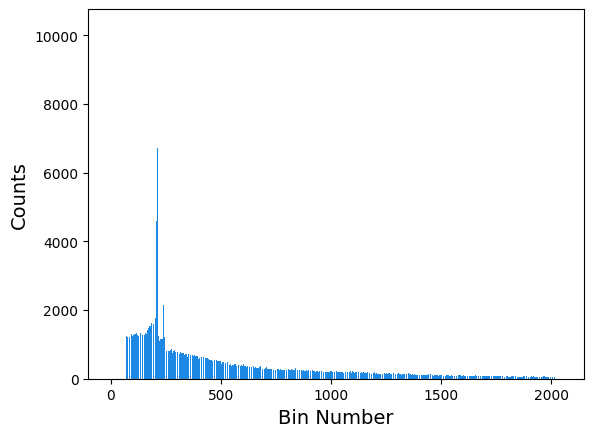

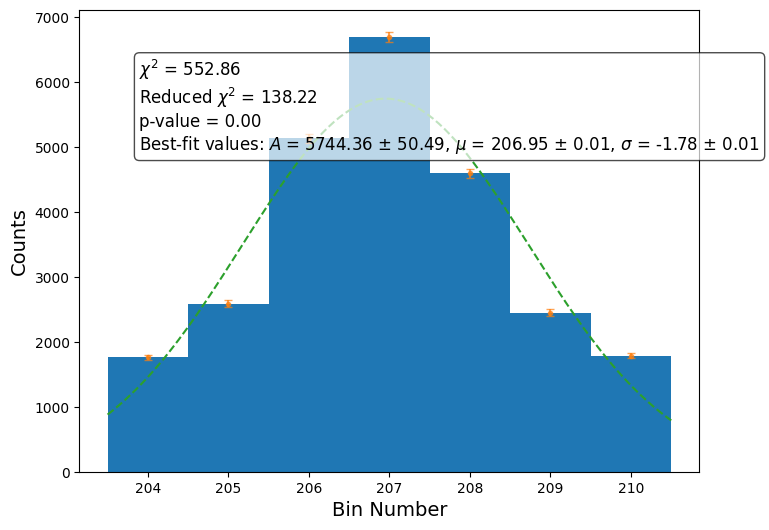

In [39]:
sr2 = "10_01\\sr_lead_slab_x_ray_spectra_2_10_01.Spe"
data = np.genfromtxt(sr2, delimiter='\n', skip_header=12)

plt.xlabel("Bin Number", fontsize=14)
plt.ylabel("Counts", fontsize=14)
plt.bar(range(2048),data[:2048], color = '#1E88E5')

# CALIBRATING TO 72 keV (Lead K-alpha2)
range_beg = 204
range_end = 210

data_for_hist = []
for bin_num,counts in enumerate(data):
    if bin_num >= range_beg and bin_num <= range_end:
        try:
            for _ in range(int(counts)):
                data_for_hist.append(bin_num)
        except:
            break
fig, ax = plt.subplots(figsize=(8,6))

bins = np.arange(range_beg - 0.5, range_end + 1.5, 1)
hist_counts,bin_edges = ax.hist(data_for_hist,bins=bins)[:2] 

bin_centers = ((bin_edges[:-1] + bin_edges[1:]) / 2)
hist_uncertainties = [x**(0.5) for x in hist_counts]
# inputting 1 instead of 0 for histogram bins with 0 counts to fix divide by 0 error.
had_to_fix_div_by_zero = False
for i in range(len(hist_uncertainties)):
    if hist_uncertainties[i] == 0:
        hist_uncertainties[i] = 1
        had_to_fix_div_by_zero = True
ax.errorbar(bin_centers,hist_counts,yerr=hist_uncertainties,fmt = '.',capsize = 3,alpha = 0.7)

initial_guess = [hist_counts.max(),mode(data_for_hist)[0],20]
fit_func = gaussian

popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,initial_guess,sigma=hist_uncertainties, absolute_sigma=True)
if had_to_fix_div_by_zero:
    popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,popt,sigma=[popt[1]**0.5]*len(hist_counts), absolute_sigma=True)
chi2_value = 0
for index,bin_center in enumerate(bin_centers):
    chi2_value += (fit_func(bin_center, *popt) - hist_counts[index])**2/hist_uncertainties[index]**2
dof = len(hist_counts) - len(popt)
reduced_chi2 = chi2_value/dof
chi2_prob = chi2.cdf(chi2_value, dof)
p_val = 1 - chi2_prob
overplot_x = np.linspace(range_beg-0.5, range_end+0.5, num=200)
overplot_y = fit_func(overplot_x, *popt)

ax.plot(overplot_x, overplot_y, linestyle='--')
fig.text(
    0.2, 0.8,  # position relative to the figure, not just the axis
    generate_text_string(fit_func,popt,pcov,chi2_value,reduced_chi2,p_val),
    ha='left', va='top',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
)
ax.set_xlabel("Bin Number", fontsize=14)
ax.set_ylabel("Counts", fontsize=14)
brem2_calib[72.8042] = (popt[1], pcov[1][1])

#--------------------------------------------------------------------------------------------------------------------
# CALIBRATING TO 74.9 keV (Lead K-alpha1)
range_beg = 210
range_end = 216

data_for_hist = []
for bin_num,counts in enumerate(data):
    if bin_num >= range_beg and bin_num <= range_end:
        try:
            for _ in range(int(counts)):
                data_for_hist.append(bin_num)
        except:
            break
fig, ax = plt.subplots(figsize=(8,6))

bins = np.arange(range_beg - 0.5, range_end + 1.5, 1)
hist_counts,bin_edges = ax.hist(data_for_hist,bins=bins)[:2] 

bin_centers = ((bin_edges[:-1] + bin_edges[1:]) / 2)
hist_uncertainties = [x**(0.5) for x in hist_counts]
# inputting 1 instead of 0 for histogram bins with 0 counts to fix divide by 0 error.
had_to_fix_div_by_zero = False
for i in range(len(hist_uncertainties)):
    if hist_uncertainties[i] == 0:
        hist_uncertainties[i] = 1
        had_to_fix_div_by_zero = True
ax.errorbar(bin_centers,hist_counts,yerr=hist_uncertainties,fmt = '.',capsize = 3,alpha = 0.7)

initial_guess = [hist_counts.max(),mode(data_for_hist)[0],20]
fit_func = gaussian

popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,initial_guess,sigma=hist_uncertainties, absolute_sigma=True)
if had_to_fix_div_by_zero:
    popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,popt,sigma=[popt[1]**0.5]*len(hist_counts), absolute_sigma=True)
chi2_value = 0
for index,bin_center in enumerate(bin_centers):
    chi2_value += (fit_func(bin_center, *popt) - hist_counts[index])**2/hist_uncertainties[index]**2
dof = len(hist_counts) - len(popt)
reduced_chi2 = chi2_value/dof
chi2_prob = chi2.cdf(chi2_value, dof)
p_val = 1 - chi2_prob
overplot_x = np.linspace(range_beg-0.5, range_end+0.5, num=200)
overplot_y = fit_func(overplot_x, *popt)

ax.plot(overplot_x, overplot_y, linestyle='--')
fig.text(
    0.2, 0.8,  # position relative to the figure, not just the axis
    generate_text_string(fit_func,popt,pcov,chi2_value,reduced_chi2,p_val),
    ha='left', va='top',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
)
ax.set_xlabel("Bin Number", fontsize=14)
ax.set_ylabel("Counts", fontsize=14)
brem2_calib[74.970] = (popt[1], pcov[1][1]**0.5)

#--------------------------------------------------------------------------------------------------------------------
# CALIBRATING TO 84 keV (Lead K-beta1)
range_beg = 238
range_end = 244

data_for_hist = []
for bin_num,counts in enumerate(data):
    if bin_num >= range_beg and bin_num <= range_end:
        try:
            for _ in range(int(counts)):
                data_for_hist.append(bin_num)
        except:
            break
fig, ax = plt.subplots(figsize=(8,6))

bins = np.arange(range_beg - 0.5, range_end + 1.5, 1)
hist_counts,bin_edges = ax.hist(data_for_hist,bins=bins)[:2] 

bin_centers = ((bin_edges[:-1] + bin_edges[1:]) / 2)
hist_uncertainties = [x**(0.5) for x in hist_counts]
# inputting 1 instead of 0 for histogram bins with 0 counts to fix divide by 0 error.
had_to_fix_div_by_zero = False
for i in range(len(hist_uncertainties)):
    if hist_uncertainties[i] == 0:
        hist_uncertainties[i] = 1
        had_to_fix_div_by_zero = True
ax.errorbar(bin_centers,hist_counts,yerr=hist_uncertainties,fmt = '.',capsize = 3,alpha = 0.7)

initial_guess = [hist_counts.max(),mode(data_for_hist)[0],20]
fit_func = gaussian

popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,initial_guess,sigma=hist_uncertainties, absolute_sigma=True)
if had_to_fix_div_by_zero:
    popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,popt,sigma=[popt[1]**0.5]*len(hist_counts), absolute_sigma=True)
chi2_value = 0
for index,bin_center in enumerate(bin_centers):
    chi2_value += (fit_func(bin_center, *popt) - hist_counts[index])**2/hist_uncertainties[index]**2
dof = len(hist_counts) - len(popt)
reduced_chi2 = chi2_value/dof
chi2_prob = chi2.cdf(chi2_value, dof)
p_val = 1 - chi2_prob
overplot_x = np.linspace(range_beg-0.5, range_end+0.5, num=200)
overplot_y = fit_func(overplot_x, *popt)

ax.plot(overplot_x, overplot_y, linestyle='--')
fig.text(
    0.2, 0.8,  # position relative to the figure, not just the axis
    generate_text_string(fit_func,popt,pcov,chi2_value,reduced_chi2,p_val),
    ha='left', va='top',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
)
ax.set_xlabel("Bin Number", fontsize=14)
ax.set_ylabel("Counts", fontsize=14)
brem2_calib[84.936] = (popt[1], pcov[1][1]**0.5)

#--------------------------------------------------------------------------------------------------------------------
# CALIBRATING TO 87 keV (Lead K-N)
range_beg = 245
range_end = 251

data_for_hist = []
for bin_num,counts in enumerate(data):
    if bin_num >= range_beg and bin_num <= range_end:
        try:
            for _ in range(int(counts)):
                data_for_hist.append(bin_num)
        except:
            break
fig, ax = plt.subplots(figsize=(8,6))

bins = np.arange(range_beg - 0.5, range_end + 1.5, 1)
hist_counts,bin_edges = ax.hist(data_for_hist,bins=bins)[:2] 

bin_centers = ((bin_edges[:-1] + bin_edges[1:]) / 2)
hist_uncertainties = [x**(0.5) for x in hist_counts]
# inputting 1 instead of 0 for histogram bins with 0 counts to fix divide by 0 error.
had_to_fix_div_by_zero = False
for i in range(len(hist_uncertainties)):
    if hist_uncertainties[i] == 0:
        hist_uncertainties[i] = 1
        had_to_fix_div_by_zero = True
ax.errorbar(bin_centers,hist_counts,yerr=hist_uncertainties,fmt = '.',capsize = 3,alpha = 0.7)

initial_guess = [hist_counts.max(),mode(data_for_hist)[0],20, 0,0]
fit_func = gaussian_plus_linear

popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,initial_guess,sigma=hist_uncertainties, absolute_sigma=True)
if had_to_fix_div_by_zero:
    popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,popt,sigma=[popt[1]**0.5]*len(hist_counts), absolute_sigma=True)
chi2_value = 0
for index,bin_center in enumerate(bin_centers):
    chi2_value += (fit_func(bin_center, *popt) - hist_counts[index])**2/hist_uncertainties[index]**2
dof = len(hist_counts) - len(popt)
reduced_chi2 = chi2_value/dof
chi2_prob = chi2.cdf(chi2_value, dof)
p_val = 1 - chi2_prob
overplot_x = np.linspace(range_beg-0.5, range_end+0.5, num=200)
overplot_y = fit_func(overplot_x, *popt)

ax.plot(overplot_x, overplot_y, linestyle='--')
fig.text(
    0.2, 0.8,  # position relative to the figure, not just the axis
    generate_text_string(fit_func,popt,pcov,chi2_value,reduced_chi2,p_val),
    ha='left', va='top',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
)
ax.set_xlabel("Bin Number", fontsize=14)
ax.set_ylabel("Counts", fontsize=14)
brem2_calib[87.4] = (popt[1], pcov[1][1]**0.5)

In [26]:
# fit_func = linear
# brem2_calib_data_np = np.array([[key,*value] for key,value in brem2_calib.items()])
# channel_nums = brem2_calib_data_np[:,1]
# energies = brem2_calib_data_np[:,0]
# energy_errs = brem2_calib_data_np[:,2]

# popt, pcov = curve_fit(fit_func,channel_nums,energies,[0,0],sigma=brem2_calib_data_np[:,2], absolute_sigma=True)
# chi2_value = np.sum(((fit_func(channel_nums, *popt) - energies) / energy_errs) ** 2)
# dof = len(energies) - len(popt)
# reduced_chi2 = chi2_value / dof
# chi2_prob = chi2.cdf(chi2_value, dof)
# p_val = 1 - chi2_prob

# overplot_x = np.linspace(0, 2048, num=200)
# overplot_y = linear(overplot_x, *popt)

# fig, ax = plt.subplots(figsize=(8,6))

# ax.plot(overplot_x, overplot_y, linestyle='--')
# ax.errorbar(channel_nums,energies, yerr = brem2_calib_data_np[:,2],fmt = 'o')
# ax.set_xlabel("Channel Number", fontsize=14)
# ax.set_ylabel("Energy (keV)", fontsize=14)
# fig.text(
#     0.2, 0.8,  # position relative to the figure, not just the axis
#     generate_text_string(fit_func,popt,pcov,chi2_value,reduced_chi2,p_val,precision = 5),
#     ha='left', va='top',
#     fontsize=12,
#     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
# )

# brem2_calib_val = popt
# brem2_calib_val_err = [pcov[0][0]**0.5, pcov[1][1]**0.5]

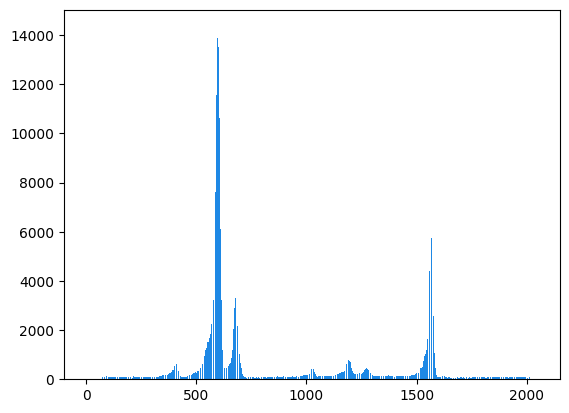

In [27]:
ba7 = "10_01\\barium_low_gain_calibration_x_ray_spectra_2_10_01.Spe"
data = np.genfromtxt(ba7, delimiter='\n', skip_header=12)
plt.bar(range(2048),data[:2048], color = '#1E88E5')
bi_calib = {}

In [28]:
# # Finding optimal range for 133 Barium, 31 keV peak
# # Candidate fit ranges (tuples of (start, end))
# candidate_ranges = generate_candidate_ranges(565, 635,bound = 20, step_size= 3)
# # Candidate models and their initial guesses
# candidate_models = [
#     # (gaussian, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10]),
#     # (gaussian_plus_linear, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10, 0, 0]),
#     # (gaussian_plus_constant, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10, 0]),
#     (two_gaussians, lambda counts, bins: [max(counts)/2, bins[np.argmax(counts)]-5, 10, max(counts)/2, bins[np.argmax(counts)]+5, 10])
# ]

# results = []

# for fit_range in candidate_ranges:
#     # Prepare histogram for this range
#     data_for_hist = []
#     for bin_num, counts in enumerate(data):
#         if fit_range[0] <= bin_num <= fit_range[1]:
#             try:
#                 for _ in range(int(counts)):
#                     data_for_hist.append(bin_num)
#             except Exception:
#                 break
#     bins = np.arange(fit_range[0] - 0.5, fit_range[1] + 1.5, 1)
#     hist_counts, bin_edges = np.histogram(data_for_hist, bins=bins)
#     bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

#     for model_func, guess_func in candidate_models:
#         try:
#             initial_guess = guess_func(hist_counts, bin_centers)
#             fit_result = fit_peak_with_residuals(
#                 data=data,
#                 range_beg=fit_range[0],
#                 range_end=fit_range[1],
#                 fit_func=model_func,
#                 initial_guess=initial_guess,
#                 xlabel="Bin Number",
#                 ylabel="Counts",
#                 title=f"Range {fit_range}, Model {model_func.__name__}",
#                 annotate_fit=False  # We'll annotate only the best fit
#             )
#             results.append({
#                 "range": fit_range,
#                 "model": model_func.__name__,
#                 "fit_result": fit_result
#             })
#         except Exception as e:
#             print(f"Fit failed for range {fit_range} and model {model_func.__name__}: {e}")

# # Select the best fit (lowest reduced chi²)
# best = min(results, key=lambda r: r["fit_result"]["reduced_chi2"])
# print(f"Best fit: Range {best['range']}, Model {best['model']}, Reduced chi² = {best['fit_result']['reduced_chi2']:.2f}")

# # Plot the best fit with annotation
# results = fit_peak_with_residuals(
#     data=data,
#     range_beg=best["range"][0],
#     range_end=best["range"][1],
#     fit_func=eval(best["model"]),
#     initial_guess=best["fit_result"]["popt"],
#     xlabel="Bin Number",
#     ylabel="Counts",
#     title=f"Best Fit: Range {best['range']}, Model {best['model']}",
#     annotate_fit=True,
#     display_plot = True
# )
# popt = results["popt"]

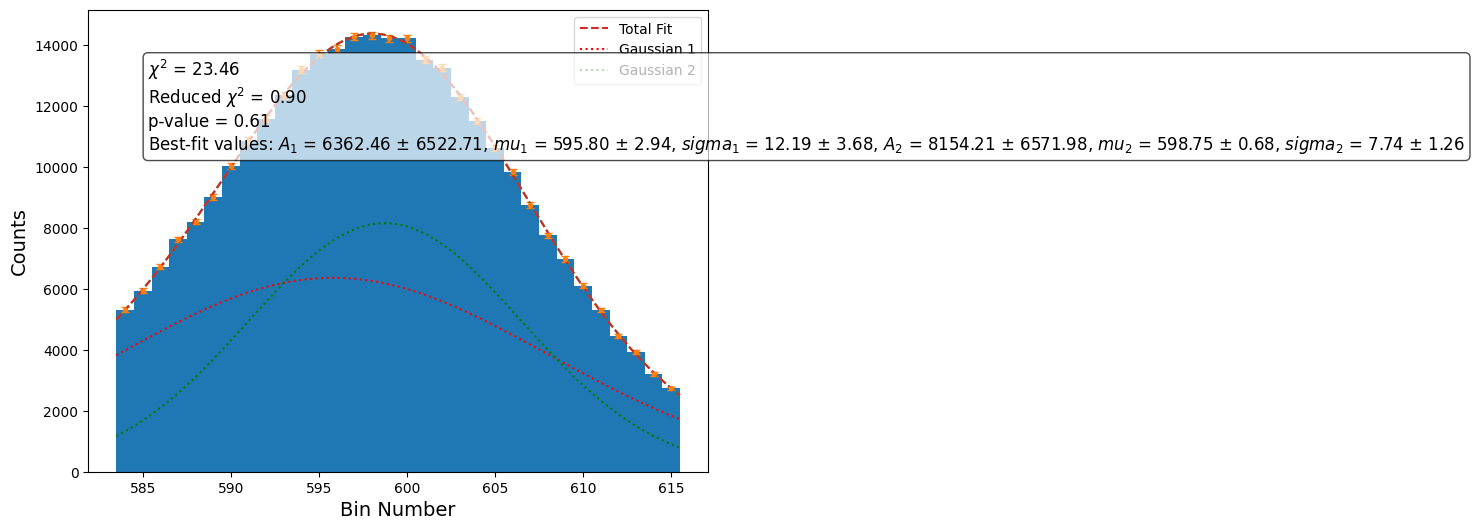

In [29]:
# Recording optimal fit for 133 Barium, 31 keV peaks
range_beg = 584
range_end = 615

data_for_hist = []
for bin_num,counts in enumerate(data):
    if bin_num >= range_beg and bin_num <= range_end:
        try:
            for _ in range(int(counts)):
                data_for_hist.append(bin_num)
        except:
            break
fig, ax = plt.subplots(figsize=(8,6))

bins = np.arange(range_beg - 0.5, range_end + 1.5, 1)
hist_counts,bin_edges = ax.hist(data_for_hist,bins=bins)[:2] 

bin_centers = ((bin_edges[:-1] + bin_edges[1:]) / 2)
hist_uncertainties = [x**(0.5) for x in hist_counts]
ax.errorbar(bin_centers,hist_counts,yerr=hist_uncertainties,fmt = '.',capsize = 3)

initial_guess =[hist_counts.max()/2,mode(data_for_hist)[0] -5 ,10,   hist_counts.max()/2,mode(data_for_hist)[0] + 5,10]
fit_func = two_gaussians

popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,initial_guess,sigma=hist_uncertainties, absolute_sigma=True)

chi2_value = 0
for index,bin_center in enumerate(bin_centers):
    chi2_value += (fit_func(bin_center, *popt) - hist_counts[index])**2/hist_uncertainties[index]**2
dof = len(hist_counts) - len(popt)
reduced_chi2 = chi2_value/dof
chi2_prob = chi2.cdf(chi2_value, dof)
p_val = 1 - chi2_prob

overplot_x = np.linspace(range_beg-0.5, range_end+0.5, num=200)
overplot_y = fit_func(overplot_x, *popt)

ax.plot(overplot_x, overplot_y, linestyle='--')
fig.text(
    0.2, 0.8,  # position relative to the figure, not just the axis
    generate_text_string(fit_func,popt,pcov,chi2_value,reduced_chi2,p_val),
    ha='left', va='top',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
)
ax.set_xlabel("Bin Number", fontsize=14)
ax.set_ylabel("Counts", fontsize=14)

# Individual Gaussians
gauss1 = popt[0] * np.exp(-0.5 * ((overplot_x - popt[1]) / popt[2]) ** 2)
gauss2 = popt[3] * np.exp(-0.5 * ((overplot_x - popt[4]) / popt[5]) ** 2)

ax.plot(overplot_x, overplot_y, linestyle='--', label='Total Fit')
ax.plot(overplot_x, gauss1, linestyle=':', color='red', label='Gaussian 1')
ax.plot(overplot_x, gauss2, linestyle=':', color='green', label='Gaussian 2')
ax.legend()

bi_calib[30.6251] = (popt[1], np.sqrt(pcov[1][1]))
bi_calib[30.9721] = (popt[4], np.sqrt(pcov[4][4]))

In [30]:
# # Finding optimal range for 133 Barium, 35 keV peak
# # Candidate fit ranges (tuples of (start, end))
# candidate_ranges = generate_candidate_ranges(650,705,bound = 15, step_size= 1)
# # Candidate models and their initial guesses
# candidate_models = [
#     (gaussian, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10]),
#     (gaussian_plus_linear, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10, 0, 0]),
#     (gaussian_plus_constant, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10, 0])
# ]

# results = []

# for fit_range in candidate_ranges:
#     # Prepare histogram for this range
#     data_for_hist = []
#     for bin_num, counts in enumerate(data):
#         if fit_range[0] <= bin_num <= fit_range[1]:
#             try:
#                 for _ in range(int(counts)):
#                     data_for_hist.append(bin_num)
#             except Exception:
#                 break
#     bins = np.arange(fit_range[0] - 0.5, fit_range[1] + 1.5, 1)
#     hist_counts, bin_edges = np.histogram(data_for_hist, bins=bins)
#     bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

#     for model_func, guess_func in candidate_models:
#         try:
#             initial_guess = guess_func(hist_counts, bin_centers)
#             fit_result = fit_peak_with_residuals(
#                 data=data,
#                 range_beg=fit_range[0],
#                 range_end=fit_range[1],
#                 fit_func=model_func,
#                 initial_guess=initial_guess,
#                 xlabel="Bin Number",
#                 ylabel="Counts",
#                 title=f"Range {fit_range}, Model {model_func.__name__}",
#                 annotate_fit=False  # We'll annotate only the best fit
#             )
#             results.append({
#                 "range": fit_range,
#                 "model": model_func.__name__,
#                 "fit_result": fit_result
#             })
#         except Exception as e:
#             print(f"Fit failed for range {fit_range} and model {model_func.__name__}: {e}")

# # Select the best fit (lowest reduced chi²)
# best = min(results, key=lambda r: r["fit_result"]["reduced_chi2"])
# print(f"Best fit: Range {best['range']}, Model {best['model']}, Reduced chi² = {best['fit_result']['reduced_chi2']:.2f}")

# # Plot the best fit with annotation
# results = fit_peak_with_residuals(
#     data=data,
#     range_beg=best["range"][0],
#     range_end=best["range"][1],
#     fit_func=eval(best["model"]),
#     initial_guess=best["fit_result"]["popt"],
#     xlabel="Bin Number",
#     ylabel="Counts",
#     title=f"Best Fit: Range {best['range']}, Model {best['model']}",
#     annotate_fit=True,
#     display_plot = True
# )
# popt = results["popt"]

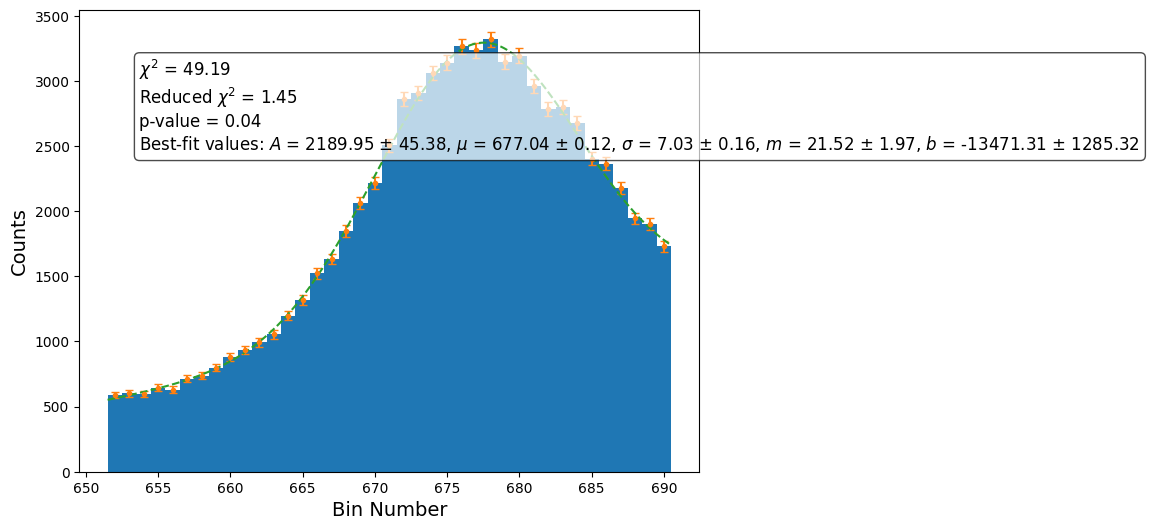

In [31]:
# Recording calibration for 133 Ba 35 keV peak
range_beg = 652
range_end = 690
data_for_hist = []
for bin_num,counts in enumerate(data):
    if bin_num >= range_beg and bin_num <= range_end:
        try:
            for _ in range(int(counts)):
                data_for_hist.append(bin_num)
        except:
            break
fig, ax = plt.subplots(figsize=(8,6))

bins = np.arange(range_beg - 0.5, range_end + 1.5, 1)
hist_counts,bin_edges = ax.hist(data_for_hist,bins=bins)[:2] 

bin_centers = ((bin_edges[:-1] + bin_edges[1:]) / 2)
hist_uncertainties = [x**(0.5) for x in hist_counts]

# inputting 1 instead of 0 for histogram bins with 0 counts to fix divide by 0 error.
had_to_fix_div_by_zero = False
for i in range(len(hist_uncertainties)):
    if hist_uncertainties[i] == 0:
        hist_uncertainties[i] = 1
        had_to_fix_div_by_zero = True
ax.errorbar(bin_centers,hist_counts,yerr=hist_uncertainties,fmt = '.',capsize = 3)

initial_guess = [hist_counts.max(),mode(data_for_hist)[0],15, 0,0]
fit_func = gaussian_plus_linear

popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,initial_guess,sigma=hist_uncertainties, absolute_sigma=True)
chi2_value = 0
for index,bin_center in enumerate(bin_centers):
    chi2_value += (fit_func(bin_center, *popt) - hist_counts[index])**2/hist_uncertainties[index]**2
dof = len(hist_counts) - len(popt)
reduced_chi2 = chi2_value/dof
chi2_prob = chi2.cdf(chi2_value, dof)
p_val = 1 - chi2_prob

overplot_x = np.linspace(range_beg-0.5, range_end+0.5, num=200)
overplot_y = fit_func(overplot_x, *popt)

ax.plot(overplot_x, overplot_y, linestyle='--')
fig.text(
    0.2, 0.8,  # position relative to the figure, not just the axis
    generate_text_string(fit_func,popt,pcov,chi2_value,reduced_chi2,p_val),
    ha='left', va='top',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
)
ax.set_xlabel("Bin Number", fontsize=14)
ax.set_ylabel("Counts", fontsize=14)
bi_calib[34.986] = (popt[1], pcov[1][1]**0.5)

In [32]:
# # Finding optimal range for 133 Barium, 81 keV peak
# # Candidate fit ranges (tuples of (start, end))
# candidate_ranges = generate_candidate_ranges(1540,1590,bound = 15, step_size= 3)
# # Candidate models and their initial guesses
# candidate_models = [
#     (gaussian, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10]),
#     (gaussian_plus_linear, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10, 0, 0]),
#     (gaussian_plus_constant, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10, 0])
# ]

# results = []

# for fit_range in candidate_ranges:
#     # Prepare histogram for this range
#     data_for_hist = []
#     for bin_num, counts in enumerate(data):
#         if fit_range[0] <= bin_num <= fit_range[1]:
#             try:
#                 for _ in range(int(counts)):
#                     data_for_hist.append(bin_num)
#             except Exception:
#                 break
#     bins = np.arange(fit_range[0] - 0.5, fit_range[1] + 1.5, 1)
#     hist_counts, bin_edges = np.histogram(data_for_hist, bins=bins)
#     bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

#     for model_func, guess_func in candidate_models:
#         try:
#             initial_guess = guess_func(hist_counts, bin_centers)
#             fit_result = fit_peak_with_residuals(
#                 data=data,
#                 range_beg=fit_range[0],
#                 range_end=fit_range[1],
#                 fit_func=model_func,
#                 initial_guess=initial_guess,
#                 xlabel="Bin Number",
#                 ylabel="Counts",
#                 title=f"Range {fit_range}, Model {model_func.__name__}",
#                 annotate_fit=False  # We'll annotate only the best fit
#             )
#             results.append({
#                 "range": fit_range,
#                 "model": model_func.__name__,
#                 "fit_result": fit_result
#             })
#         except Exception as e:
#             print(f"Fit failed for range {fit_range} and model {model_func.__name__}: {e}")

# # Select the best fit (lowest reduced chi²)
# best = min(results, key=lambda r: r["fit_result"]["reduced_chi2"])
# print(f"Best fit: Range {best['range']}, Model {best['model']}, Reduced chi² = {best['fit_result']['reduced_chi2']:.2f}")

# # Plot the best fit with annotation
# results = fit_peak_with_residuals(
#     data=data,
#     range_beg=best["range"][0],
#     range_end=best["range"][1],
#     fit_func=eval(best["model"]),
#     initial_guess=best["fit_result"]["popt"],
#     xlabel="Bin Number",
#     ylabel="Counts",
#     title=f"Best Fit: Range {best['range']}, Model {best['model']}",
#     annotate_fit=True,
#     display_plot = True
# )
# popt = results["popt"]

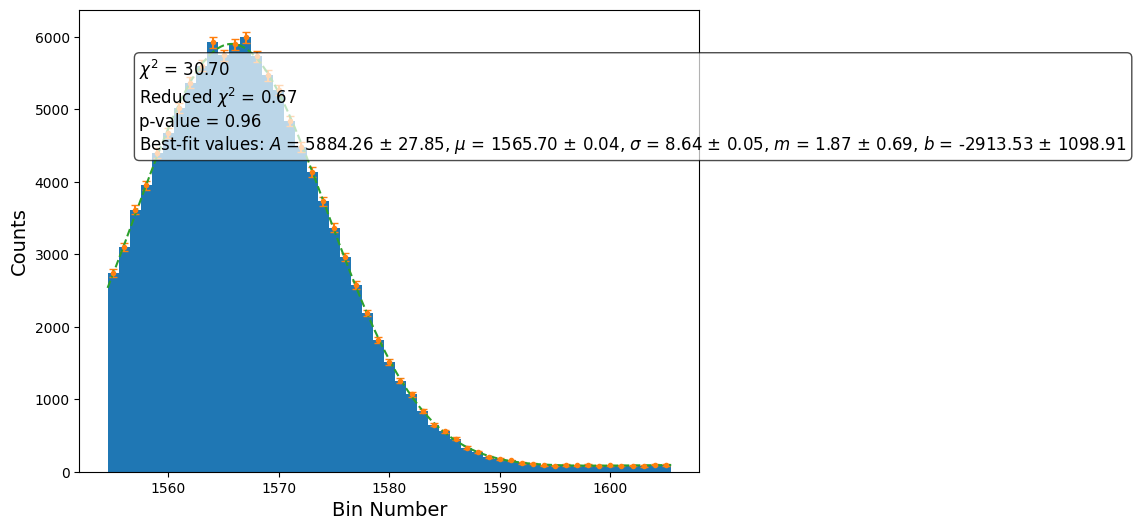

In [33]:
# Recording calibration for 133 Ba 81 keV peak
range_beg = 1555
range_end = 1605
data_for_hist = []
for bin_num,counts in enumerate(data):
    if bin_num >= range_beg and bin_num <= range_end:
        try:
            for _ in range(int(counts)):
                data_for_hist.append(bin_num)
        except:
            break
fig, ax = plt.subplots(figsize=(8,6))

bins = np.arange(range_beg - 0.5, range_end + 1.5, 1)
hist_counts,bin_edges = ax.hist(data_for_hist,bins=bins)[:2] 

bin_centers = ((bin_edges[:-1] + bin_edges[1:]) / 2)
hist_uncertainties = [x**(0.5) for x in hist_counts]
ax.errorbar(bin_centers,hist_counts,yerr=hist_uncertainties,fmt = '.',capsize = 3)

initial_guess = [hist_counts.max(),mode(data_for_hist)[0],10, 0,0]
fit_func = gaussian_plus_linear

popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,initial_guess,sigma=hist_uncertainties, absolute_sigma=True)
chi2_value = 0
for index,bin_center in enumerate(bin_centers):
    chi2_value += (fit_func(bin_center, *popt) - hist_counts[index])**2/hist_uncertainties[index]**2
dof = len(hist_counts) - len(popt)
reduced_chi2 = chi2_value/dof
chi2_prob = chi2.cdf(chi2_value, dof)
p_val = 1 - chi2_prob

overplot_x = np.linspace(range_beg-0.5, range_end+0.5, num=200)
overplot_y = fit_func(overplot_x, *popt)

ax.plot(overplot_x, overplot_y, linestyle='--')
fig.text(
    0.2, 0.8,  # position relative to the figure, not just the axis
    generate_text_string(fit_func,popt,pcov,chi2_value,reduced_chi2,p_val),
    ha='left', va='top',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
)
ax.set_xlabel("Bin Number", fontsize=14)
ax.set_ylabel("Counts", fontsize=14)
bi_calib[81] = (popt[1], pcov[1][1]**0.5)

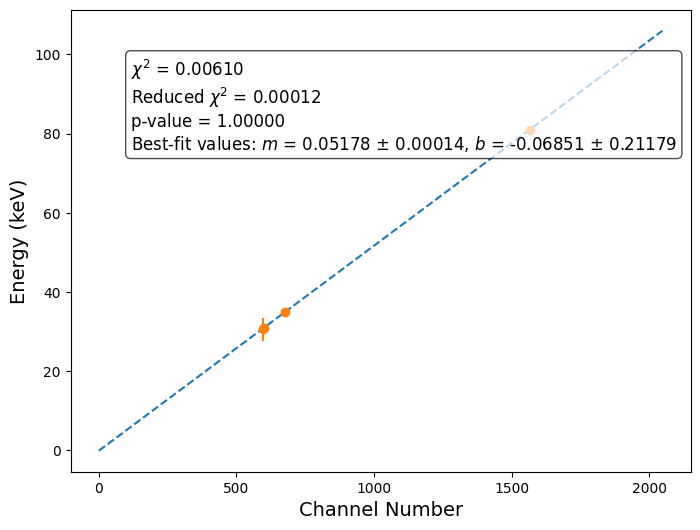

In [34]:
# Finding linear calibration fit for bismuth
fit_func = linear
bi_calib_data_np = np.array([[key,*value] for key,value in bi_calib.items()])
channel_nums = bi_calib_data_np[:,1]
energies = bi_calib_data_np[:,0]
energy_errs = bi_calib_data_np[:,2]

popt, pcov = curve_fit(fit_func,channel_nums,energies,[0,0],sigma=bi_calib_data_np[:,2], absolute_sigma=True)
chi2_value = np.sum(((fit_func(channel_nums, *popt) - energies) / energy_errs) ** 2)
dof = len(energies) - len(popt)
reduced_chi2 = chi2_value / dof
chi2_prob = chi2.cdf(chi2_value, dof)
p_val = 1 - chi2_prob

dof = len(hist_counts) - len(popt)
reduced_chi2 = chi2_value/dof
chi2_prob = chi2.cdf(chi2_value, dof)
p_val = 1 - chi2_prob


overplot_x = np.linspace(0, 2048, num=200)
overplot_y = linear(overplot_x, *popt)

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(overplot_x, overplot_y, linestyle='--')
ax.errorbar(channel_nums,energies, yerr = bi_calib_data_np[:,2],fmt = 'o')
ax.set_xlabel("Channel Number", fontsize=14)
ax.set_ylabel("Energy (keV)", fontsize=14)
fig.text(
    0.2, 0.8,  # position relative to the figure, not just the axis
    generate_text_string(fit_func,popt,pcov,chi2_value,reduced_chi2,p_val,precision = 5),
    ha='left', va='top',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
)

bi_calib_val = popt
bi_calib_val_err = [pcov[0][0]**0.5, pcov[1][1]**0.5, pcov[0][1]]

<BarContainer object of 2048 artists>

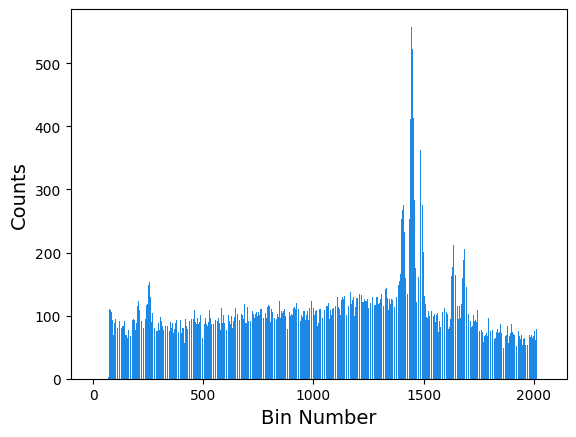

In [35]:
bi = "10_01\\sr_bi_x_ray_spectra_10_01.Spe"
data = np.genfromtxt(bi, delimiter='\n', skip_header=12)
plt.xlabel("Bin Number", fontsize=14)
plt.ylabel("Counts", fontsize=14)
plt.bar(range(2048),data[:2048], color = '#1E88E5')

In [36]:
# # Finding optimal range for Bismuth, 77 keV peak
# # Candidate fit ranges (tuples of (start, end))
# candidate_ranges = generate_candidate_ranges(1465, 1510,bound = 10, step_size= 1)
# # Candidate models and their initial guesses
# candidate_models = [
#     (gaussian, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10]),
#     (gaussian_plus_linear, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10, 0, 0]),
#     (gaussian_plus_constant, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10, 0])
# ]

# results = []

# for fit_range in candidate_ranges:
#     # Prepare histogram for this range
#     data_for_hist = []
#     for bin_num, counts in enumerate(data):
#         if fit_range[0] <= bin_num <= fit_range[1]:
#             try:
#                 for _ in range(int(counts)):
#                     data_for_hist.append(bin_num)
#             except Exception:
#                 break
#     bins = np.arange(fit_range[0] - 0.5, fit_range[1] + 1.5, 1)
#     hist_counts, bin_edges = np.histogram(data_for_hist, bins=bins)
#     bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

#     for model_func, guess_func in candidate_models:
#         try:
#             initial_guess = guess_func(hist_counts, bin_centers)
#             fit_result = fit_peak_with_residuals(
#                 data=data,
#                 range_beg=fit_range[0],
#                 range_end=fit_range[1],
#                 fit_func=model_func,
#                 initial_guess=initial_guess,
#                 xlabel="Bin Number",
#                 ylabel="Counts",
#                 title=f"Range {fit_range}, Model {model_func.__name__}",
#                 annotate_fit=False  # We'll annotate only the best fit
#             )
#             results.append({
#                 "range": fit_range,
#                 "model": model_func.__name__,
#                 "fit_result": fit_result
#             })
#         except Exception as e:
#             print(f"Fit failed for range {fit_range} and model {model_func.__name__}: {e}")

# # Select the best fit (lowest reduced chi²)
# best = min(results, key=lambda r: r["fit_result"]["reduced_chi2"])
# print(f"Best fit: Range {best['range']}, Model {best['model']}, Reduced chi² = {best['fit_result']['reduced_chi2']:.2f}")

# # Plot the best fit with annotation
# results = fit_peak_with_residuals(
#     data=data,
#     range_beg=best["range"][0],
#     range_end=best["range"][1],
#     fit_func=eval(best["model"]),
#     initial_guess=best["fit_result"]["popt"],
#     xlabel="Bin Number",
#     ylabel="Counts",
#     title=f"Best Fit: Range {best['range']}, Model {best['model']}",
#     annotate_fit=True,
#     display_plot = True
# )
# popt = results["popt"]

(np.float64(77.00811140268783), np.float64(0.2993322517738409))

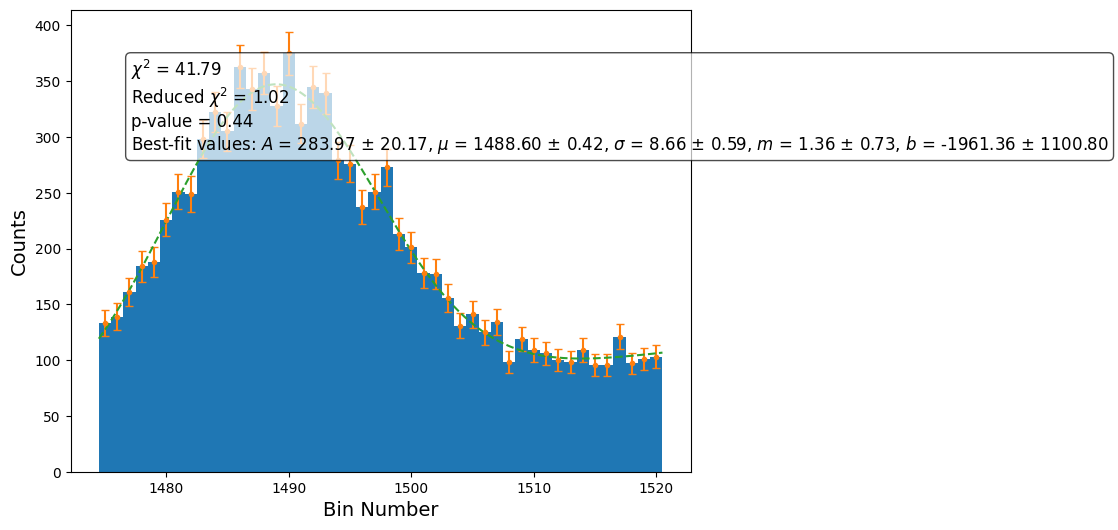

In [37]:
# Recording calibration for Bismuth 77 keV KL3 ine
range_beg = 1475
range_end = 1520
data_for_hist = []
for bin_num,counts in enumerate(data):
    if bin_num >= range_beg and bin_num <= range_end:
        try:
            for _ in range(int(counts)):
                data_for_hist.append(bin_num)
        except:
            break
fig, ax = plt.subplots(figsize=(8,6))

bins = np.arange(range_beg - 0.5, range_end + 1.5, 1)
hist_counts,bin_edges = ax.hist(data_for_hist,bins=bins)[:2] 

bin_centers = ((bin_edges[:-1] + bin_edges[1:]) / 2)
hist_uncertainties = [x**(0.5) for x in hist_counts]
ax.errorbar(bin_centers,hist_counts,yerr=hist_uncertainties,fmt = '.',capsize = 3)

initial_guess = [hist_counts.max(),mode(data_for_hist)[0],10, 0,0]
fit_func = gaussian_plus_linear

popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,initial_guess,sigma=hist_uncertainties, absolute_sigma=True)
chi2_value = 0
for index,bin_center in enumerate(bin_centers):
    chi2_value += (fit_func(bin_center, *popt) - hist_counts[index])**2/hist_uncertainties[index]**2
dof = len(hist_counts) - len(popt)
reduced_chi2 = chi2_value/dof
chi2_prob = chi2.cdf(chi2_value, dof)
p_val = 1 - chi2_prob

overplot_x = np.linspace(range_beg-0.5, range_end+0.5, num=200)
overplot_y = fit_func(overplot_x, *popt)

ax.plot(overplot_x, overplot_y, linestyle='--')
fig.text(
    0.2, 0.8,  # position relative to the figure, not just the axis
    generate_text_string(fit_func,popt,pcov,chi2_value,reduced_chi2,p_val),
    ha='left', va='top',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
)
ax.set_xlabel("Bin Number", fontsize=14)
ax.set_ylabel("Counts", fontsize=14)
moseleys_lines[("Bi","KL3")] = (get_ener_at_bin(popt[1],*bi_calib_val), calc_ener_err(bi_calib_val, bi_calib_val_err, pcov,popt,1))
(get_ener_at_bin(popt[1],*bi_calib_val), calc_ener_err(bi_calib_val, bi_calib_val_err, pcov,popt,1))

# Moseley's Law Analysis

## 9-29 Moseley's max gain Barium, rubidium

NameError: name 'GaussianFitter' is not defined

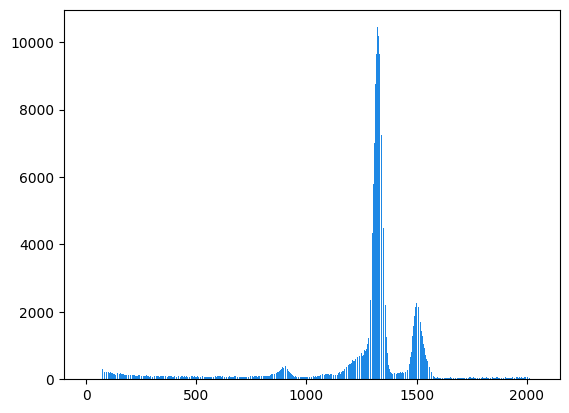

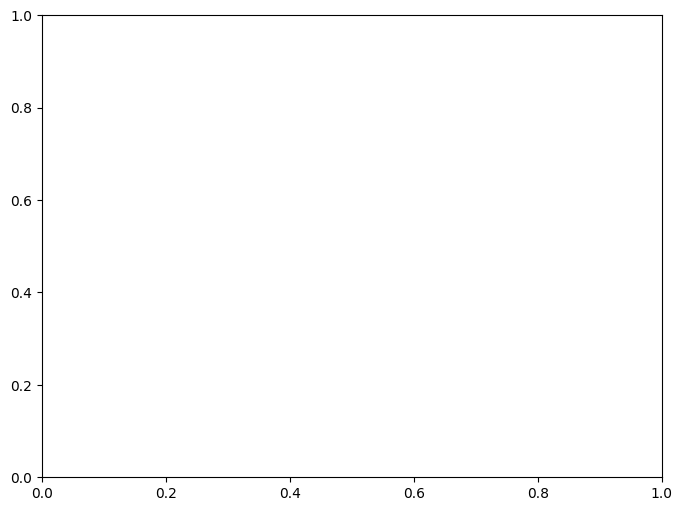

In [38]:
# Code where I made ChatGPT use the GaussianFitter class instead

# lines in this spectra should be at ~31 keV and ~ 35 keV
ba1 = "9_29\\barium_max_gain_calibration_x_ray_spectra_9_29.Spe"
ba1_calib = {}

# CALIBRATING TO 35keV
range_beg = 1486
range_end = 1518
data = np.genfromtxt(ba1, delimiter='\n', skip_header=12)

plt.bar(range(2048),data[:2048], color = '#1E88E5')

data_for_hist = []
for bin_num,counts in enumerate(data):
    if bin_num >= range_beg and bin_num <= range_end:
        try:
            for _ in range(int(counts)):
                data_for_hist.append(bin_num)
        except:
            break
fig, ax = plt.subplots(figsize=(8,6))

# ---- HISTOGRAM CREATION ----
bins = np.arange(range_beg - 0.5, range_end + 1.5, 1)
hist_counts, bin_edges = np.histogram(data_for_hist, bins=bins)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
hist_uncertainties = np.sqrt(hist_counts)
hist_uncertainties[hist_uncertainties == 0] = 1  # prevent div/0

# ---- FITTING ----
fitter = GaussianFitter(bin_centers, hist_counts, hist_uncertainties)
result = fitter.fit()

A, mu, sigma = result['params']
eA, emu, esigma = result['e_params']

# ---- STATS ----
chi2_value = result['chisqr']
reduced_chi2 = result['reduced_chisqr']
p_val = result['alpha']

# ---- PLOT ----
fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(bin_centers, hist_counts, yerr=hist_uncertainties, fmt='o', alpha=0.7)
x_fit, y_fit = fitter.model_interpolation(params=result['params'])
ax.plot(x_fit, y_fit, 'r--', label='Gaussian fit')

# Optional annotation
fit_text = (
    f"A = {A:.2f} ± {eA:.2f}\n"
    f"μ = {mu:.2f} ± {emu:.2f}\n"
    f"σ = {sigma:.2f} ± {esigma:.2f}\n"
    f"χ²/dof = {reduced_chi2:.2f}\n"
    f"p = {p_val:.3f}"
)
fig.text(0.2, 0.8, fit_text, ha='left', va='top', fontsize=12,
         bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7))

# ---- CALIBRATION ----
ba1_calib[30.85] = (mu, emu**2)

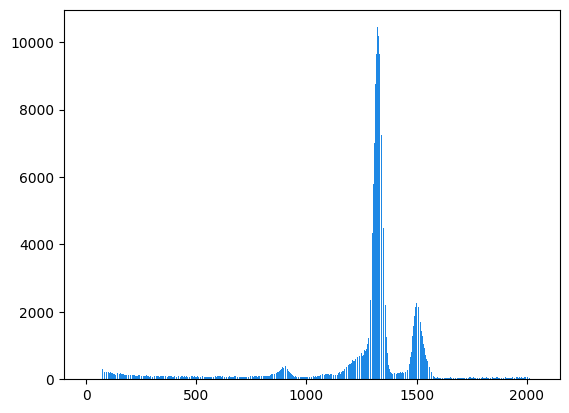

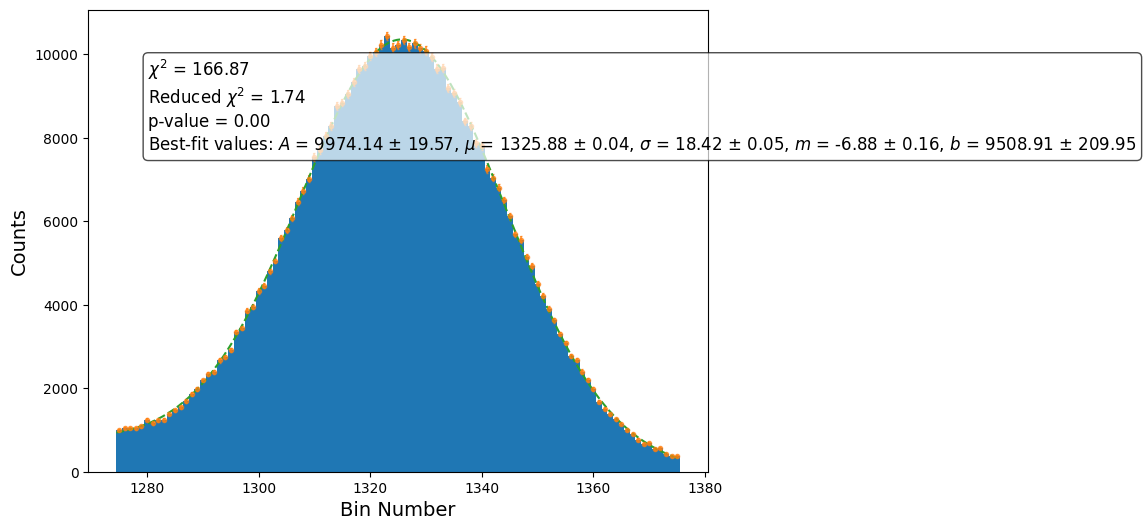

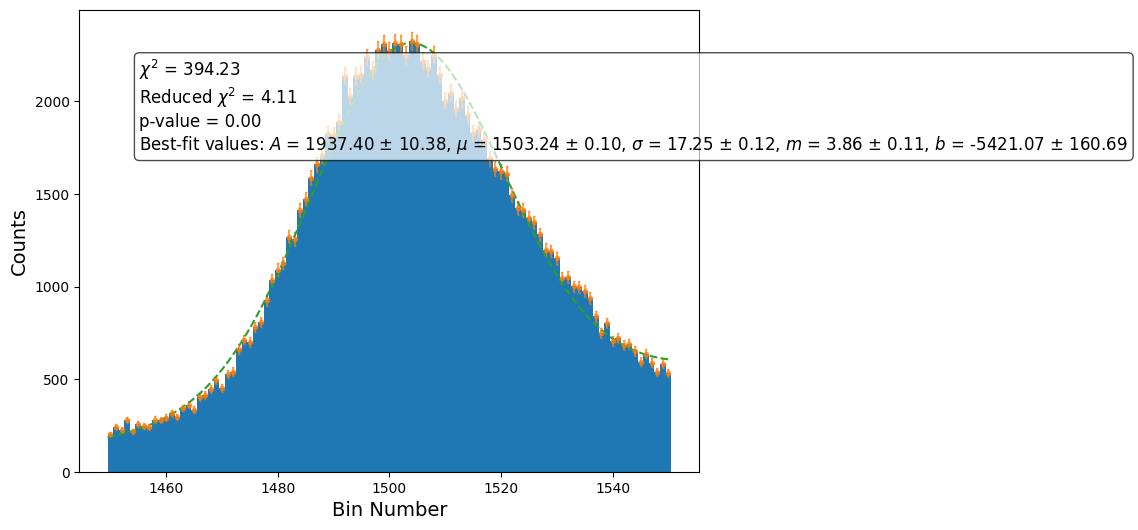

In [ ]:
# lines in this spectra should be at ~31 keV and ~ 35 keV
ba1 = "9_29\\barium_max_gain_calibration_x_ray_spectra_9_29.Spe"
ba1_calib = {}

# CALIBRATING TO 31keV
range_beg = 1275
range_end = 1375
data = np.genfromtxt(ba1, delimiter='\n', skip_header=12)

plt.bar(range(2048),data[:2048], color = '#1E88E5')

data_for_hist = []
for bin_num,counts in enumerate(data):
    if bin_num >= range_beg and bin_num <= range_end:
        try:
            for _ in range(int(counts)):
                data_for_hist.append(bin_num)
        except:
            break
fig, ax = plt.subplots(figsize=(8,6))

bins = np.arange(range_beg - 0.5, range_end + 1.5, 1)
hist_counts,bin_edges = ax.hist(data_for_hist,bins=bins)[:2] 

bin_centers = ((bin_edges[:-1] + bin_edges[1:]) / 2)
hist_uncertainties = [x**(0.5) for x in hist_counts]
ax.errorbar(bin_centers,hist_counts,yerr=hist_uncertainties,fmt = '.',capsize = 1,alpha = 0.7)

# inputting 1 instead of 0 for histogram bins with 0 counts to fix divide by 0 error.
had_to_fix_div_by_zero = False
for i in range(len(hist_uncertainties)):
    if hist_uncertainties[i] == 0:
        hist_uncertainties[i] = 1
        had_to_fix_div_by_zero = True

initial_guess = [hist_counts.max(),mode(data_for_hist)[0],30,0,0]
fit_func = gaussian_plus_linear

popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,initial_guess,sigma=hist_uncertainties, absolute_sigma=True)
if had_to_fix_div_by_zero:
    popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,popt,sigma=[popt[1]**0.5]*len(hist_counts), absolute_sigma=True)
chi2_value = 0
for index,bin_center in enumerate(bin_centers):
    chi2_value += (fit_func(bin_center, *popt) - hist_counts[index])**2/hist_uncertainties[index]**2
dof = len(hist_counts) - len(popt)
reduced_chi2 = chi2_value/dof
chi2_prob = chi2.cdf(chi2_value, dof)
p_val = 1 - chi2_prob

overplot_x = np.linspace(range_beg-0.5, range_end+0.5, num=200)
overplot_y = fit_func(overplot_x, *popt)

ax.plot(overplot_x, overplot_y, linestyle='--')
fig.text(
    0.2, 0.8,  # position relative to the figure, not just the axis
    generate_text_string(fit_func, popt, pcov, chi2_value, reduced_chi2, p_val, precision=2),
    ha='left', va='top',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
)
ax.set_xlabel("Bin Number", fontsize=14)
ax.set_ylabel("Counts", fontsize=14)
ba1_calib[30.85] = (popt[1], pcov[1][1]**0.5)

#--------------------------------------------------------------------------------------------------------------------


# CALIBRATING TO 35keV
range_beg = 1450
range_end = 1550
data_for_hist = []
for bin_num,counts in enumerate(data):
    if bin_num >= range_beg and bin_num <= range_end:
        try:
            for _ in range(int(counts)):
                data_for_hist.append(bin_num)
        except:
            break
fig, ax = plt.subplots(figsize=(8,6))

bins = np.arange(range_beg - 0.5, range_end + 1.5, 1)
hist_counts,bin_edges = ax.hist(data_for_hist,bins=bins)[:2] 

bin_centers = ((bin_edges[:-1] + bin_edges[1:]) / 2)
hist_uncertainties = [x**(0.5) for x in hist_counts]
ax.errorbar(bin_centers,hist_counts,yerr=hist_uncertainties,fmt = '.',capsize = 1,alpha = 0.7)

# inputting 1 instead of 0 for histogram bins with 0 counts to fix divide by 0 error.
had_to_fix_div_by_zero = False
for i in range(len(hist_uncertainties)):
    if hist_uncertainties[i] == 0:
        hist_uncertainties[i] = 1
        had_to_fix_div_by_zero = True

initial_guess = [hist_counts.max(),mode(data_for_hist)[0],10,0,0]
fit_func = gaussian_plus_linear

popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,initial_guess,sigma=hist_uncertainties, absolute_sigma=True)
chi2_value = 0
for index,bin_center in enumerate(bin_centers):
    chi2_value += (fit_func(bin_center, *popt) - hist_counts[index])**2/hist_uncertainties[index]**2
dof = len(hist_counts) - len(popt)
reduced_chi2 = chi2_value/dof
chi2_prob = chi2.cdf(chi2_value, dof)
p_val = 1 - chi2_prob

overplot_x = np.linspace(range_beg-0.5, range_end+0.5, num=200)
overplot_y = fit_func(overplot_x, *popt)

ax.plot(overplot_x, overplot_y, linestyle='--')
fig.text(
    0.2, 0.8,  # position relative to the figure, not just the axis
    generate_text_string(fit_func, popt, pcov, chi2_value, reduced_chi2, p_val, precision=2),
    ha='left', va='top',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
)
ax.set_xlabel("Bin Number", fontsize=14)
ax.set_ylabel("Counts", fontsize=14)

ba1_calib[35.1] = (popt[1], pcov[1][1]**0.5)

C:\Users\megan\AppData\Local\Temp\ipykernel_20572\1915457771.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  reduced_chi2 = chi2_value / dof


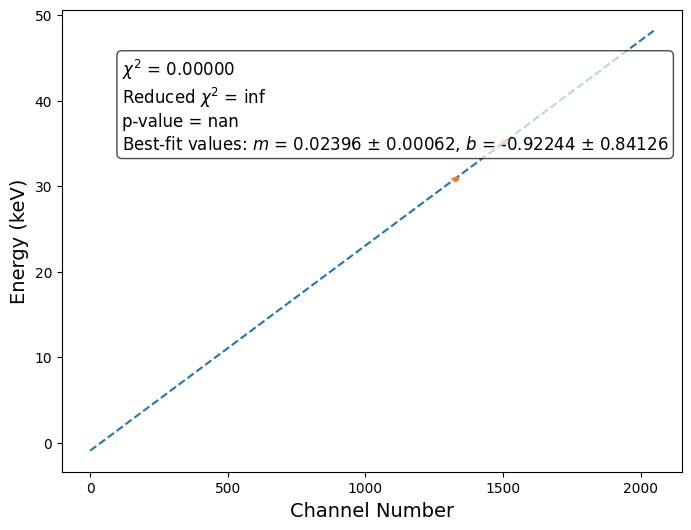

In [ ]:
fit_func = linear
ba1_calib_data_np = np.array([[key,*value] for key,value in ba1_calib.items()])
channel_nums = ba1_calib_data_np[:,1]
energies = ba1_calib_data_np[:,0]
energy_errs = ba1_calib_data_np[:,2]
popt, pcov = curve_fit(fit_func,channel_nums,energies,[0,0],sigma=ba1_calib_data_np[:,2], absolute_sigma=True)

chi2_value = np.sum(((fit_func(channel_nums, *popt) - energies) / energy_errs) ** 2)
dof = len(energies) - len(popt)
reduced_chi2 = chi2_value / dof
chi2_prob = chi2.cdf(chi2_value, dof)
p_val = 1 - chi2_prob

overplot_x = np.linspace(0, 2048, num=200)
overplot_y = linear(overplot_x, *popt)

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(overplot_x, overplot_y, linestyle='--')
ax.errorbar(channel_nums,energies, yerr= ba1_calib_data_np[:,2],fmt = '.', capsize = 3)
ax.set_xlabel("Channel Number", fontsize=14)
ax.set_ylabel("Energy (keV)", fontsize=14)
fig.text(
    0.2, 0.8,  # position relative to the figure, not just the axis
    generate_text_string(fit_func, popt, pcov, chi2_value, reduced_chi2, p_val, precision=5),
    ha='left', va='top',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
)

ba1_calib_val = popt

Text(0, 0.5, 'Counts')

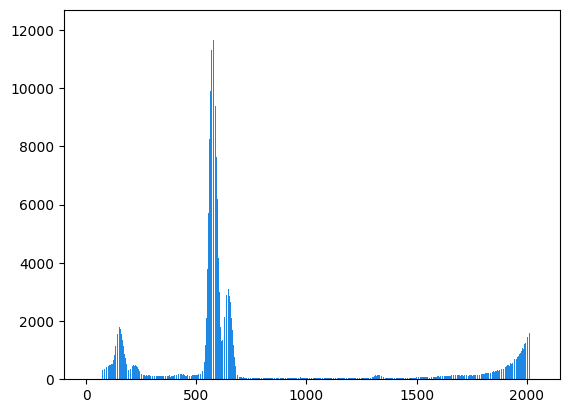

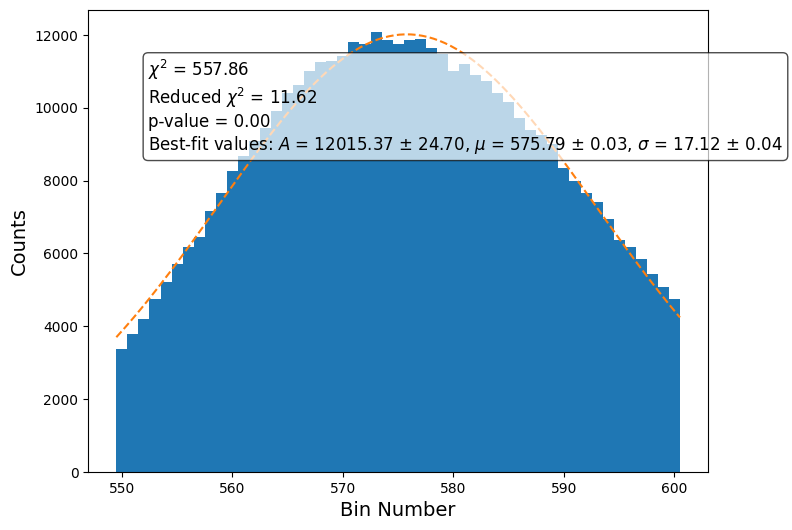

In [ ]:
rb1 = "9_29\\rubidium_x_ray_spectra_9_29.Spe"
data = np.genfromtxt(rb1, delimiter='\n', skip_header=12)
# plt.xlabel("Bin Number", fontsize=14)
# plt.ylabel("Counts", fontsize=14)
plt.bar(range(2048),data[:2048], color = '#1E88E5')

range_beg = 550
range_end = 600
data = np.genfromtxt(rb1, delimiter='\n', skip_header=12)

plt.bar(range(2048),data[:2048], color = '#1E88E5')

data_for_hist = []
for bin_num,counts in enumerate(data):
    if bin_num >= range_beg and bin_num <= range_end:
        try:
            for _ in range(int(counts)):
                data_for_hist.append(bin_num)
        except:
            break
fig, ax = plt.subplots(figsize=(8,6))

bins = np.arange(range_beg - 0.5, range_end + 1.5, 1)
hist_counts,bin_edges = ax.hist(data_for_hist,bins=bins)[:2] 

bin_centers = ((bin_edges[:-1] + bin_edges[1:]) / 2)
hist_uncertainties = [x**(0.5) for x in hist_counts]
# inputting 1 instead of 0 for histogram bins with 0 counts to fix divide by 0 error.
had_to_fix_div_by_zero = False
for i in range(len(hist_uncertainties)):
    if hist_uncertainties[i] == 0:
        hist_uncertainties[i] = 1
        had_to_fix_div_by_zero = True
initial_guess = [hist_counts.max(),mode(data_for_hist)[0],20]

fit_func = gaussian
popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,initial_guess,sigma=hist_uncertainties, absolute_sigma=True)
if had_to_fix_div_by_zero:
    popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,popt,sigma=[popt[1]**0.5]*len(hist_counts), absolute_sigma=True)
chi2_value = 0
for index,bin_center in enumerate(bin_centers):
    chi2_value += (fit_func(bin_center, *popt) - hist_counts[index])**2/hist_uncertainties[index]**2
dof = len(hist_counts) - len(popt)
reduced_chi2 = chi2_value/dof
chi2_prob = chi2.cdf(chi2_value, dof)
p_val = 1 - chi2_prob

overplot_x = np.linspace(range_beg-0.5, range_end+0.5, num=200)
overplot_y = fit_func(overplot_x, *popt)

ax.plot(overplot_x, overplot_y, linestyle='--')
fig.text(
    0.2, 0.8,  # position relative to the figure, not just the axis
    generate_text_string(fit_func,popt,pcov,chi2_value,reduced_chi2,p_val),
    ha='left', va='top',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
)
ax.set_xlabel("Bin Number", fontsize=14)
ax.set_ylabel("Counts", fontsize=14)
#-------------------------------------------------------------------------------------------------------------------

In [ ]:
get_ener_at_bin(575,*ba1_calib_val)

np.float64(12.856421266284233)

## 9-29 Moseley's mid gain terbium, barium, silver

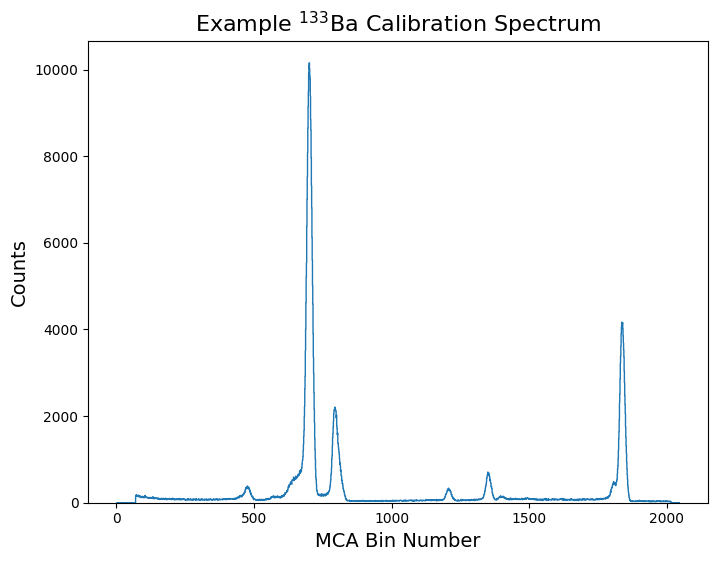

In [ ]:
ba2 = "9_29\\barium_mid_gain_calibration_x_ray_spectra_9_29.Spe"
ba2_calib = {}

data = np.genfromtxt(ba2, delimiter='\n', skip_header=12)

range_beg = 0
range_end = 2048
data_for_hist = []
for bin_num,counts in enumerate(data):
    if bin_num >= range_beg and bin_num <= range_end:
        try:
            for _ in range(int(counts)):
                data_for_hist.append(bin_num)
        except:
            break
fig, ax = plt.subplots(figsize=(8,6))

bins = np.arange(range_beg - 0.5, range_end + 1.5, 1)
hist_counts,bin_edges = ax.hist(data_for_hist,bins=bins,histtype='step')[:2] 

bin_centers = ((bin_edges[:-1] + bin_edges[1:]) / 2)
hist_uncertainties = [x**(0.5) for x in hist_counts]
# plt.errorbar(bin_centers,hist_counts,yerr=hist_uncertainties,fmt = '.',capsize = 3)

# plt.bar(range(2048),data[:2048], color = '#1E88E5')
plt.ylabel("Counts", fontsize = 14)
plt.xlabel("MCA Bin Number",fontsize = 14)
plt.title(r"Example $^{133}$Ba Calibration Spectrum", fontsize=16)
plt.savefig("example_133_ba_calibration_spectrum.png")

In [ ]:
# # Finding optimal range for 133 Barium, 31 keV peak
# # Candidate fit ranges (tuples of (start, end))
# candidate_ranges = generate_candidate_ranges(670, 720,bound = 10, step_size= 3)
# # Candidate models and their initial guesses
# candidate_models = [
#     (gaussian, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10]),
#     (gaussian_plus_linear, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10, 0, 0]),
#     (gaussian_plus_constant, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10, 0])
# ]

# results = []

# for fit_range in candidate_ranges:
#     # Prepare histogram for this range
#     data_for_hist = []
#     for bin_num, counts in enumerate(data):
#         if fit_range[0] <= bin_num <= fit_range[1]:
#             try:
#                 for _ in range(int(counts)):
#                     data_for_hist.append(bin_num)
#             except Exception:
#                 break
#     bins = np.arange(fit_range[0] - 0.5, fit_range[1] + 1.5, 1)
#     hist_counts, bin_edges = np.histogram(data_for_hist, bins=bins)
#     bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

#     for model_func, guess_func in candidate_models:
#         try:
#             initial_guess = guess_func(hist_counts, bin_centers)
#             fit_result = fit_peak_with_residuals(
#                 data=data,
#                 range_beg=fit_range[0],
#                 range_end=fit_range[1],
#                 fit_func=model_func,
#                 initial_guess=initial_guess,
#                 xlabel="Bin Number",
#                 ylabel="Counts",
#                 title=f"Range {fit_range}, Model {model_func.__name__}",
#                 annotate_fit=False  # We'll annotate only the best fit
#             )
#             results.append({
#                 "range": fit_range,
#                 "model": model_func.__name__,
#                 "fit_result": fit_result
#             })
#         except Exception as e:
#             print(f"Fit failed for range {fit_range} and model {model_func.__name__}: {e}")

# # Select the best fit (lowest reduced chi²)
# best = min(results, key=lambda r: r["fit_result"]["reduced_chi2"])
# print(f"Best fit: Range {best['range']}, Model {best['model']}, Reduced chi² = {best['fit_result']['reduced_chi2']:.2f}")

# # Plot the best fit with annotation
# results = fit_peak_with_residuals(
#     data=data,
#     range_beg=best["range"][0],
#     range_end=best["range"][1],
#     fit_func=eval(best["model"]),
#     initial_guess=best["fit_result"]["popt"],
#     xlabel="Bin Number",
#     ylabel="Counts",
#     title=f"Best Fit: Range {best['range']}, Model {best['model']}",
#     annotate_fit=True,
#     display_plot = True
# )
# popt = results["popt"]

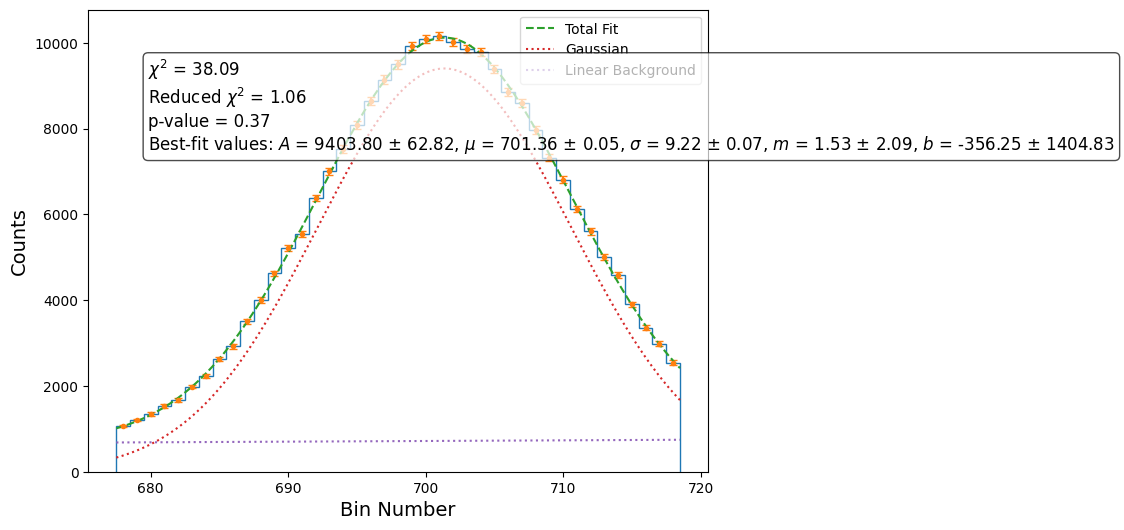

In [ ]:
# Recording optimal fit for 133 Barium, 31 keV peak
range_beg = 678
range_end = 718

data_for_hist = []
for bin_num,counts in enumerate(data):
    if bin_num >= range_beg and bin_num <= range_end:
        try:
            for _ in range(int(counts)):
                data_for_hist.append(bin_num)
        except:
            break
fig, ax = plt.subplots(figsize=(8,6))

bins = np.arange(range_beg - 0.5, range_end + 1.5, 1)
hist_counts,bin_edges = ax.hist(data_for_hist,bins=bins,histtype='step')[:2] 

bin_centers = ((bin_edges[:-1] + bin_edges[1:]) / 2)
hist_uncertainties = [x**(0.5) for x in hist_counts]
ax.errorbar(bin_centers,hist_counts,yerr=hist_uncertainties,fmt = '.',capsize = 3)

initial_guess =[hist_counts.max(),mode(data_for_hist)[0],10,  0,0]
fit_func = gaussian_plus_linear

popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,initial_guess,sigma=hist_uncertainties, absolute_sigma=True)

chi2_value = 0
for index,bin_center in enumerate(bin_centers):
    chi2_value += (fit_func(bin_center, *popt) - hist_counts[index])**2/hist_uncertainties[index]**2
dof = len(hist_counts) - len(popt)
reduced_chi2 = chi2_value/dof
chi2_prob = chi2.cdf(chi2_value, dof)
p_val = 1 - chi2_prob

overplot_x = np.linspace(range_beg-0.5, range_end+0.5, num=200)
overplot_y = fit_func(overplot_x, *popt)

# Overplot total fit
ax.plot(overplot_x, overplot_y, linestyle='--', label='Total Fit')

# Overplot gaussian and linear background separately
gauss = popt[0] * np.exp(-0.5 * ((overplot_x - popt[1]) / popt[2]) ** 2)
linear_bg = popt[3] * overplot_x + popt[4]
ax.plot(overplot_x, gauss, linestyle=':', label='Gaussian')
ax.plot(overplot_x, linear_bg, linestyle=':', label='Linear Background')
ax.legend()

fig.text(
    0.2, 0.8,  # position relative to the figure, not just the axis
    generate_text_string(fit_func,popt,pcov,chi2_value,reduced_chi2,p_val),
    ha='left', va='top',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
)
ax.set_xlabel("Bin Number", fontsize=14)
ax.set_ylabel("Counts", fontsize=14)

ba2_calib[30.85] = (popt[1], np.sqrt(pcov[1][1]))

Best fit: Range (785, 810), Model gaussian_plus_linear, Reduced chi² = 1.08


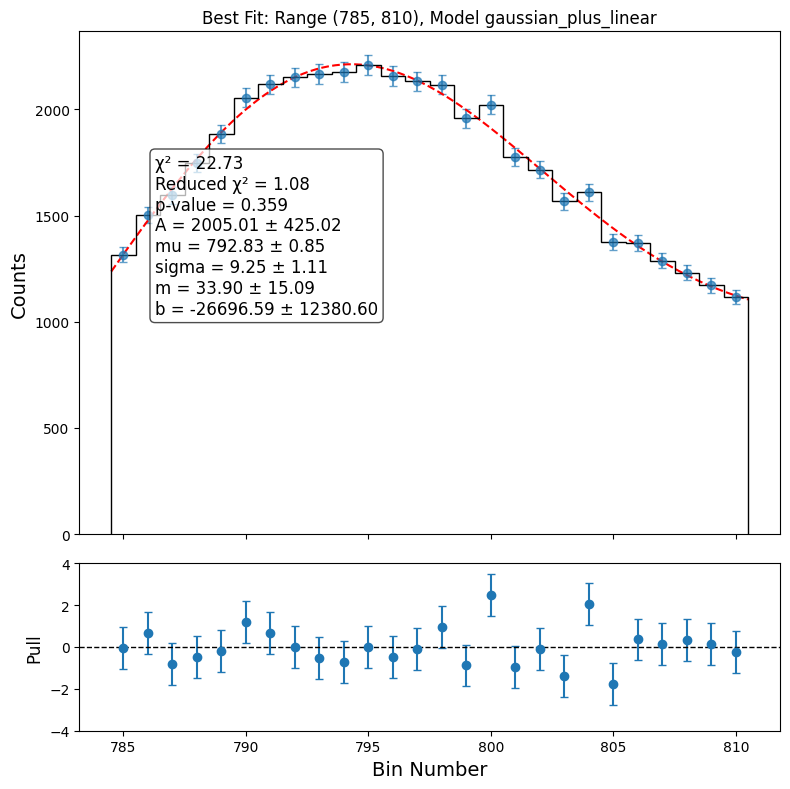

In [ ]:
# Finding optimal range for 133 Barium, 35 keV peak
# Candidate fit ranges (tuples of (start, end))
candidate_ranges = generate_candidate_ranges(777, 820,bound = 10, step_size= 3)
# Candidate models and their initial guesses
candidate_models = [
    (gaussian, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10]),
    (gaussian_plus_linear, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10, 0, 0]),
    (gaussian_plus_constant, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10, 0])
]

results = []

for fit_range in candidate_ranges:
    # Prepare histogram for this range
    data_for_hist = []
    for bin_num, counts in enumerate(data):
        if fit_range[0] <= bin_num <= fit_range[1]:
            try:
                for _ in range(int(counts)):
                    data_for_hist.append(bin_num)
            except Exception:
                break
    bins = np.arange(fit_range[0] - 0.5, fit_range[1] + 1.5, 1)
    hist_counts, bin_edges = np.histogram(data_for_hist, bins=bins)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    for model_func, guess_func in candidate_models:
        try:
            initial_guess = guess_func(hist_counts, bin_centers)
            fit_result = fit_peak_with_residuals(
                data=data,
                range_beg=fit_range[0],
                range_end=fit_range[1],
                fit_func=model_func,
                initial_guess=initial_guess,
                xlabel="Bin Number",
                ylabel="Counts",
                title=f"Range {fit_range}, Model {model_func.__name__}",
                annotate_fit=False  # We'll annotate only the best fit
            )
            results.append({
                "range": fit_range,
                "model": model_func.__name__,
                "fit_result": fit_result
            })
        except Exception as e:
            print(f"Fit failed for range {fit_range} and model {model_func.__name__}: {e}")

# Select the best fit (lowest reduced chi²)
best = min(results, key=lambda r: r["fit_result"]["reduced_chi2"])
print(f"Best fit: Range {best['range']}, Model {best['model']}, Reduced chi² = {best['fit_result']['reduced_chi2']:.2f}")

# Plot the best fit with annotation
results = fit_peak_with_residuals(
    data=data,
    range_beg=best["range"][0],
    range_end=best["range"][1],
    fit_func=eval(best["model"]),
    initial_guess=best["fit_result"]["popt"],
    xlabel="Bin Number",
    ylabel="Counts",
    title=f"Best Fit: Range {best['range']}, Model {best['model']}",
    annotate_fit=True,
    display_plot = True
)
popt = results["popt"]

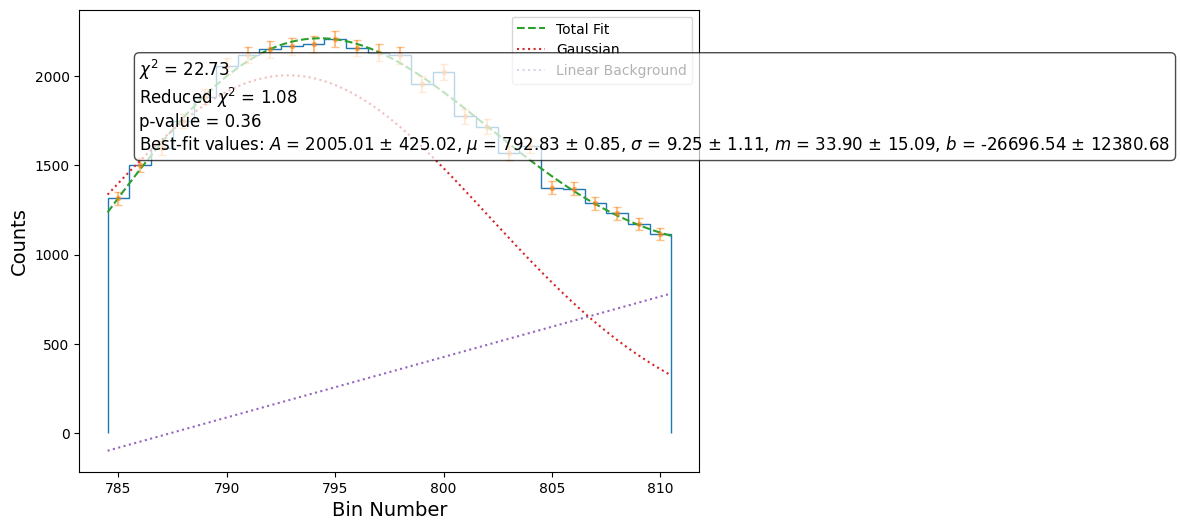

In [ ]:
# Recording optimal fit for 133 Barium, 35 keV peak
range_beg = 785
range_end = 810
data_for_hist = []
for bin_num,counts in enumerate(data):
    if bin_num >= range_beg and bin_num <= range_end:
        try:
            for _ in range(int(counts)):
                data_for_hist.append(bin_num)
        except:
            break
fig, ax = plt.subplots(figsize=(8,6))

bins = np.arange(range_beg - 0.5, range_end + 1.5, 1)
hist_counts,bin_edges = ax.hist(data_for_hist,bins=bins,histtype = 'step')[:2] 

bin_centers = ((bin_edges[:-1] + bin_edges[1:]) / 2)
hist_uncertainties = [x**(0.5) for x in hist_counts]

ax.errorbar(bin_centers, hist_counts, yerr=hist_uncertainties, fmt = '.', capsize = 3, alpha = 0.5)

initial_guess = [hist_counts.max(),mode(data_for_hist)[0],10,   0,0]
fit_func = gaussian_plus_linear

popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,initial_guess,sigma=hist_uncertainties, absolute_sigma=True)
chi2_value = 0
for index,bin_center in enumerate(bin_centers):
    chi2_value += (fit_func(bin_center, *popt) - hist_counts[index])**2/hist_uncertainties[index]**2
dof = len(hist_counts) - len(popt)
reduced_chi2 = chi2_value/dof
chi2_prob = chi2.cdf(chi2_value, dof)
p_val = 1 - chi2_prob

overplot_x = np.linspace(range_beg-0.5, range_end+0.5, num=200)
overplot_y = fit_func(overplot_x, *popt)

# Overplot total fit
ax.plot(overplot_x, overplot_y, linestyle='--', label='Total Fit')

# Overplot gaussian and linear background separately
gauss = popt[0] * np.exp(-0.5 * ((overplot_x - popt[1]) / popt[2]) ** 2)
linear_bg = popt[3] * overplot_x + popt[4]
ax.plot(overplot_x, gauss, linestyle=':', label='Gaussian')
ax.plot(overplot_x, linear_bg, linestyle=':', label='Linear Background')
ax.legend()

fig.text(
    0.2, 0.8,  # position relative to the figure, not just the axis
    generate_text_string(fit_func,popt,pcov,chi2_value,reduced_chi2,p_val),
    ha='left', va='top',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
)
ax.set_xlabel("Bin Number", fontsize=14)
ax.set_ylabel("Counts", fontsize=14)
ba2_calib[34.9869] = (popt[1], pcov[1][1]**0.5)

Best fit: Range (1823, 1855), Model gaussian_plus_linear, Reduced chi² = 0.98


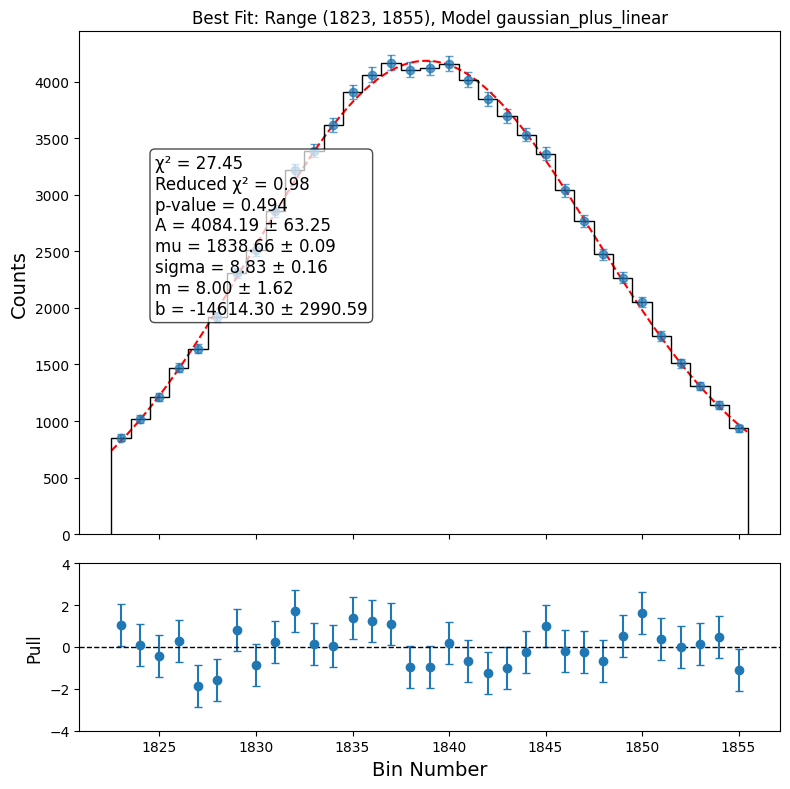

In [ ]:
# Finding optimal range for 133 Barium, 81 keV peak
# Candidate fit ranges (tuples of (start, end))
candidate_ranges = generate_candidate_ranges(1815, 1865,bound = 10, step_size= 3)
# Candidate models and their initial guesses
candidate_models = [
    (gaussian, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10]),
    (gaussian_plus_linear, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10, 0, 0]),
    (gaussian_plus_constant, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10, 0])
]

results = []

for fit_range in candidate_ranges:
    # Prepare histogram for this range
    data_for_hist = []
    for bin_num, counts in enumerate(data):
        if fit_range[0] <= bin_num <= fit_range[1]:
            try:
                for _ in range(int(counts)):
                    data_for_hist.append(bin_num)
            except Exception:
                break
    bins = np.arange(fit_range[0] - 0.5, fit_range[1] + 1.5, 1)
    hist_counts, bin_edges = np.histogram(data_for_hist, bins=bins)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    for model_func, guess_func in candidate_models:
        try:
            initial_guess = guess_func(hist_counts, bin_centers)
            fit_result = fit_peak_with_residuals(
                data=data,
                range_beg=fit_range[0],
                range_end=fit_range[1],
                fit_func=model_func,
                initial_guess=initial_guess,
                xlabel="Bin Number",
                ylabel="Counts",
                title=f"Range {fit_range}, Model {model_func.__name__}",
                annotate_fit=False  # We'll annotate only the best fit
            )
            results.append({
                "range": fit_range,
                "model": model_func.__name__,
                "fit_result": fit_result
            })
        except Exception as e:
            print(f"Fit failed for range {fit_range} and model {model_func.__name__}: {e}")

# Select the best fit (lowest reduced chi²)
best = min(results, key=lambda r: r["fit_result"]["reduced_chi2"])
print(f"Best fit: Range {best['range']}, Model {best['model']}, Reduced chi² = {best['fit_result']['reduced_chi2']:.2f}")

# Plot the best fit with annotation
results = fit_peak_with_residuals(
    data=data,
    range_beg=best["range"][0],
    range_end=best["range"][1],
    fit_func=eval(best["model"]),
    initial_guess=best["fit_result"]["popt"],
    xlabel="Bin Number",
    ylabel="Counts",
    title=f"Best Fit: Range {best['range']}, Model {best['model']}",
    annotate_fit=True,
    display_plot = True
)
popt = results["popt"]

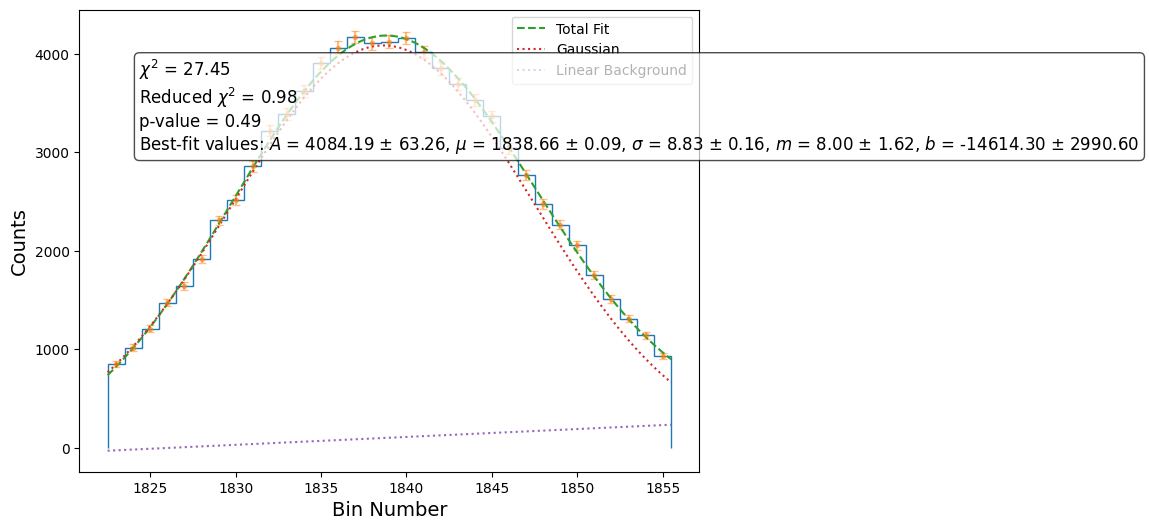

In [ ]:
# Recording optimal fit for 133 Barium, 81 keV peak
range_beg = 1823
range_end = 1855
data_for_hist = []
for bin_num,counts in enumerate(data):
    if bin_num >= range_beg and bin_num <= range_end:
        try:
            for _ in range(int(counts)):
                data_for_hist.append(bin_num)
        except:
            break
fig, ax = plt.subplots(figsize=(8,6))

bins = np.arange(range_beg - 0.5, range_end + 1.5, 1)
hist_counts,bin_edges = ax.hist(data_for_hist,bins=bins, histtype='step')[:2] 

bin_centers = ((bin_edges[:-1] + bin_edges[1:]) / 2)
hist_uncertainties = [x**(0.5) for x in hist_counts]
# inputting 1 instead of 0 for histogram bins with 0 counts to fix divide by 0 error.
had_to_fix_div_by_zero = False
for i in range(len(hist_uncertainties)):
    if hist_uncertainties[i] == 0:
        hist_uncertainties[i] = 1
        had_to_fix_div_by_zero = True
ax.errorbar(bin_centers, hist_counts, yerr=hist_uncertainties, fmt = '.', capsize = 3, alpha = 0.5)

# initial_guess = [hist_counts.max(),mode(data_for_hist)[0],10,400,1800,15]
# fit_func = two_gaussians

initial_guess = [hist_counts.max(),mode(data_for_hist)[0],10,0,0]
fit_func = gaussian_plus_linear

popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,initial_guess,sigma=hist_uncertainties, absolute_sigma=True)
chi2_value = 0
for index,bin_center in enumerate(bin_centers):
    chi2_value += (fit_func(bin_center, *popt) - hist_counts[index])**2/hist_uncertainties[index]**2
dof = len(hist_counts) - len(popt)
reduced_chi2 = chi2_value/dof
chi2_prob = chi2.cdf(chi2_value, dof)
p_val = 1 - chi2_prob


overplot_x = np.linspace(range_beg-0.5, range_end+0.5, num=200)
overplot_y = fit_func(overplot_x, *popt)

# Overplot total fit
ax.plot(overplot_x, overplot_y, linestyle='--', label='Total Fit')

# Overplot gaussian and linear background separately
gauss = popt[0] * np.exp(-0.5 * ((overplot_x - popt[1]) / popt[2]) ** 2)
linear_bg = popt[3] * overplot_x + popt[4]
ax.plot(overplot_x, gauss, linestyle=':', label='Gaussian')
ax.plot(overplot_x, linear_bg, linestyle=':', label='Linear Background')
ax.legend()

fig.text(
    0.2, 0.8,  # position relative to the figure, not just the axis
    generate_text_string(fit_func,popt,pcov,chi2_value,reduced_chi2,p_val),
    ha='left', va='top',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
)
ax.set_xlabel("Bin Number", fontsize=14)
ax.set_ylabel("Counts", fontsize=14)
ba2_calib[81] = (popt[1], pcov[1][1]**0.5)

<BarContainer object of 2048 artists>

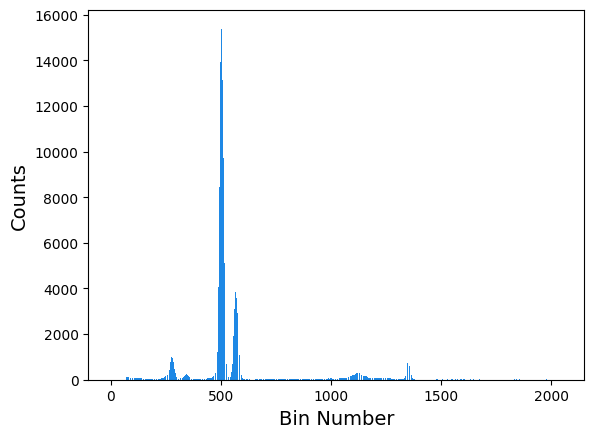

In [ ]:
ag1 = "9_29\\ag_x_ray_spectra_2_9_29.Spe"
data = np.genfromtxt(ag1, delimiter='\n', skip_header=12)
plt.xlabel("Bin Number", fontsize=14)
plt.ylabel("Counts", fontsize=14)
plt.bar(range(2048),data[:2048], color = '#1E88E5')

In [ ]:
# # Finding optimal range for 59.5 keV line Americium gamma ray
# # Candidate fit ranges (tuples of (start, end))
# candidate_ranges = generate_candidate_ranges(1330, 1375,bound = 10, step_size= 3)
# # Candidate models and their initial guesses
# candidate_models = [
#     (gaussian, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10]),
#     (gaussian_plus_linear, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10, 0, 0]),
#     (gaussian_plus_constant, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10, 0])
# ]

# results = []

# for fit_range in candidate_ranges:
#     # Prepare histogram for this range
#     data_for_hist = []
#     for bin_num, counts in enumerate(data):
#         if fit_range[0] <= bin_num <= fit_range[1]:
#             try:
#                 for _ in range(int(counts)):
#                     data_for_hist.append(bin_num)
#             except Exception:
#                 break
#     bins = np.arange(fit_range[0] - 0.5, fit_range[1] + 1.5, 1)
#     hist_counts, bin_edges = np.histogram(data_for_hist, bins=bins)
#     bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

#     for model_func, guess_func in candidate_models:
#         try:
#             initial_guess = guess_func(hist_counts, bin_centers)
#             fit_result = fit_peak_with_residuals(
#                 data=data,
#                 range_beg=fit_range[0],
#                 range_end=fit_range[1],
#                 fit_func=model_func,
#                 initial_guess=initial_guess,
#                 xlabel="Bin Number",
#                 ylabel="Counts",
#                 title=f"Range {fit_range}, Model {model_func.__name__}",
#                 annotate_fit=False  # We'll annotate only the best fit
#             )
#             results.append({
#                 "range": fit_range,
#                 "model": model_func.__name__,
#                 "fit_result": fit_result
#             })
#         except Exception as e:
#             print(f"Fit failed for range {fit_range} and model {model_func.__name__}: {e}")

# # Select the best fit (lowest reduced chi²)
# best = min(results, key=lambda r: r["fit_result"]["reduced_chi2"])
# print(f"Best fit: Range {best['range']}, Model {best['model']}, Reduced chi² = {best['fit_result']['reduced_chi2']:.2f}")

# # Plot the best fit with annotation
# results = fit_peak_with_residuals(
#     data=data,
#     range_beg=best["range"][0],
#     range_end=best["range"][1],
#     fit_func=eval(best["model"]),
#     initial_guess=best["fit_result"]["popt"],
#     xlabel="Bin Number",
#     ylabel="Counts",
#     title=f"Best Fit: Range {best['range']}, Model {best['model']}",
#     annotate_fit=True,
#     display_plot = True
# )
# popt = results["popt"]

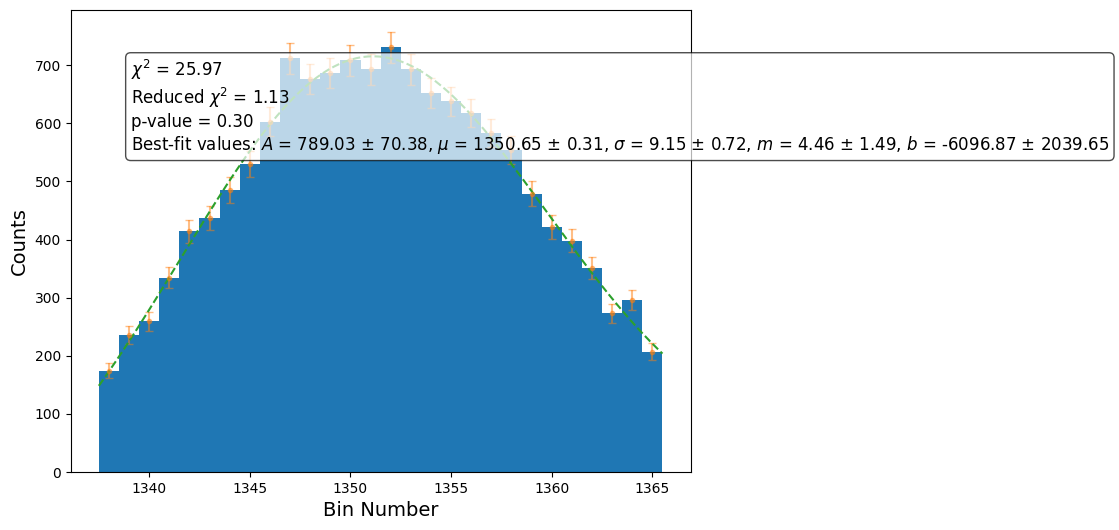

In [ ]:
# Recording 59.5 keV line Americium gamma ray
range_beg = 1338
range_end = 1365
data_for_hist = []
for bin_num,counts in enumerate(data):
    if bin_num >= range_beg and bin_num <= range_end:
        try:
            for _ in range(int(counts)):
                data_for_hist.append(bin_num)
        except:
            break
fig, ax = plt.subplots(figsize=(8,6))

bins = np.arange(range_beg - 0.5, range_end + 1.5, 1)
hist_counts,bin_edges = ax.hist(data_for_hist,bins=bins)[:2] 

bin_centers = ((bin_edges[:-1] + bin_edges[1:]) / 2)
hist_uncertainties = [x**(0.5) for x in hist_counts]
# inputting 1 instead of 0 for histogram bins with 0 counts to fix divide by 0 error.
had_to_fix_div_by_zero = False
for i in range(len(hist_uncertainties)):
    if hist_uncertainties[i] == 0:
        hist_uncertainties[i] = 1
        had_to_fix_div_by_zero = True
ax.errorbar(bin_centers, hist_counts, yerr=hist_uncertainties, fmt = '.', capsize = 3, alpha = 0.5)

initial_guess = [hist_counts.max(),mode(data_for_hist)[0],10, 0,0]
fit_func = gaussian_plus_linear

popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,initial_guess,sigma=hist_uncertainties, absolute_sigma=True)
if had_to_fix_div_by_zero:
    popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,popt,sigma=[popt[1]**0.5]*len(hist_counts), absolute_sigma=True)
chi2_value = 0
for index,bin_center in enumerate(bin_centers):
    chi2_value += (fit_func(bin_center, *popt) - hist_counts[index])**2/hist_uncertainties[index]**2
dof = len(hist_counts) - len(popt)
reduced_chi2 = chi2_value/dof
chi2_prob = chi2.cdf(chi2_value, dof)
p_val = 1 - chi2_prob

overplot_x = np.linspace(range_beg-0.5, range_end+0.5, num=200)
overplot_y = fit_func(overplot_x, *popt)

ax.plot(overplot_x, overplot_y, linestyle='--')
fig.text(
    0.2, 0.8,  # position relative to the figure, not just the axis
    generate_text_string(fit_func,popt,pcov,chi2_value,reduced_chi2,p_val),
    ha='left', va='top',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
)
ax.set_xlabel("Bin Number", fontsize=14)
ax.set_ylabel("Counts", fontsize=14)
ba2_calib[59.5] = (popt[1], pcov[1][1]**0.5)

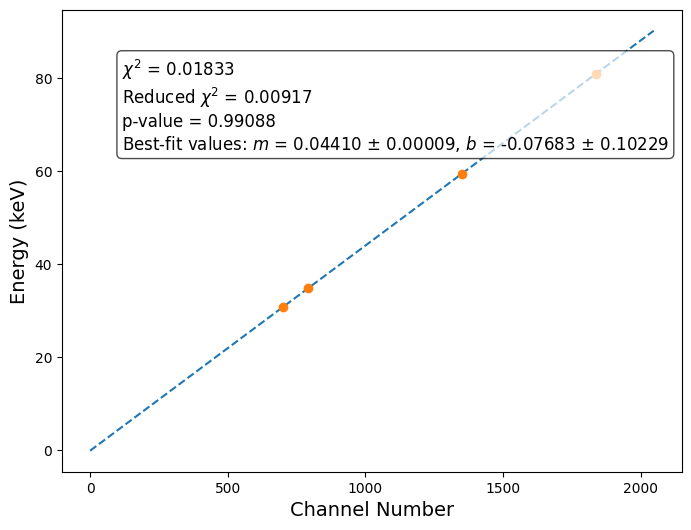

In [ ]:
# Getting linear fit for calibration
fit_func = linear
ba2_calib_data_np = np.array([[key,*value] for key,value in ba2_calib.items()])
channel_nums = ba2_calib_data_np[:,1]
energies = ba2_calib_data_np[:,0]
energy_errs = ba2_calib_data_np[:,2]

popt, pcov = curve_fit(fit_func,channel_nums,energies,[0,0],sigma=ba2_calib_data_np[:,2], absolute_sigma=True)

chi2_value = np.sum(((fit_func(channel_nums, *popt) - energies) / energy_errs) ** 2)
dof = len(energies) - len(popt)
reduced_chi2 = chi2_value / dof
chi2_prob = chi2.cdf(chi2_value, dof)
p_val = 1 - chi2_prob


overplot_x = np.linspace(0, 2048, num=200)
overplot_y = linear(overplot_x, *popt)

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(overplot_x, overplot_y, linestyle='--')
ax.errorbar(channel_nums,energies, yerr = ba2_calib_data_np[:,2],fmt = 'o')
ax.set_xlabel("Channel Number", fontsize=14)
ax.set_ylabel("Energy (keV)", fontsize=14)
fig.text(
    0.2, 0.8,  # position relative to the figure, not just the axis
    generate_text_string(fit_func,popt,pcov,chi2_value,reduced_chi2,p_val,precision = 5),
    ha='left', va='top',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
)

ba2_calib_val = popt
ba2_calib_val_err = [pcov[0][0]**0.5, pcov[1][1]**0.5, pcov[0,1]]

<BarContainer object of 2048 artists>

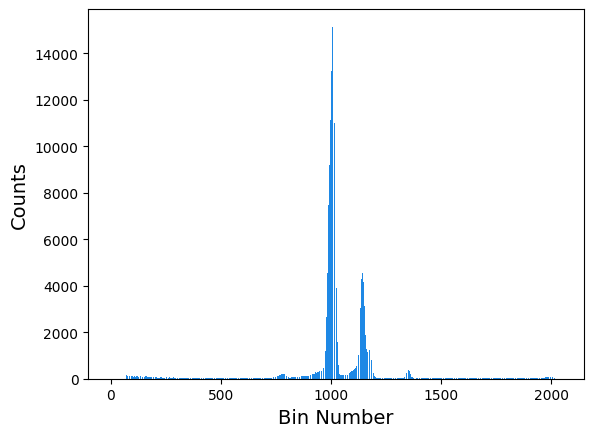

In [ ]:
tb1 = "9_29\\terbium_x_ray_spectra_9_29.Spe"
data = np.genfromtxt(tb1, delimiter='\n', skip_header=12)


plt.xlabel("Bin Number", fontsize=14)
plt.ylabel("Counts", fontsize=14)
plt.bar(range(2048),data[:2048], color = '#1E88E5')

In [ ]:
# # Finding optimal range for Tb KL2 and KL3 lines at 44 keV
# # Candidate fit ranges (tuples of (start, end))
# candidate_ranges = generate_candidate_ranges(970, 1030,bound = 10, step_size= 3)
# # Candidate models and their initial guesses
# candidate_models = [
#     # (gaussian, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10]),
#     # (gaussian_plus_linear, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10, 0, 0]),
#     # (gaussian_plus_constant, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10, 0]),
#     (two_gaussians, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10, max(counts)/2, bins[np.argmax(counts)]+15, 10]),
#     (two_gaussians_plus_linear, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10, max(counts)/2, bins[np.argmax(counts)]+15, 10, 0,0])
# ]

# results = []

# for fit_range in candidate_ranges:
#     # Prepare histogram for this range
#     data_for_hist = []
#     for bin_num, counts in enumerate(data):
#         if fit_range[0] <= bin_num <= fit_range[1]:
#             try:
#                 for _ in range(int(counts)):
#                     data_for_hist.append(bin_num)
#             except Exception:
#                 break
#     bins = np.arange(fit_range[0] - 0.5, fit_range[1] + 1.5, 1)
#     hist_counts, bin_edges = np.histogram(data_for_hist, bins=bins)
#     bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

#     for model_func, guess_func in candidate_models:
#         try:
#             initial_guess = guess_func(hist_counts, bin_centers)
#             fit_result = fit_peak_with_residuals(
#                 data=data,
#                 range_beg=fit_range[0],
#                 range_end=fit_range[1],
#                 fit_func=model_func,
#                 initial_guess=initial_guess,
#                 xlabel="Bin Number",
#                 ylabel="Counts",
#                 title=f"Range {fit_range}, Model {model_func.__name__}",
#                 annotate_fit=False  # We'll annotate only the best fit
#             )
#             results.append({
#                 "range": fit_range,
#                 "model": model_func.__name__,
#                 "fit_result": fit_result
#             })
#         except Exception as e:
#             print(f"Fit failed for range {fit_range} and model {model_func.__name__}: {e}")

# # Select the best fit (lowest reduced chi²)
# best = min(results, key=lambda r: r["fit_result"]["reduced_chi2"])
# print(f"Best fit: Range {best['range']}, Model {best['model']}, Reduced chi² = {best['fit_result']['reduced_chi2']:.2f}")

# # Plot the best fit with annotation
# results = fit_peak_with_residuals(
#     data=data,
#     range_beg=best["range"][0],
#     range_end=best["range"][1],
#     fit_func=eval(best["model"]),
#     initial_guess=best["fit_result"]["popt"],
#     xlabel="Bin Number",
#     ylabel="Counts",
#     title=f"Best Fit: Range {best['range']}, Model {best['model']}",
#     annotate_fit=True,
#     display_plot = True
# )

# popt = results["popt"]

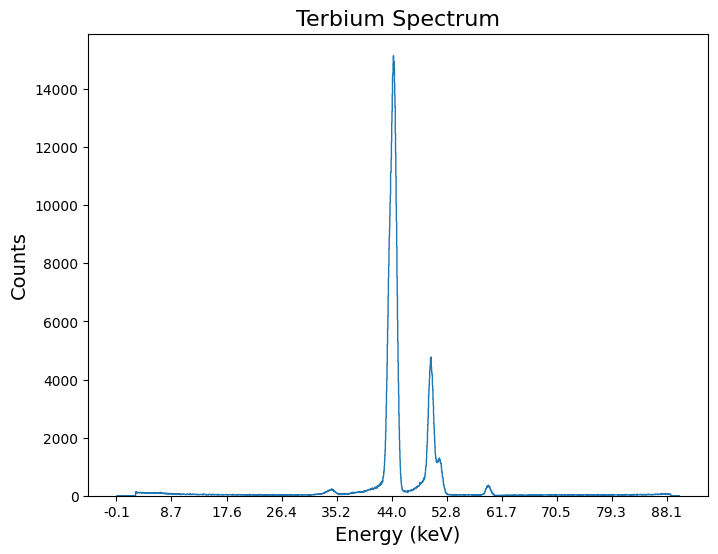

In [ ]:
range_beg = 0
range_end = 2048
data_for_hist = []
for bin_num,counts in enumerate(data):
    if bin_num >= range_beg and bin_num <= range_end:
        try:
            for _ in range(int(counts)):
                data_for_hist.append(bin_num)
        except:
            break
fig, ax = plt.subplots(figsize=(8,6))

bins = np.arange(range_beg - 0.5, range_end + 1.5, 1)
hist_counts,bin_edges = ax.hist(data_for_hist,bins=bins,histtype = 'step')[:2] 

bin_centers = ((bin_edges[:-1] + bin_edges[1:]) / 2)
hist_uncertainties = [x**(0.5) for x in hist_counts]
bin_energies = [get_ener_at_bin(b, *ba2_calib_val) for b in bin_centers]

tick_bins = np.arange(0, 2049, 200)
tick_labels = [f"{get_ener_at_bin(b, *ba2_calib_val):.1f}" for b in tick_bins]
ax.set_xticks(tick_bins)
ax.set_xticklabels(tick_labels)

ax.set_xlabel("Energy (keV)", fontsize=14)
ax.set_ylabel("Counts", fontsize=14)

ax.set_title("Terbium Spectrum", fontsize = 16)

# ax.errorbar(bin_centers, hist_counts, yerr=hist_uncertainties, fmt = '.', capsize = 3, alpha = 0.5)
plt.savefig("terbium_spectrum.png", bbox_inches='tight')

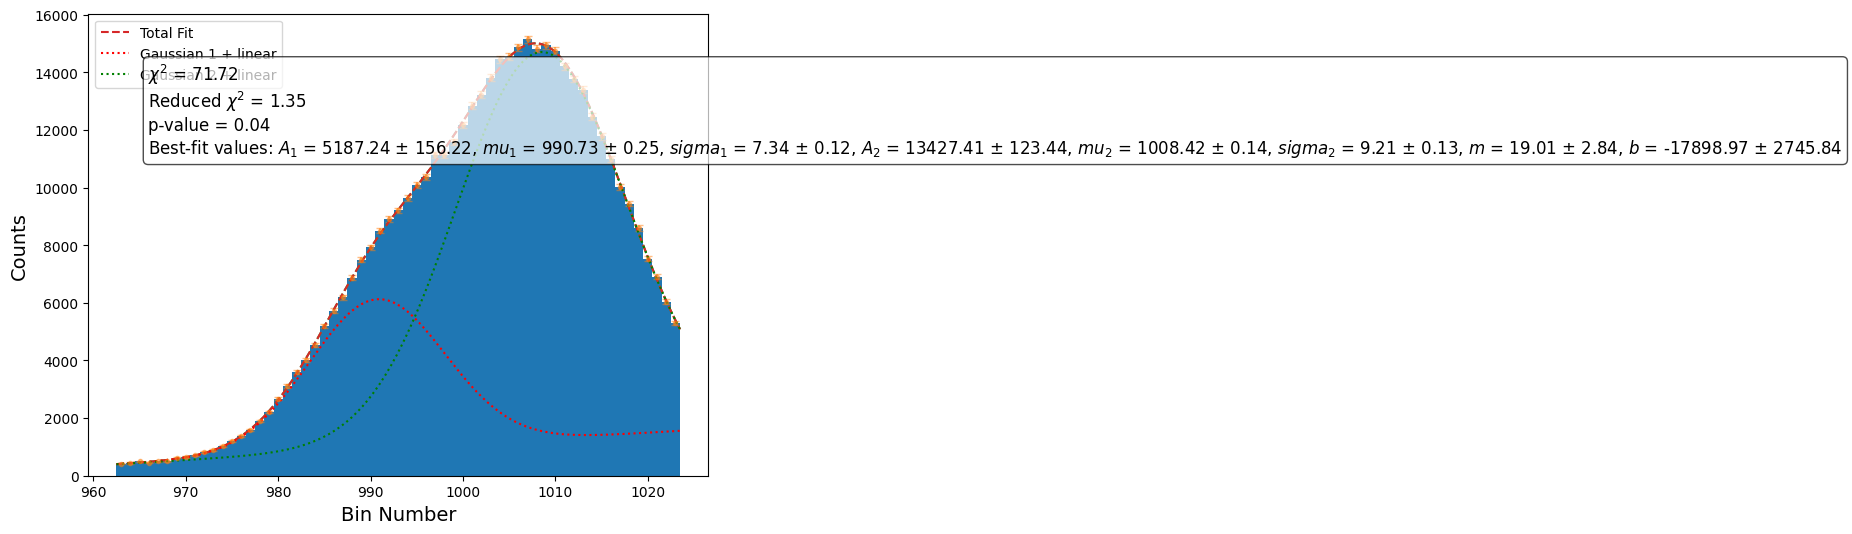

In [ ]:
# Recording Terbium ~44 keV peak, which is in theory two gaussians very close together (KL2 and KL3 lines) at energies 43.74 keV and 44.483 keV    

range_beg = 963
range_end = 1023
data_for_hist = []
for bin_num,counts in enumerate(data):
    if bin_num >= range_beg and bin_num <= range_end:
        try:
            for _ in range(int(counts)):
                data_for_hist.append(bin_num)
        except:
            break
fig, ax = plt.subplots(figsize=(8,6))

bins = np.arange(range_beg - 0.5, range_end + 1.5, 1)
hist_counts,bin_edges = ax.hist(data_for_hist,bins=bins)[:2] 

bin_centers = ((bin_edges[:-1] + bin_edges[1:]) / 2)
hist_uncertainties = [x**(0.5) for x in hist_counts]

ax.errorbar(bin_centers, hist_counts, yerr=hist_uncertainties, fmt = '.', capsize = 3, alpha = 0.5)

initial_guess = [max(hist_counts), bins[np.argmax(hist_counts)], 10, max(hist_counts)/2, bins[np.argmax(hist_counts)]+15, 10, 0,0]
fit_func = two_gaussians_plus_linear

popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,initial_guess,sigma=hist_uncertainties, absolute_sigma=True)

chi2_value = 0
for index,bin_center in enumerate(bin_centers):
    chi2_value += (fit_func(bin_center, *popt) - hist_counts[index])**2/hist_uncertainties[index]**2
dof = len(hist_counts) - len(popt)
reduced_chi2 = chi2_value/dof
chi2_prob = chi2.cdf(chi2_value, dof)
p_val = 1 - chi2_prob

overplot_x = np.linspace(range_beg-0.5, range_end+0.5, num=200)
overplot_y = fit_func(overplot_x, *popt)

ax.plot(overplot_x, overplot_y, linestyle='--')
fig.text(
    0.2, 0.8,  # position relative to the figure, not just the axis
    generate_text_string(fit_func,popt,pcov,chi2_value,reduced_chi2,p_val),
    ha='left', va='top',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
)
ax.set_xlabel("Bin Number", fontsize=14)
ax.set_ylabel("Counts", fontsize=14)

# Individual Gaussians with linear background
linear_bg = popt[6] * overplot_x + popt[7]
gauss1_with_bg = popt[0] * np.exp(-0.5 * ((overplot_x - popt[1]) / popt[2]) ** 2) + linear_bg
gauss2_with_bg = popt[3] * np.exp(-0.5 * ((overplot_x - popt[4]) / popt[5]) ** 2) + linear_bg

ax.plot(overplot_x, overplot_y, linestyle='--', label='Total Fit')
ax.plot(overplot_x, gauss1_with_bg, linestyle=':', color='red', label='Gaussian 1 + linear')
ax.plot(overplot_x, gauss2_with_bg, linestyle=':', color='green', label='Gaussian 2 + linear')
ax.legend()

moseleys_lines[("Tb","KL3")] = (get_ener_at_bin(popt[4],*ba2_calib_val), calc_ener_err(ba2_calib_val, ba2_calib_val_err, pcov,popt,4))
moseleys_lines[("Tb","KL2")] = (get_ener_at_bin(popt[1],*ba2_calib_val), calc_ener_err(ba2_calib_val, ba2_calib_val_err, pcov,popt,1))

In [ ]:
# # Finding optimal range for Tb KM3 and KN lines at 50 keV
# # Candidate fit ranges (tuples of (start, end))
# candidate_ranges = generate_candidate_ranges(1110, 1195,bound = 15, step_size= 3)
# # Candidate models and their initial guesses
# candidate_models = [
#     # (gaussian, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10]),
#     # (gaussian_plus_linear, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10, 0, 0]),
#     # (gaussian_plus_constant, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10, 0]),
#     (two_gaussians, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10, max(counts)/2, bins[np.argmax(counts)]+15, 10]),
#     (two_gaussians_plus_linear, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10, max(counts)/2, bins[np.argmax(counts)]+15, 10, 0,0])
# ]

# results = []

# for fit_range in candidate_ranges:
#     # Prepare histogram for this range
#     data_for_hist = []
#     for bin_num, counts in enumerate(data):
#         if fit_range[0] <= bin_num <= fit_range[1]:
#             try:
#                 for _ in range(int(counts)):
#                     data_for_hist.append(bin_num)
#             except Exception:
#                 break
#     bins = np.arange(fit_range[0] - 0.5, fit_range[1] + 1.5, 1)
#     hist_counts, bin_edges = np.histogram(data_for_hist, bins=bins)
#     bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

#     for model_func, guess_func in candidate_models:
#         try:
#             initial_guess = guess_func(hist_counts, bin_centers)
#             fit_result = fit_peak_with_residuals(
#                 data=data,
#                 range_beg=fit_range[0],
#                 range_end=fit_range[1],
#                 fit_func=model_func,
#                 initial_guess=initial_guess,
#                 xlabel="Bin Number",
#                 ylabel="Counts",
#                 title=f"Range {fit_range}, Model {model_func.__name__}",
#                 annotate_fit=False  # We'll annotate only the best fit
#             )
#             results.append({
#                 "range": fit_range,
#                 "model": model_func.__name__,
#                 "fit_result": fit_result
#             })
#         except Exception as e:
#             print(f"Fit failed for range {fit_range} and model {model_func.__name__}: {e}")

# # Select the best fit (lowest reduced chi²)
# best = min(results, key=lambda r: r["fit_result"]["reduced_chi2"])
# print(f"Best fit: Range {best['range']}, Model {best['model']}, Reduced chi² = {best['fit_result']['reduced_chi2']:.2f}")

# # Plot the best fit with annotation
# results = fit_peak_with_residuals(
#     data=data,
#     range_beg=best["range"][0],
#     range_end=best["range"][1],
#     fit_func=eval(best["model"]),
#     initial_guess=best["fit_result"]["popt"],
#     xlabel="Bin Number",
#     ylabel="Counts",
#     title=f"Best Fit: Range {best['range']}, Model {best['model']}",
#     annotate_fit=True,
#     display_plot = True
# )

# popt = results["popt"]

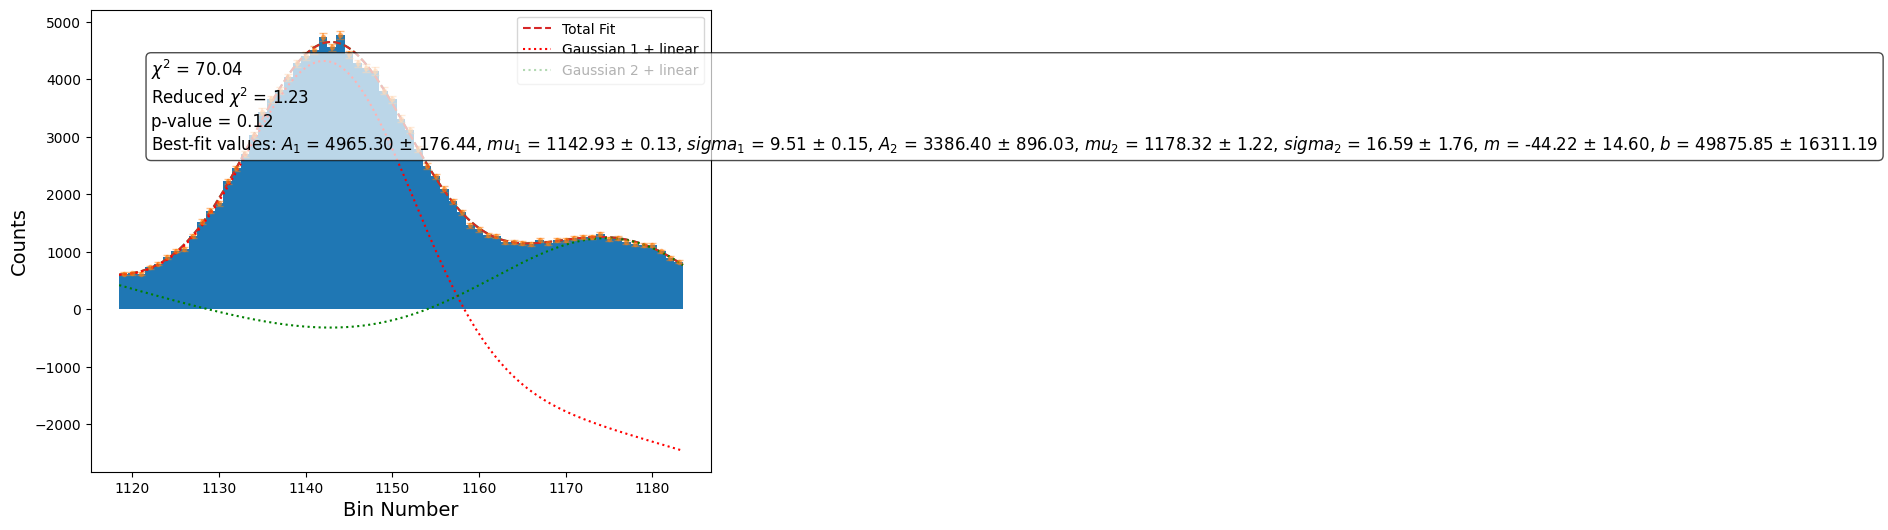

In [ ]:
# Recording Tb values for KM3 and KN lines at ~50 keV
range_beg = 1119
range_end = 1183
data_for_hist = []
for bin_num,counts in enumerate(data):
    if bin_num >= range_beg and bin_num <= range_end:
        try:
            for _ in range(int(counts)):
                data_for_hist.append(bin_num)
        except:
            break
fig, ax = plt.subplots(figsize=(8,6))

bins = np.arange(range_beg - 0.5, range_end + 1.5, 1)
hist_counts,bin_edges = ax.hist(data_for_hist,bins=bins)[:2] 

bin_centers = ((bin_edges[:-1] + bin_edges[1:]) / 2)
hist_uncertainties = [x**(0.5) for x in hist_counts]
ax.errorbar(bin_centers, hist_counts, yerr=hist_uncertainties, fmt = '.', capsize = 3, alpha = 0.5)

initial_guess = [max(hist_counts), bins[np.argmax(hist_counts)], 10, max(hist_counts)/2, bins[np.argmax(hist_counts)]+15, 10, 0,0]
fit_func = two_gaussians_plus_linear

popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,initial_guess,sigma=hist_uncertainties, absolute_sigma=True)

chi2_value = 0
for index,bin_center in enumerate(bin_centers):
    chi2_value += (fit_func(bin_center, *popt) - hist_counts[index])**2/hist_uncertainties[index]**2
dof = len(hist_counts) - len(popt)
reduced_chi2 = chi2_value/dof
chi2_prob = chi2.cdf(chi2_value, dof)
p_val = 1 - chi2_prob

overplot_x = np.linspace(range_beg-0.5, range_end+0.5, num=200)
overplot_y = fit_func(overplot_x, *popt)

ax.plot(overplot_x, overplot_y, linestyle='--')
fig.text(
    0.2, 0.8,  # position relative to the figure, not just the axis
    generate_text_string(fit_func,popt,pcov,chi2_value,reduced_chi2,p_val),
    ha='left', va='top',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
)
ax.set_xlabel("Bin Number", fontsize=14)
ax.set_ylabel("Counts", fontsize=14)

# Individual Gaussians with linear background
linear_bg = popt[6] * overplot_x + popt[7]
gauss1_with_bg = popt[0] * np.exp(-0.5 * ((overplot_x - popt[1]) / popt[2]) ** 2) + linear_bg
gauss2_with_bg = popt[3] * np.exp(-0.5 * ((overplot_x - popt[4]) / popt[5]) ** 2) + linear_bg

ax.plot(overplot_x, overplot_y, linestyle='--', label='Total Fit')
ax.plot(overplot_x, gauss1_with_bg, linestyle=':', color='red', label='Gaussian 1 + linear')
ax.plot(overplot_x, gauss2_with_bg, linestyle=':', color='green', label='Gaussian 2 + linear')
ax.legend()

moseleys_lines[("Tb","KM3")] = (get_ener_at_bin(popt[1],*ba2_calib_val), calc_ener_err(ba2_calib_val, ba2_calib_val_err, pcov,popt,1))
moseleys_lines[("Tb","KN")] = (get_ener_at_bin(popt[4],*ba2_calib_val), calc_ener_err(ba2_calib_val, ba2_calib_val_err, pcov,popt,4))

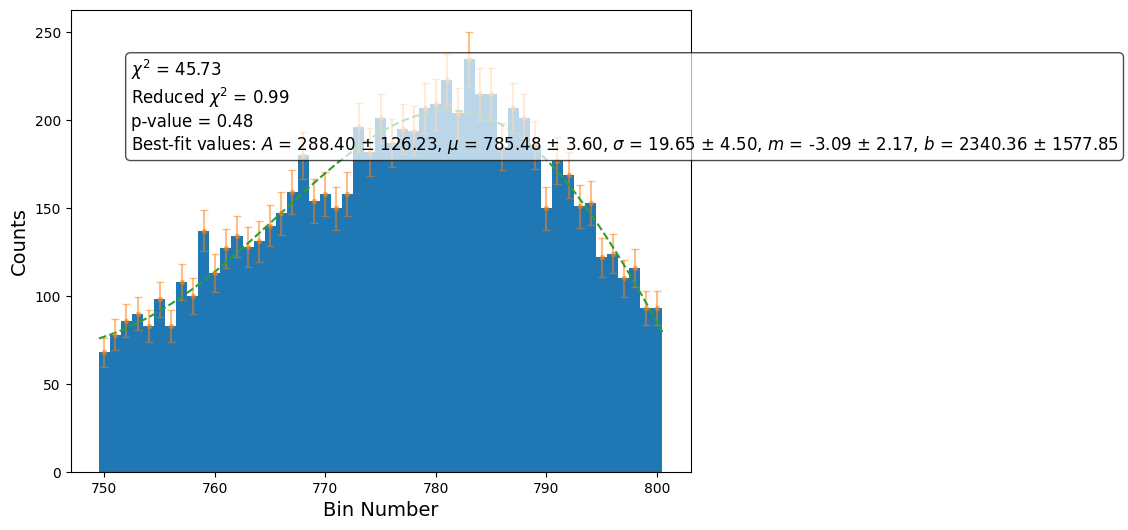

In [ ]:
# Recording escape peak for germanium K-alpha line, which is expected at 9.88652 keV
range_beg = 750
range_end = 800
data_for_hist = []
for bin_num,counts in enumerate(data):
    if bin_num >= range_beg and bin_num <= range_end:
        try:
            for _ in range(int(counts)):
                data_for_hist.append(bin_num)
        except:
            break
fig, ax = plt.subplots(figsize=(8,6))

bins = np.arange(range_beg - 0.5, range_end + 1.5, 1)
hist_counts,bin_edges = ax.hist(data_for_hist,bins=bins)[:2] 

bin_centers = ((bin_edges[:-1] + bin_edges[1:]) / 2)
hist_uncertainties = [x**(0.5) for x in hist_counts]
# inputting 1 instead of 0 for histogram bins with 0 counts to fix divide by 0 error.
had_to_fix_div_by_zero = False
for i in range(len(hist_uncertainties)):
    if hist_uncertainties[i] == 0:
        hist_uncertainties[i] = 1
        had_to_fix_div_by_zero = True
ax.errorbar(bin_centers, hist_counts, yerr=hist_uncertainties, fmt = '.', capsize = 3, alpha = 0.5)

initial_guess = [hist_counts.max(),mode(data_for_hist)[0],20, 0,0]
fit_func = gaussian_plus_linear

popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,initial_guess,sigma=hist_uncertainties, absolute_sigma=True)
if had_to_fix_div_by_zero:
    popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,popt,sigma=[popt[1]**0.5]*len(hist_counts), absolute_sigma=True)
chi2_value = 0
for index,bin_center in enumerate(bin_centers):
    chi2_value += (fit_func(bin_center, *popt) - hist_counts[index])**2/hist_uncertainties[index]**2
dof = len(hist_counts) - len(popt)
reduced_chi2 = chi2_value/dof
chi2_prob = chi2.cdf(chi2_value, dof)
p_val = 1 - chi2_prob

overplot_x = np.linspace(range_beg-0.5, range_end+0.5, num=200)
overplot_y = fit_func(overplot_x, *popt)

ax.plot(overplot_x, overplot_y, linestyle='--')
fig.text(
    0.2, 0.8,  # position relative to the figure, not just the axis
    generate_text_string(fit_func,popt,pcov,chi2_value,reduced_chi2,p_val),
    ha='left', va='top',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
)
ax.set_xlabel("Bin Number", fontsize=14)
ax.set_ylabel("Counts", fontsize=14)

moseleys_lines[("Ge","KL3")] = (moseleys_lines[("Tb","KL3")][0] - get_ener_at_bin(popt[1],*ba2_calib_val), 
                                (moseleys_lines[("Tb","KL3")][1]**2 + calc_ener_err(ba2_calib_val, ba2_calib_val_err, pcov,popt,1)**2) **0.5 ) # Germanium line

<BarContainer object of 2048 artists>

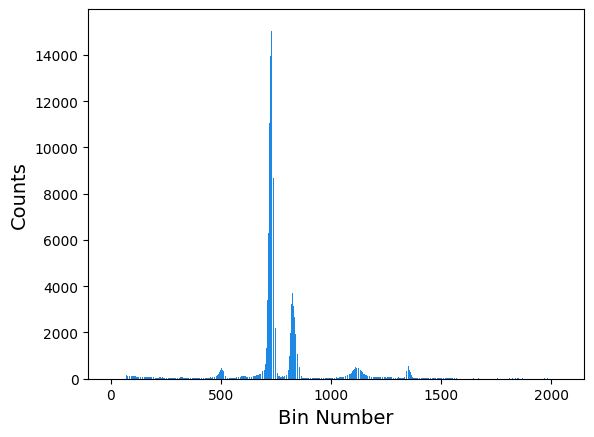

In [ ]:
ba_moseley = "9_29\\barium_x_ray_spectra_9_29.Spe"
data = np.genfromtxt(ba_moseley, delimiter='\n', skip_header=12)
plt.xlabel("Bin Number", fontsize=14)
plt.ylabel("Counts", fontsize=14)
plt.bar(range(2048),data[:2048], color = '#1E88E5')

In [ ]:
# # Finding optimal range for Ba KL2 and KL3 lines at ~ 31 keV
# # Candidate fit ranges (tuples of (start, end))
# candidate_ranges = generate_candidate_ranges(700, 750,bound = 10, step_size= 3)
# # Candidate models and their initial guesses
# candidate_models = [
#     (gaussian, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10]),
#     (gaussian_plus_linear, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10, 0, 0]),
#     (gaussian_plus_constant, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10, 0])
#     # (two_gaussians, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10, max(counts)/2, bins[np.argmax(counts)]+15, 10]),
#     # (two_gaussians_plus_linear, lambda counts, bins: [max(counts)/2, bins[np.argmax(counts)], 10, max(counts)/2, bins[np.argmax(counts)]+15, 10, 0,0])
# ]

# results = []

# for fit_range in candidate_ranges:
#     # Prepare histogram for this range
#     data_for_hist = []
#     for bin_num, counts in enumerate(data):
#         if fit_range[0] <= bin_num <= fit_range[1]:
#             try:
#                 for _ in range(int(counts)):
#                     data_for_hist.append(bin_num)
#             except Exception:
#                 break
#     bins = np.arange(fit_range[0] - 0.5, fit_range[1] + 1.5, 1)
#     hist_counts, bin_edges = np.histogram(data_for_hist, bins=bins)
#     bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

#     for model_func, guess_func in candidate_models:
#         try:
#             initial_guess = guess_func(hist_counts, bin_centers)
#             fit_result = fit_peak_with_residuals(
#                 data=data,
#                 range_beg=fit_range[0],
#                 range_end=fit_range[1],
#                 fit_func=model_func,
#                 initial_guess=initial_guess,
#                 xlabel="Bin Number",
#                 ylabel="Counts",
#                 title=f"Range {fit_range}, Model {model_func.__name__}",
#                 annotate_fit=False  # We'll annotate only the best fit
#             )
#             results.append({
#                 "range": fit_range,
#                 "model": model_func.__name__,
#                 "fit_result": fit_result
#             })
#         except Exception as e:
#             print(f"Fit failed for range {fit_range} and model {model_func.__name__}: {e}")

# # Select the best fit (lowest reduced chi²)
# best = min(results, key=lambda r: r["fit_result"]["reduced_chi2"])
# print(f"Best fit: Range {best['range']}, Model {best['model']}, Reduced chi² = {best['fit_result']['reduced_chi2']:.2f}")

# # Plot the best fit with annotation
# results = fit_peak_with_residuals(
#     data=data,
#     range_beg=best["range"][0],
#     range_end=best["range"][1],
#     fit_func=eval(best["model"]),
#     initial_guess=best["fit_result"]["popt"],
#     xlabel="Bin Number",
#     ylabel="Counts",
#     title=f"Best Fit: Range {best['range']}, Model {best['model']}",
#     annotate_fit=True,
#     display_plot = True
# )

# popt = results["popt"]

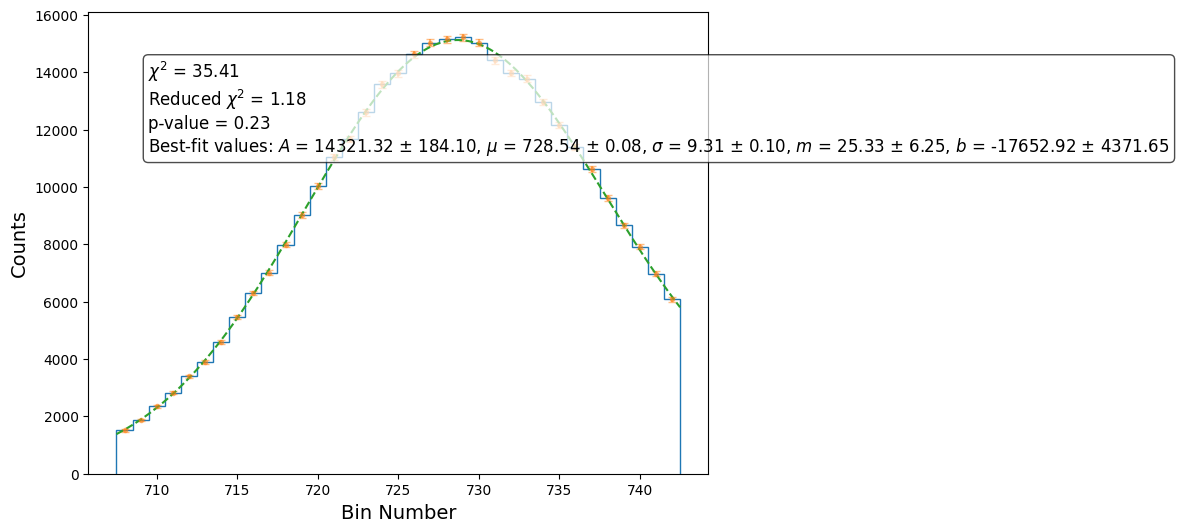

In [ ]:
# Recording barium ~32 keV peak, in theory two peaks (KL2 and KL3) at (31.817 keV and 32.193 keV)
# Tried two_gaussians and gaussian_plus_linear fits and see which is better
# End up using gaussian_plus_linear because the two peaks are so close together (impossible to resolve a second peak here)

range_beg = 708
range_end = 742
data_for_hist = []
for bin_num,counts in enumerate(data):
    if bin_num >= range_beg and bin_num <= range_end:
        try:
            for _ in range(int(counts)):
                data_for_hist.append(bin_num)
        except:
            break
fig, ax = plt.subplots(figsize=(8,6))

bins = np.arange(range_beg - 0.5, range_end + 1.5, 1)
hist_counts,bin_edges = ax.hist(data_for_hist,bins=bins,histtype="step")[:2] 

bin_centers = ((bin_edges[:-1] + bin_edges[1:]) / 2)
hist_uncertainties = [x**(0.5) for x in hist_counts]
ax.errorbar(bin_centers, hist_counts, yerr=hist_uncertainties, fmt = '.', capsize = 3, alpha = 0.5)

initial_guess = [max(hist_counts), bins[np.argmax(hist_counts)],10, 0,0]
fit_func = gaussian_plus_linear

popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,initial_guess,sigma=hist_uncertainties, absolute_sigma=True)

chi2_value = 0
for index,bin_center in enumerate(bin_centers):
    chi2_value += (fit_func(bin_center, *popt) - hist_counts[index])**2/hist_uncertainties[index]**2
dof = len(hist_counts) - len(popt)
reduced_chi2 = chi2_value/dof
chi2_prob = chi2.cdf(chi2_value, dof)
p_val = 1 - chi2_prob

overplot_x = np.linspace(range_beg-0.5, range_end+0.5, num=200)
overplot_y = fit_func(overplot_x, *popt)

ax.plot(overplot_x, overplot_y, linestyle='--')

# # Overplot the sum of both Gaussians (already done below)
# # Now plot each Gaussian individually
# gauss1 = lambda x: popt[0] * np.exp(-0.5 * ((x - popt[1]) / popt[2]) ** 2)
# gauss2 = lambda x: popt[3] * np.exp(-0.5 * ((x - popt[4]) / popt[5]) ** 2)

# ax.plot(overplot_x, gauss1(overplot_x), linestyle=':', color='red', label='Gaussian 1')
# ax.plot(overplot_x, gauss2(overplot_x), linestyle=':', color='green', label='Gaussian 2')
# ax.legend()

fig.text(
    0.2, 0.8,  # position relative to the figure, not just the axis
    generate_text_string(fit_func,popt,pcov,chi2_value,reduced_chi2,p_val),
    ha='left', va='top',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
)
ax.set_xlabel("Bin Number", fontsize=14)
ax.set_ylabel("Counts", fontsize=14)

moseleys_lines[("Ba","KL3")] = (get_ener_at_bin(popt[1],*ba2_calib_val), calc_ener_err(ba2_calib_val, ba2_calib_val_err, pcov,popt,1))

In [ ]:
# # Finding optimal range for Ba KM3 and KN lines at ~ 36/37 keV
# # Candidate fit ranges (tuples of (start, end))
# candidate_ranges = generate_candidate_ranges(790, 870,bound = 15, step_size= 3)
# # Candidate models and their initial guesses
# candidate_models = [
#     # (gaussian, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10]),
#     # (gaussian_plus_linear, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10, 0, 0]),
#     # (gaussian_plus_constant, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10, 0])
#     (two_gaussians, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10, max(counts)/2, bins[np.argmax(counts)]+15, 10]),
#     (two_gaussians_plus_linear, lambda counts, bins: [max(counts)/2, bins[np.argmax(counts)], 10, max(counts)/2, bins[np.argmax(counts)]+15, 10, 0,0])
# ]

# results = []

# for fit_range in candidate_ranges:
#     # Prepare histogram for this range
#     data_for_hist = []
#     for bin_num, counts in enumerate(data):
#         if fit_range[0] <= bin_num <= fit_range[1]:
#             try:
#                 for _ in range(int(counts)):
#                     data_for_hist.append(bin_num)
#             except Exception:
#                 break
#     bins = np.arange(fit_range[0] - 0.5, fit_range[1] + 1.5, 1)
#     hist_counts, bin_edges = np.histogram(data_for_hist, bins=bins)
#     bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

#     for model_func, guess_func in candidate_models:
#         try:
#             initial_guess = guess_func(hist_counts, bin_centers)
#             fit_result = fit_peak_with_residuals(
#                 data=data,
#                 range_beg=fit_range[0],
#                 range_end=fit_range[1],
#                 fit_func=model_func,
#                 initial_guess=initial_guess,
#                 xlabel="Bin Number",
#                 ylabel="Counts",
#                 title=f"Range {fit_range}, Model {model_func.__name__}",
#                 annotate_fit=False  # We'll annotate only the best fit
#             )
#             results.append({
#                 "range": fit_range,
#                 "model": model_func.__name__,
#                 "fit_result": fit_result
#             })
#         except Exception as e:
#             print(f"Fit failed for range {fit_range} and model {model_func.__name__}: {e}")

# # Select the best fit (lowest reduced chi²)
# best = min(results, key=lambda r: r["fit_result"]["reduced_chi2"])
# print(f"Best fit: Range {best['range']}, Model {best['model']}, Reduced chi² = {best['fit_result']['reduced_chi2']:.2f}")

# # Plot the best fit with annotation
# results = fit_peak_with_residuals(
#     data=data,
#     range_beg=best["range"][0],
#     range_end=best["range"][1],
#     fit_func=eval(best["model"]),
#     initial_guess=best["fit_result"]["popt"],
#     xlabel="Bin Number",
#     ylabel="Counts",
#     title=f"Best Fit: Range {best['range']}, Model {best['model']}",
#     annotate_fit=True,
#     display_plot = True
# )

# popt = results["popt"]

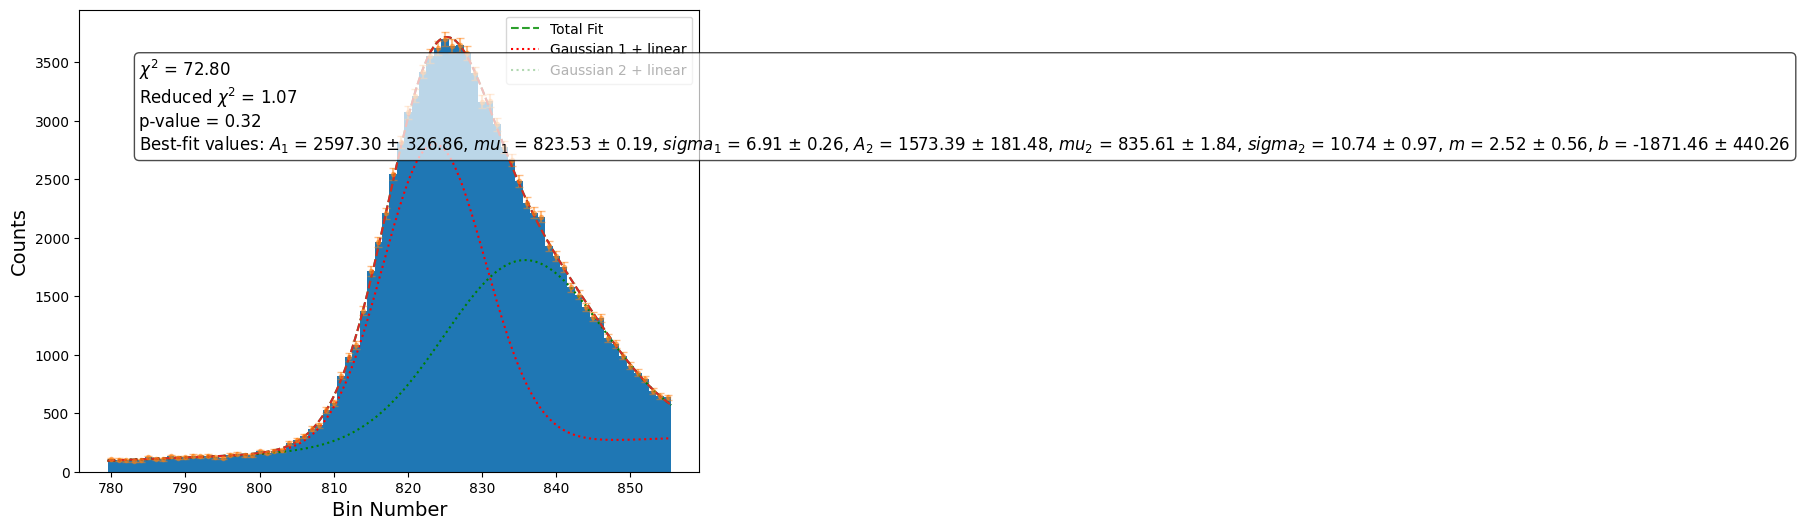

In [ ]:
# Recording Barium ~36.55 keV peaks
range_beg = 780
range_end = 855
data_for_hist = []
for bin_num,counts in enumerate(data):
    if bin_num >= range_beg and bin_num <= range_end:
        try:
            for _ in range(int(counts)):
                data_for_hist.append(bin_num)
        except:
            break
fig, ax = plt.subplots(figsize=(8,6))

bins = np.arange(range_beg - 0.5, range_end + 1.5, 1)
hist_counts,bin_edges = ax.hist(data_for_hist,bins=bins)[:2] 

bin_centers = ((bin_edges[:-1] + bin_edges[1:]) / 2)
hist_uncertainties = [x**(0.5) for x in hist_counts]
ax.errorbar(bin_centers, hist_counts, yerr=hist_uncertainties, fmt = '.', capsize = 3, alpha = 0.5)

initial_guess = [hist_counts.max(),mode(data_for_hist)[0],5, 100,mode(data_for_hist)[0]-5,20,   0,0]
fit_func = two_gaussians_plus_linear

popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,initial_guess,sigma=hist_uncertainties, absolute_sigma=True)
if had_to_fix_div_by_zero:
    popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,popt,sigma=[popt[1]**0.5]*len(hist_counts), absolute_sigma=True)
chi2_value = 0
for index,bin_center in enumerate(bin_centers):
    chi2_value += (fit_func(bin_center, *popt) - hist_counts[index])**2/hist_uncertainties[index]**2
dof = len(hist_counts) - len(popt)
reduced_chi2 = chi2_value/dof
chi2_prob = chi2.cdf(chi2_value, dof)
p_val = 1 - chi2_prob

overplot_x = np.linspace(range_beg-0.5, range_end+0.5, num=200)
overplot_y = fit_func(overplot_x, *popt)

# Individual Gaussians with linear background
linear_bg = popt[6] * overplot_x + popt[7]
gauss1_with_bg = popt[0] * np.exp(-0.5 * ((overplot_x - popt[1]) / popt[2]) ** 2) + linear_bg
gauss2_with_bg = popt[3] * np.exp(-0.5 * ((overplot_x - popt[4]) / popt[5]) ** 2) + linear_bg

ax.plot(overplot_x, overplot_y, linestyle='--', label='Total Fit')
ax.plot(overplot_x, gauss1_with_bg, linestyle=':', color='red', label='Gaussian 1 + linear')
ax.plot(overplot_x, gauss2_with_bg, linestyle=':', color='green', label='Gaussian 2 + linear')
ax.legend()

ax.plot(overplot_x, overplot_y, linestyle='--')
fig.text(
    0.2, 0.8,  # position relative to the figure, not just the axis
    generate_text_string(fit_func,popt,pcov,chi2_value,reduced_chi2,p_val),
    ha='left', va='top',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
)
ax.set_xlabel("Bin Number", fontsize=14)
ax.set_ylabel("Counts", fontsize=14)

moseleys_lines[("Ba","KM3")] = (get_ener_at_bin(popt[1],*ba2_calib_val), calc_ener_err(ba2_calib_val, ba2_calib_val_err, pcov,popt,1))
moseleys_lines[("Ba","KN")] = (get_ener_at_bin(popt[4],*ba2_calib_val), calc_ener_err(ba2_calib_val, ba2_calib_val_err, pcov,popt,4))

<BarContainer object of 2048 artists>

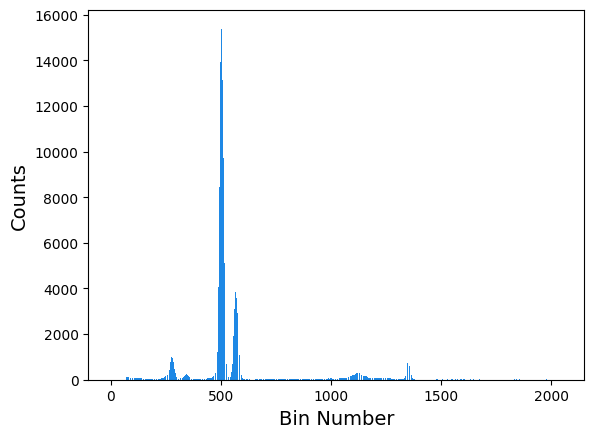

In [ ]:
ag1 = "9_29\\ag_x_ray_spectra_2_9_29.Spe"
data = np.genfromtxt(ag1, delimiter='\n', skip_header=12)
plt.xlabel("Bin Number", fontsize=14)
plt.ylabel("Counts", fontsize=14)
plt.bar(range(2048),data[:2048], color = '#1E88E5')

In [ ]:
# # Finding optimal range for Ag KL2 and KL3 lines at ~ 22 keV
# # Candidate fit ranges (tuples of (start, end))
# candidate_ranges = generate_candidate_ranges(480, 525,bound = 10, step_size= 3)
# # Candidate models and their initial guesses
# candidate_models = [
#     (gaussian, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10]),
#     (gaussian_plus_linear, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10, 0, 0]),
#     (gaussian_plus_constant, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10, 0])
#     # (two_gaussians, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10, max(counts)/2, bins[np.argmax(counts)]+15, 10]),
#     # (two_gaussians_plus_linear, lambda counts, bins: [max(counts)/2, bins[np.argmax(counts)], 10, max(counts)/2, bins[np.argmax(counts)]+15, 10, 0,0])
# ]

# results = []

# for fit_range in candidate_ranges:
#     # Prepare histogram for this range
#     data_for_hist = []
#     for bin_num, counts in enumerate(data):
#         if fit_range[0] <= bin_num <= fit_range[1]:
#             try:
#                 for _ in range(int(counts)):
#                     data_for_hist.append(bin_num)
#             except Exception:
#                 break
#     bins = np.arange(fit_range[0] - 0.5, fit_range[1] + 1.5, 1)
#     hist_counts, bin_edges = np.histogram(data_for_hist, bins=bins)
#     bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

#     for model_func, guess_func in candidate_models:
#         try:
#             initial_guess = guess_func(hist_counts, bin_centers)
#             fit_result = fit_peak_with_residuals(
#                 data=data,
#                 range_beg=fit_range[0],
#                 range_end=fit_range[1],
#                 fit_func=model_func,
#                 initial_guess=initial_guess,
#                 xlabel="Bin Number",
#                 ylabel="Counts",
#                 title=f"Range {fit_range}, Model {model_func.__name__}",
#                 annotate_fit=False  # We'll annotate only the best fit
#             )
#             results.append({
#                 "range": fit_range,
#                 "model": model_func.__name__,
#                 "fit_result": fit_result
#             })
#         except Exception as e:
#             print(f"Fit failed for range {fit_range} and model {model_func.__name__}: {e}")

# # Select the best fit (lowest reduced chi²)
# best = min(results, key=lambda r: r["fit_result"]["reduced_chi2"])
# print(f"Best fit: Range {best['range']}, Model {best['model']}, Reduced chi² = {best['fit_result']['reduced_chi2']:.2f}")

# # Plot the best fit with annotation
# results = fit_peak_with_residuals(
#     data=data,
#     range_beg=best["range"][0],
#     range_end=best["range"][1],
#     fit_func=eval(best["model"]),
#     initial_guess=best["fit_result"]["popt"],
#     xlabel="Bin Number",
#     ylabel="Counts",
#     title=f"Best Fit: Range {best['range']}, Model {best['model']}",
#     annotate_fit=True,
#     display_plot = True
# )

# popt = results["popt"]

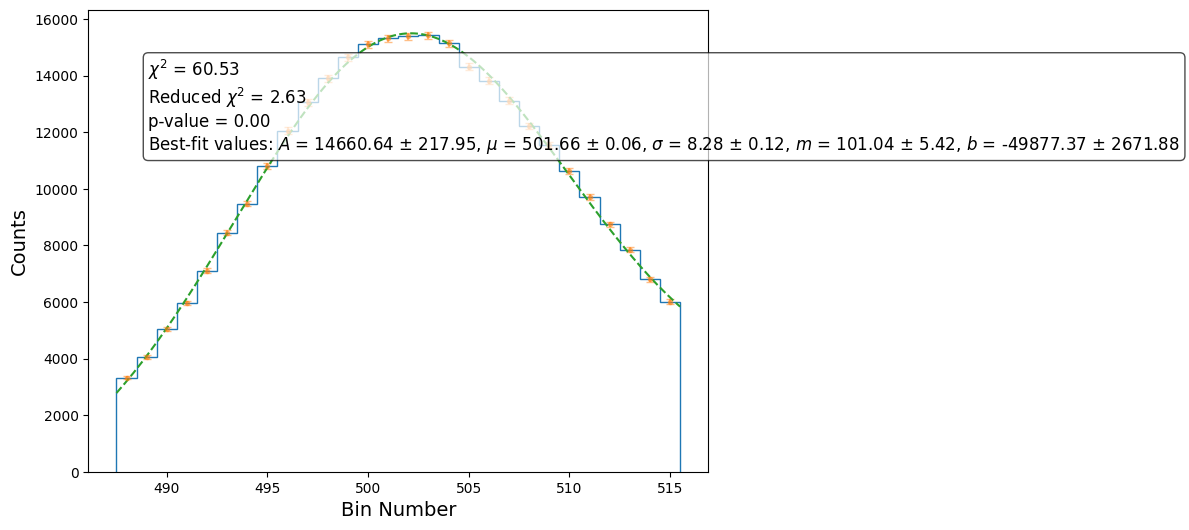

In [ ]:
# Recording Ag KL3 peak at ~ 22 keV

range_beg = 488
range_end = 515
data_for_hist = []
for bin_num,counts in enumerate(data):
    if bin_num >= range_beg and bin_num <= range_end:
        try:
            for _ in range(int(counts)):
                data_for_hist.append(bin_num)
        except:
            break
fig, ax = plt.subplots(figsize=(8,6))

bins = np.arange(range_beg - 0.5, range_end + 1.5, 1)
hist_counts,bin_edges = ax.hist(data_for_hist,bins=bins,histtype="step")[:2] 

bin_centers = ((bin_edges[:-1] + bin_edges[1:]) / 2)
hist_uncertainties = [x**(0.5) for x in hist_counts]
ax.errorbar(bin_centers, hist_counts, yerr=hist_uncertainties, fmt = '.', capsize = 3, alpha = 0.5)

initial_guess = [max(hist_counts), bins[np.argmax(hist_counts)],10, 0,0]
fit_func = gaussian_plus_linear

popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,initial_guess,sigma=hist_uncertainties, absolute_sigma=True)

chi2_value = 0
for index,bin_center in enumerate(bin_centers):
    chi2_value += (fit_func(bin_center, *popt) - hist_counts[index])**2/hist_uncertainties[index]**2
dof = len(hist_counts) - len(popt)
reduced_chi2 = chi2_value/dof
chi2_prob = chi2.cdf(chi2_value, dof)
p_val = 1 - chi2_prob

overplot_x = np.linspace(range_beg-0.5, range_end+0.5, num=200)
overplot_y = fit_func(overplot_x, *popt)

ax.plot(overplot_x, overplot_y, linestyle='--')

fig.text(
    0.2, 0.8,  # position relative to the figure, not just the axis
    generate_text_string(fit_func,popt,pcov,chi2_value,reduced_chi2,p_val),
    ha='left', va='top',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
)
ax.set_xlabel("Bin Number", fontsize=14)
ax.set_ylabel("Counts", fontsize=14)

moseleys_lines[("Ag","KL3")] = (get_ener_at_bin(popt[1],*ba2_calib_val), calc_ener_err(ba2_calib_val, ba2_calib_val_err, pcov,popt,1))

In [ ]:
# # Finding optimal range for Ag KM3 Line at ~ 25 keV
# # Candidate fit ranges (tuples of (start, end))
# candidate_ranges = generate_candidate_ranges(540, 595,bound = 15, step_size= 3)
# # Candidate models and their initial guesses
# candidate_models = [
#     (gaussian, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10]),
#     (gaussian_plus_linear, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10, 0, 0]),
#     (gaussian_plus_constant, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10, 0])
#     # (two_gaussians, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10, max(counts)/2, bins[np.argmax(counts)]+15, 10]),
#     # (two_gaussians_plus_linear, lambda counts, bins: [max(counts)/2, bins[np.argmax(counts)], 10, max(counts)/2, bins[np.argmax(counts)]+15, 10, 0,0])
# ]

# results = []

# for fit_range in candidate_ranges:
#     # Prepare histogram for this range
#     data_for_hist = []
#     for bin_num, counts in enumerate(data):
#         if fit_range[0] <= bin_num <= fit_range[1]:
#             try:
#                 for _ in range(int(counts)):
#                     data_for_hist.append(bin_num)
#             except Exception:
#                 break
#     bins = np.arange(fit_range[0] - 0.5, fit_range[1] + 1.5, 1)
#     hist_counts, bin_edges = np.histogram(data_for_hist, bins=bins)
#     bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

#     for model_func, guess_func in candidate_models:
#         try:
#             initial_guess = guess_func(hist_counts, bin_centers)
#             fit_result = fit_peak_with_residuals(
#                 data=data,
#                 range_beg=fit_range[0],
#                 range_end=fit_range[1],
#                 fit_func=model_func,
#                 initial_guess=initial_guess,
#                 xlabel="Bin Number",
#                 ylabel="Counts",
#                 title=f"Range {fit_range}, Model {model_func.__name__}",
#                 annotate_fit=False  # We'll annotate only the best fit
#             )
#             results.append({
#                 "range": fit_range,
#                 "model": model_func.__name__,
#                 "fit_result": fit_result
#             })
#         except Exception as e:
#             print(f"Fit failed for range {fit_range} and model {model_func.__name__}: {e}")

# # Select the best fit (lowest reduced chi²)
# best = min(results, key=lambda r: r["fit_result"]["reduced_chi2"])
# print(f"Best fit: Range {best['range']}, Model {best['model']}, Reduced chi² = {best['fit_result']['reduced_chi2']:.2f}")

# # Plot the best fit with annotation
# results = fit_peak_with_residuals(
#     data=data,
#     range_beg=best["range"][0],
#     range_end=best["range"][1],
#     fit_func=eval(best["model"]),
#     initial_guess=best["fit_result"]["popt"],
#     xlabel="Bin Number",
#     ylabel="Counts",
#     title=f"Best Fit: Range {best['range']}, Model {best['model']}",
#     annotate_fit=True,
#     display_plot = True
# )

# popt = results["popt"]

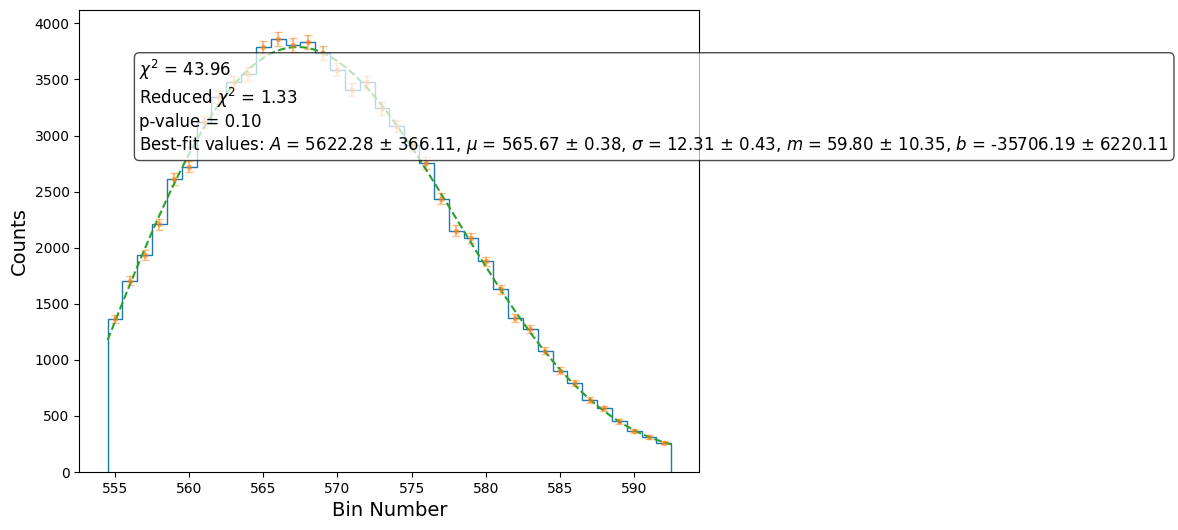

In [ ]:
# Recording Ag KM3 peak at ~ 24 keV

range_beg = 555
range_end = 592
data_for_hist = []
for bin_num,counts in enumerate(data):
    if bin_num >= range_beg and bin_num <= range_end:
        try:
            for _ in range(int(counts)):
                data_for_hist.append(bin_num)
        except:
            break
fig, ax = plt.subplots(figsize=(8,6))

bins = np.arange(range_beg - 0.5, range_end + 1.5, 1)
hist_counts,bin_edges = ax.hist(data_for_hist,bins=bins,histtype="step")[:2] 

bin_centers = ((bin_edges[:-1] + bin_edges[1:]) / 2)
hist_uncertainties = [x**(0.5) for x in hist_counts]
ax.errorbar(bin_centers, hist_counts, yerr=hist_uncertainties, fmt = '.', capsize = 3, alpha = 0.5)

initial_guess = [max(hist_counts), bins[np.argmax(hist_counts)],10, 0,0]
fit_func = gaussian_plus_linear

popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,initial_guess,sigma=hist_uncertainties, absolute_sigma=True)

chi2_value = 0
for index,bin_center in enumerate(bin_centers):
    chi2_value += (fit_func(bin_center, *popt) - hist_counts[index])**2/hist_uncertainties[index]**2
dof = len(hist_counts) - len(popt)
reduced_chi2 = chi2_value/dof
chi2_prob = chi2.cdf(chi2_value, dof)
p_val = 1 - chi2_prob

overplot_x = np.linspace(range_beg-0.5, range_end+0.5, num=200)
overplot_y = fit_func(overplot_x, *popt)

ax.plot(overplot_x, overplot_y, linestyle='--')

fig.text(
    0.2, 0.8,  # position relative to the figure, not just the axis
    generate_text_string(fit_func,popt,pcov,chi2_value,reduced_chi2,p_val),
    ha='left', va='top',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
)
ax.set_xlabel("Bin Number", fontsize=14)
ax.set_ylabel("Counts", fontsize=14)

moseleys_lines[("Ag","KM3")] = (get_ener_at_bin(popt[1],*ba2_calib_val), calc_ener_err(ba2_calib_val, ba2_calib_val_err, pcov,popt,1))

## 9-29 Moseley's max gain barium 2, copper

<BarContainer object of 2048 artists>

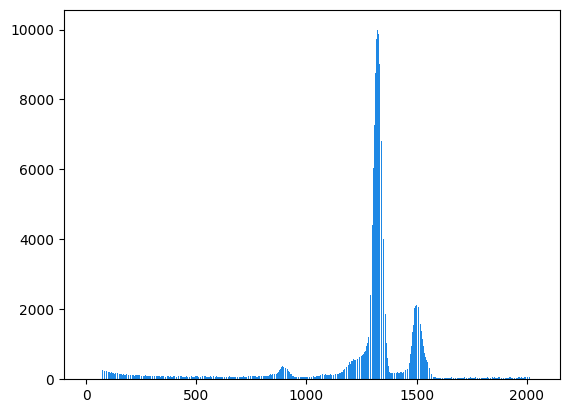

In [ ]:
ba4 = "9_29\\barium_max_gain_calibration_x_ray_spectra_2_9_29.Spe"
ba4_calib = {}
data = np.genfromtxt(ba4, delimiter='\n', skip_header=12)

plt.bar(range(2048),data[:2048], color = '#1E88E5')

In [ ]:
# # Finding optimal range for 133 Barium, 31 keV peak
# # Candidate fit ranges (tuples of (start, end))
# candidate_ranges = generate_candidate_ranges(1288, 1360,bound = 10, step_size= 3)
# # Candidate models and their initial guesses
# candidate_models = [
#     (gaussian, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10]),
#     (gaussian_plus_linear, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10, 0, 0]),
#     (gaussian_plus_constant, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10, 0])
#     # (two_gaussians, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10, max(counts)/2, bins[np.argmax(counts)]+15, 10]),
#     # (two_gaussians_plus_linear, lambda counts, bins: [max(counts)/2, bins[np.argmax(counts)], 10, max(counts)/2, bins[np.argmax(counts)]+15, 10, 0,0])
# ]

# results = []

# for fit_range in candidate_ranges:
#     # Prepare histogram for this range
#     data_for_hist = []
#     for bin_num, counts in enumerate(data):
#         if fit_range[0] <= bin_num <= fit_range[1]:
#             try:
#                 for _ in range(int(counts)):
#                     data_for_hist.append(bin_num)
#             except Exception:
#                 break
#     bins = np.arange(fit_range[0] - 0.5, fit_range[1] + 1.5, 1)
#     hist_counts, bin_edges = np.histogram(data_for_hist, bins=bins)
#     bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

#     for model_func, guess_func in candidate_models:
#         try:
#             initial_guess = guess_func(hist_counts, bin_centers)
#             fit_result = fit_peak_with_residuals(
#                 data=data,
#                 range_beg=fit_range[0],
#                 range_end=fit_range[1],
#                 fit_func=model_func,
#                 initial_guess=initial_guess,
#                 xlabel="Bin Number",
#                 ylabel="Counts",
#                 title=f"Range {fit_range}, Model {model_func.__name__}",
#                 annotate_fit=False  # We'll annotate only the best fit
#             )
#             results.append({
#                 "range": fit_range,
#                 "model": model_func.__name__,
#                 "fit_result": fit_result
#             })
#         except Exception as e:
#             print(f"Fit failed for range {fit_range} and model {model_func.__name__}: {e}")

# # Select the best fit (lowest reduced chi²)
# best = min(results, key=lambda r: r["fit_result"]["reduced_chi2"])
# print(f"Best fit: Range {best['range']}, Model {best['model']}, Reduced chi² = {best['fit_result']['reduced_chi2']:.2f}")

# # Plot the best fit with annotation
# results = fit_peak_with_residuals(
#     data=data,
#     range_beg=best["range"][0],
#     range_end=best["range"][1],
#     fit_func=eval(best["model"]),
#     initial_guess=best["fit_result"]["popt"],
#     xlabel="Bin Number",
#     ylabel="Counts",
#     title=f"Best Fit: Range {best['range']}, Model {best['model']}",
#     annotate_fit=True,
#     display_plot = True
# )
# popt = results["popt"]

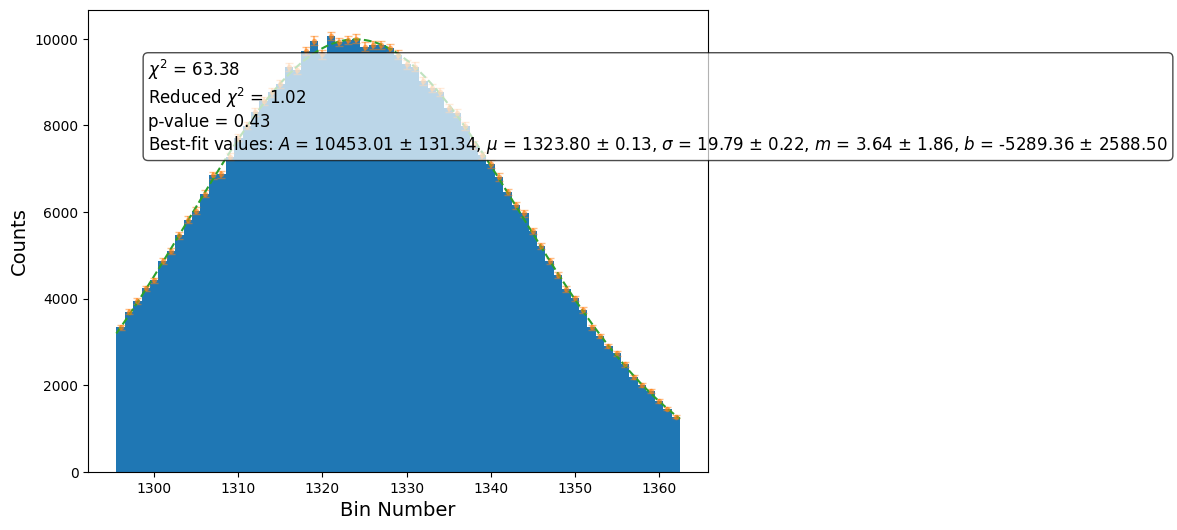

In [ ]:
# Recording calibration to 31 keV
range_beg = 1296
range_end = 1362

data_for_hist = []
for bin_num,counts in enumerate(data):
    if bin_num >= range_beg and bin_num <= range_end:
        try:
            for _ in range(int(counts)):
                data_for_hist.append(bin_num)
        except:
            break
fig, ax = plt.subplots(figsize=(8,6))

bins = np.arange(range_beg - 0.5, range_end + 1.5, 1)
hist_counts,bin_edges = ax.hist(data_for_hist,bins=bins)[:2] 

bin_centers = ((bin_edges[:-1] + bin_edges[1:]) / 2)
hist_uncertainties = [x**(0.5) for x in hist_counts]

ax.errorbar(bin_centers,hist_counts,yerr=hist_uncertainties,fmt = '.',capsize = 3, alpha = 0.5)

fit_func = gaussian_plus_linear
initial_guess = [hist_counts.max(),mode(data_for_hist)[0],20,   -0.1,0]

popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,initial_guess,sigma=hist_uncertainties, absolute_sigma=True)
chi2_value = 0
for index,bin_center in enumerate(bin_centers):
    chi2_value += (fit_func(bin_center, *popt) - hist_counts[index])**2/hist_uncertainties[index]**2
dof = len(hist_counts) - len(popt)
reduced_chi2 = chi2_value/dof
chi2_prob = chi2.cdf(chi2_value, dof)
p_val = 1 - chi2_prob

overplot_x = np.linspace(range_beg-0.5, range_end+0.5, num=200)
overplot_y = fit_func(overplot_x, *popt)

# # Individual Gaussians with linear background
# linear_bg = popt[6] * overplot_x + popt[7]
# gauss1_with_bg = popt[0] * np.exp(-0.5 * ((overplot_x - popt[1]) / popt[2]) ** 2) + linear_bg
# gauss2_with_bg = popt[3] * np.exp(-0.5 * ((overplot_x - popt[4]) / popt[5]) ** 2) + linear_bg

ax.plot(overplot_x, overplot_y, linestyle='--', label='Total Fit')
# ax.plot(overplot_x, gauss1_with_bg, linestyle=':', color='red', label='Gaussian 1 + linear')
# ax.plot(overplot_x, gauss2_with_bg, linestyle=':', color='green', label='Gaussian 2 + linear')
# ax.legend()

fig.text(
    0.2, 0.8,  # position relative to the figure, not just the axis
    generate_text_string(fit_func,popt,pcov,chi2_value,reduced_chi2,p_val),
    ha='left', va='top',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
)
ax.set_xlabel("Bin Number", fontsize=14)
ax.set_ylabel("Counts", fontsize=14)
ba4_calib[30.85] = (popt[1], pcov[1][1]**0.5)

In [ ]:
# # Finding optimal range for 133 Barium, 35 keV peak
# # Candidate fit ranges (tuples of (start, end))
# candidate_ranges = generate_candidate_ranges(1455, 1535,bound = 10, step_size= 3)
# # Candidate models and their initial guesses
# candidate_models = [
#     (gaussian, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10]),
#     (gaussian_plus_linear, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10, 0, 0]),
#     (gaussian_plus_constant, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10, 0])
#     # (two_gaussians, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10, max(counts)/2, bins[np.argmax(counts)]+15, 10]),
#     # (two_gaussians_plus_linear, lambda counts, bins: [max(counts)/2, bins[np.argmax(counts)], 10, max(counts)/2, bins[np.argmax(counts)]+15, 10, 0,0])
# ]

# results = []

# for fit_range in candidate_ranges:
#     # Prepare histogram for this range
#     data_for_hist = []
#     for bin_num, counts in enumerate(data):
#         if fit_range[0] <= bin_num <= fit_range[1]:
#             try:
#                 for _ in range(int(counts)):
#                     data_for_hist.append(bin_num)
#             except Exception:
#                 break
#     bins = np.arange(fit_range[0] - 0.5, fit_range[1] + 1.5, 1)
#     hist_counts, bin_edges = np.histogram(data_for_hist, bins=bins)
#     bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

#     for model_func, guess_func in candidate_models:
#         try:
#             initial_guess = guess_func(hist_counts, bin_centers)
#             fit_result = fit_peak_with_residuals(
#                 data=data,
#                 range_beg=fit_range[0],
#                 range_end=fit_range[1],
#                 fit_func=model_func,
#                 initial_guess=initial_guess,
#                 xlabel="Bin Number",
#                 ylabel="Counts",
#                 title=f"Range {fit_range}, Model {model_func.__name__}",
#                 annotate_fit=False  # We'll annotate only the best fit
#             )
#             results.append({
#                 "range": fit_range,
#                 "model": model_func.__name__,
#                 "fit_result": fit_result
#             })
#         except Exception as e:
#             print(f"Fit failed for range {fit_range} and model {model_func.__name__}: {e}")

# # Select the best fit (lowest reduced chi²)
# best = min(results, key=lambda r: r["fit_result"]["reduced_chi2"])
# print(f"Best fit: Range {best['range']}, Model {best['model']}, Reduced chi² = {best['fit_result']['reduced_chi2']:.2f}")

# # Plot the best fit with annotation
# results = fit_peak_with_residuals(
#     data=data,
#     range_beg=best["range"][0],
#     range_end=best["range"][1],
#     fit_func=eval(best["model"]),
#     initial_guess=best["fit_result"]["popt"],
#     xlabel="Bin Number",
#     ylabel="Counts",
#     title=f"Best Fit: Range {best['range']}, Model {best['model']}",
#     annotate_fit=True,
#     display_plot = True
# )
# popt = results["popt"]

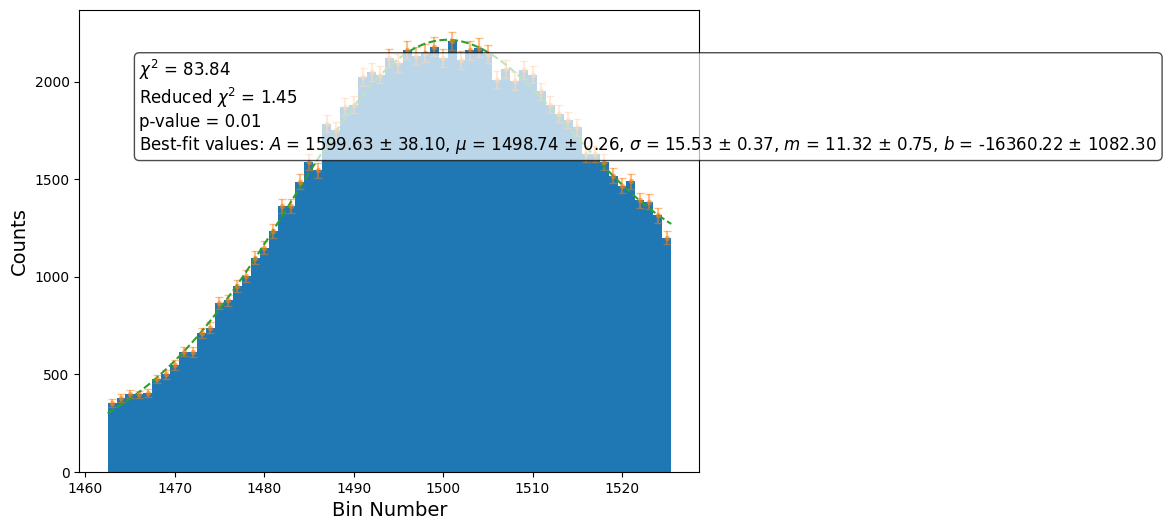

In [ ]:
# Recording calibration TO 35keV
range_beg = 1463
range_end = 1525
data_for_hist = []
for bin_num,counts in enumerate(data):
    if bin_num >= range_beg and bin_num <= range_end:
        try:
            for _ in range(int(counts)):
                data_for_hist.append(bin_num)
        except:
            break
fig, ax = plt.subplots(figsize=(8,6))

bins = np.arange(range_beg - 0.5, range_end + 1.5, 1)
hist_counts,bin_edges = ax.hist(data_for_hist,bins=bins)[:2] 

bin_centers = ((bin_edges[:-1] + bin_edges[1:]) / 2)
hist_uncertainties = [x**(0.5) for x in hist_counts]
ax.errorbar(bin_centers,hist_counts,yerr=hist_uncertainties,fmt = '.',capsize = 3, alpha =0.5)

fit_func = gaussian_plus_linear
initial_guess = [hist_counts.max(),mode(data_for_hist)[0],30,0,0]

popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,initial_guess,sigma=hist_uncertainties, absolute_sigma=True)
chi2_value = 0
for index,bin_center in enumerate(bin_centers):
    chi2_value += (fit_func(bin_center, *popt) - hist_counts[index])**2/hist_uncertainties[index]**2
dof = len(hist_counts) - len(popt)
reduced_chi2 = chi2_value/dof
chi2_prob = chi2.cdf(chi2_value, dof)
p_val = 1 - chi2_prob

overplot_x = np.linspace(range_beg-0.5, range_end+0.5, num=200)
overplot_y = fit_func(overplot_x, *popt)

ax.plot(overplot_x, overplot_y, linestyle='--')
fig.text(
    0.2, 0.8,  # position relative to the figure, not just the axis
    generate_text_string(fit_func,popt,pcov,chi2_value,reduced_chi2,p_val),
    ha='left', va='top',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
)
ax.set_xlabel("Bin Number", fontsize=14)
ax.set_ylabel("Counts", fontsize=14)

ba4_calib[34.9869] = (popt[1], pcov[1][1]**0.5)

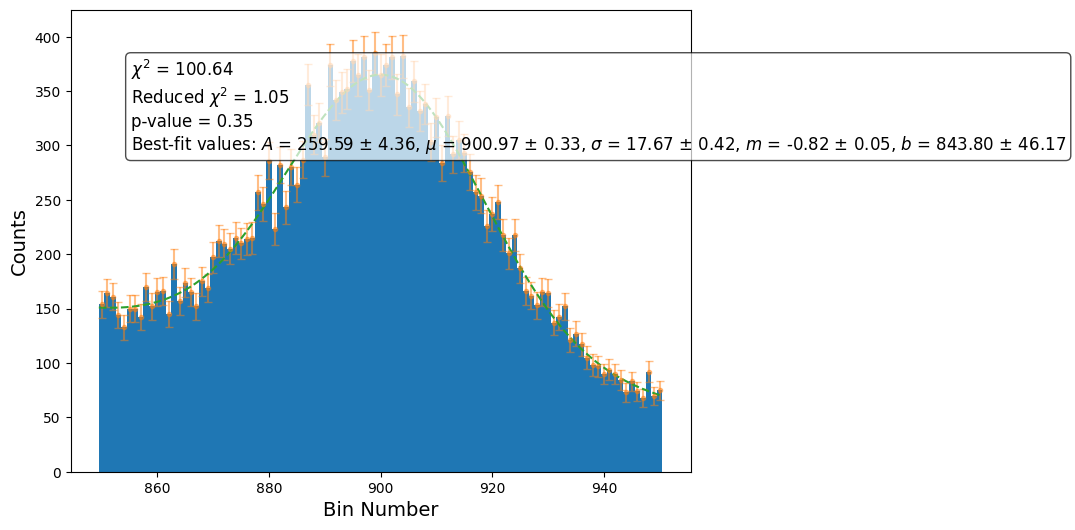

In [ ]:
# Recording calibration TO 20.964 (germanium escape peak)
range_beg = 850
range_end = 950
data_for_hist = []
for bin_num,counts in enumerate(data):
    if bin_num >= range_beg and bin_num <= range_end:
        try:
            for _ in range(int(counts)):
                data_for_hist.append(bin_num)
        except:
            break
fig, ax = plt.subplots(figsize=(8,6))

bins = np.arange(range_beg - 0.5, range_end + 1.5, 1)
hist_counts,bin_edges = ax.hist(data_for_hist,bins=bins)[:2] 

bin_centers = ((bin_edges[:-1] + bin_edges[1:]) / 2)
hist_uncertainties = [x**(0.5) for x in hist_counts]
ax.errorbar(bin_centers,hist_counts,yerr=hist_uncertainties,fmt = '.',capsize = 3, alpha =0.5)

fit_func = gaussian_plus_linear
initial_guess = [hist_counts.max(),mode(data_for_hist)[0],30,0,0]

popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,initial_guess,sigma=hist_uncertainties, absolute_sigma=True)
chi2_value = 0
for index,bin_center in enumerate(bin_centers):
    chi2_value += (fit_func(bin_center, *popt) - hist_counts[index])**2/hist_uncertainties[index]**2
dof = len(hist_counts) - len(popt)
reduced_chi2 = chi2_value/dof
chi2_prob = chi2.cdf(chi2_value, dof)
p_val = 1 - chi2_prob

overplot_x = np.linspace(range_beg-0.5, range_end+0.5, num=200)
overplot_y = fit_func(overplot_x, *popt)

ax.plot(overplot_x, overplot_y, linestyle='--')
fig.text(
    0.2, 0.8,  # position relative to the figure, not just the axis
    generate_text_string(fit_func,popt,pcov,chi2_value,reduced_chi2,p_val),
    ha='left', va='top',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
)
ax.set_xlabel("Bin Number", fontsize=14)
ax.set_ylabel("Counts", fontsize=14)

ba4_calib[20.964] = (popt[1], pcov[1][1]**0.5)

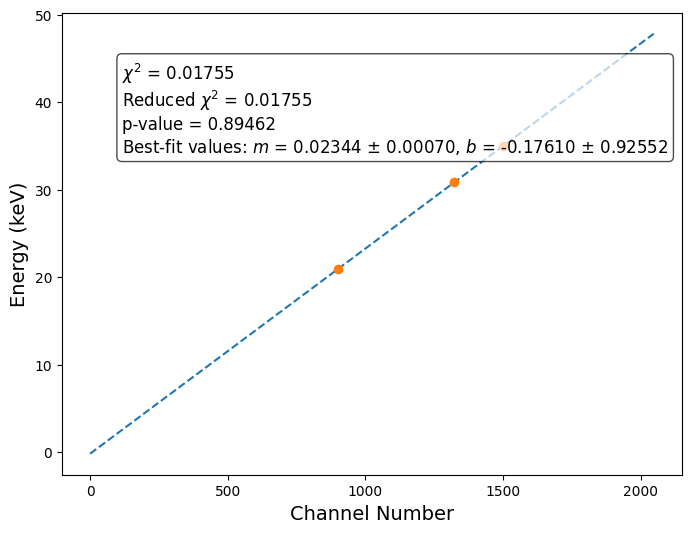

In [ ]:
# Finding linear calibration fit
fit_func = linear
ba4_calib_data_np = np.array([[key,*value] for key,value in ba4_calib.items()])
channel_nums = ba4_calib_data_np[:,1]
energies = ba4_calib_data_np[:,0]
energy_errs = ba4_calib_data_np[:,2]

popt, pcov = curve_fit(fit_func,channel_nums,energies,[0,0],sigma=ba4_calib_data_np[:,2], absolute_sigma=True)

chi2_value = np.sum(((fit_func(channel_nums, *popt) - energies) / energy_errs) ** 2)
dof = len(energies) - len(popt)
reduced_chi2 = chi2_value / dof
chi2_prob = chi2.cdf(chi2_value, dof)
p_val = 1 - chi2_prob


overplot_x = np.linspace(0, 2048, num=200)
overplot_y = linear(overplot_x, *popt)

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(overplot_x, overplot_y, linestyle='--')
ax.errorbar(channel_nums,energies, yerr = ba4_calib_data_np[:,2],fmt = 'o')
ax.set_xlabel("Channel Number", fontsize=14)
ax.set_ylabel("Energy (keV)", fontsize=14)
fig.text(
    0.2, 0.8,  # position relative to the figure, not just the axis
    generate_text_string(fit_func,popt,pcov,chi2_value,reduced_chi2,p_val,precision = 5),
    ha='left', va='top',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
)

ba4_calib_val = popt
ba4_calib_val_err = [pcov[0][0]**0.5, pcov[1][1]**0.5, pcov[0][1]]

<BarContainer object of 2048 artists>

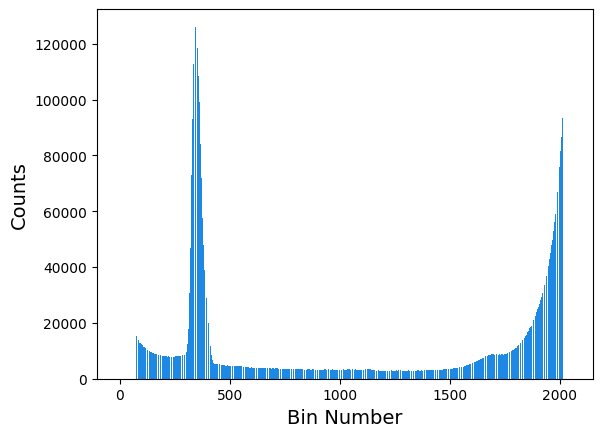

In [ ]:
cu1 = "copper long integ\\copper_long_integ_267_x_ray_spectra_last.Spe"
data = np.genfromtxt(cu1, delimiter='\n', skip_header=12)
plt.xlabel("Bin Number", fontsize=14)
plt.ylabel("Counts", fontsize=14)
plt.bar(range(2048),data[:2048], color = '#1E88E5')

In [ ]:
# # Finding optimal range for Copper, 8 kev peaks
# # Candidate fit ranges (tuples of (start, end))
# candidate_ranges = generate_candidate_ranges(320, 375,bound = 15, step_size= 3)
# # Candidate models and their initial guesses
# candidate_models = [
#     (gaussian, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10]),
#     (gaussian_plus_linear, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10, 0, 0]),
#     (gaussian_plus_constant, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10, 0])
#     # (two_gaussians, lambda counts, bins: [max(counts), bins[np.argmax(counts)], 10, max(counts)/2, bins[np.argmax(counts)]+15, 10]),
#     # (two_gaussians_plus_linear, lambda counts, bins: [max(counts)/2, bins[np.argmax(counts)], 10, max(counts)/2, bins[np.argmax(counts)]+15, 10, 0,0])
# ]

# results = []

# for fit_range in candidate_ranges:
#     # Prepare histogram for this range
#     data_for_hist = []
#     for bin_num, counts in enumerate(data):
#         if fit_range[0] <= bin_num <= fit_range[1]:
#             try:
#                 for _ in range(int(counts)):
#                     data_for_hist.append(bin_num)
#             except Exception:
#                 break
#     bins = np.arange(fit_range[0] - 0.5, fit_range[1] + 1.5, 1)
#     hist_counts, bin_edges = np.histogram(data_for_hist, bins=bins)
#     bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

#     for model_func, guess_func in candidate_models:
#         try:
#             initial_guess = guess_func(hist_counts, bin_centers)
#             fit_result = fit_peak_with_residuals(
#                 data=data,
#                 range_beg=fit_range[0],
#                 range_end=fit_range[1],
#                 fit_func=model_func,
#                 initial_guess=initial_guess,
#                 xlabel="Bin Number",
#                 ylabel="Counts",
#                 title=f"Range {fit_range}, Model {model_func.__name__}",
#                 annotate_fit=False  # We'll annotate only the best fit
#             )
#             results.append({
#                 "range": fit_range,
#                 "model": model_func.__name__,
#                 "fit_result": fit_result
#             })
#         except Exception as e:
#             print(f"Fit failed for range {fit_range} and model {model_func.__name__}: {e}")

# # Select the best fit (lowest reduced chi²)
# best = min(results, key=lambda r: r["fit_result"]["reduced_chi2"])
# print(f"Best fit: Range {best['range']}, Model {best['model']}, Reduced chi² = {best['fit_result']['reduced_chi2']:.2f}")

# # Plot the best fit with annotation
# results = fit_peak_with_residuals(
#     data=data,
#     range_beg=best["range"][0],
#     range_end=best["range"][1],
#     fit_func=eval(best["model"]),
#     initial_guess=best["fit_result"]["popt"],
#     xlabel="Bin Number",
#     ylabel="Counts",
#     title=f"Best Fit: Range {best['range']}, Model {best['model']}",
#     annotate_fit=True,
#     display_plot = True
# )
# popt = results["popt"]

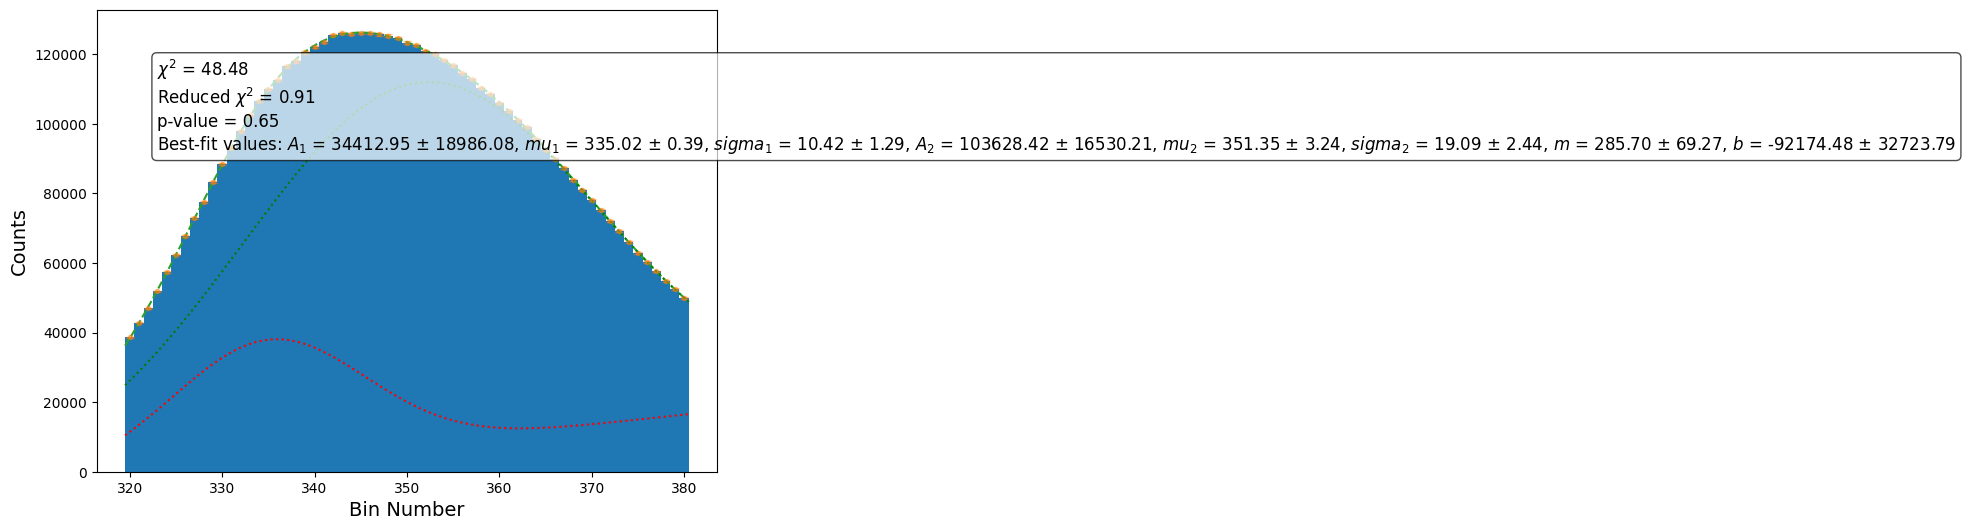

In [ ]:
# Recording copper x ray lines
range_beg = 320
range_end = 380
data_for_hist = []
for bin_num,counts in enumerate(data):
    if bin_num >= range_beg and bin_num <= range_end:
        try:
            for _ in range(int(counts)):
                data_for_hist.append(bin_num)
        except:
            break
fig, ax = plt.subplots(figsize=(8,6))

bins = np.arange(range_beg - 0.5, range_end + 1.5, 1)
hist_counts,bin_edges = ax.hist(data_for_hist,bins=bins)[:2] 

bin_centers = ((bin_edges[:-1] + bin_edges[1:]) / 2)
hist_uncertainties = [x**(0.5) for x in hist_counts]
# inputting 1 instead of 0 for histogram bins with 0 counts to fix divide by 0 error.
had_to_fix_div_by_zero = False
for i in range(len(hist_uncertainties)):
    if hist_uncertainties[i] == 0:
        hist_uncertainties[i] = 1
        had_to_fix_div_by_zero = True
ax.errorbar(bin_centers,hist_counts,yerr=hist_uncertainties,fmt = '.',capsize = 3, alpha = 0.5)

initial_guess = [hist_counts.max(),mode(data_for_hist)[0],10, 40000,mode(data_for_hist)[0]-1,20,   0,0]
fit_func = two_gaussians_plus_linear

popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,initial_guess,sigma=hist_uncertainties, absolute_sigma=True)
chi2_value = 0
for index,bin_center in enumerate(bin_centers):
    chi2_value += (fit_func(bin_center, *popt) - hist_counts[index])**2/hist_uncertainties[index]**2
dof = len(hist_counts) - len(popt)
reduced_chi2 = chi2_value/dof
chi2_prob = chi2.cdf(chi2_value, dof)
p_val = 1 - chi2_prob

overplot_x = np.linspace(range_beg-0.5, range_end+0.5, num=200)
overplot_y = fit_func(overplot_x, *popt)

# Individual Gaussians with linear background
linear_bg = popt[6] * overplot_x + popt[7]
gauss1_with_bg = popt[0] * np.exp(-0.5 * ((overplot_x - popt[1]) / popt[2]) ** 2) + linear_bg
gauss2_with_bg = popt[3] * np.exp(-0.5 * ((overplot_x - popt[4]) / popt[5]) ** 2) + linear_bg

ax.plot(overplot_x, overplot_y, linestyle='--', label='Total Fit')
ax.plot(overplot_x, gauss1_with_bg, linestyle=':', color='red', label='Gaussian 1 + linear')
ax.plot(overplot_x, gauss2_with_bg, linestyle=':', color='green', label='Gaussian 2 + linear')

fig.text(
    0.2, 0.8,  # position relative to the figure, not just the axis
    generate_text_string(fit_func,popt,pcov,chi2_value,reduced_chi2,p_val),
    ha='left', va='top',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
)
ax.set_xlabel("Bin Number", fontsize=14)
ax.set_ylabel("Counts", fontsize=14)

# moseleys_lines[("Cu","KL3")] = (get_ener_at_bin(popt[1],*ba4_calib_val), calc_ener_err(ba4_calib_val, ba4_calib_val_err, pcov,popt,1))
moseleys_lines[("Cu","KL3")] = (get_ener_at_bin(popt[4],*ba4_calib_val), calc_ener_err(ba4_calib_val, ba4_calib_val_err, pcov,popt,4))

In [ ]:
# # Recording copper x ray lines
# range_beg = 385
# range_end = 420
# data_for_hist = []
# for bin_num,counts in enumerate(data):
#     if bin_num >= range_beg and bin_num <= range_end:
#         try:
#             for _ in range(int(counts)):
#                 data_for_hist.append(bin_num)
#         except:
#             break
# fig, ax = plt.subplots(figsize=(8,6))

# bins = np.arange(range_beg - 0.5, range_end + 1.5, 1)
# hist_counts,bin_edges = ax.hist(data_for_hist,bins=bins)[:2] 

# bin_centers = ((bin_edges[:-1] + bin_edges[1:]) / 2)
# hist_uncertainties = [x**(0.5) for x in hist_counts]
# # inputting 1 instead of 0 for histogram bins with 0 counts to fix divide by 0 error.
# had_to_fix_div_by_zero = False
# for i in range(len(hist_uncertainties)):
#     if hist_uncertainties[i] == 0:
#         hist_uncertainties[i] = 1
#         had_to_fix_div_by_zero = True
# ax.errorbar(bin_centers,hist_counts,yerr=hist_uncertainties,fmt = '.',capsize = 3, alpha = 0.5)

# initial_guess = [30000,390,10,   0,0]
# fit_func = gaussian_plus_linear

# popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,initial_guess,sigma=hist_uncertainties, absolute_sigma=True)
# chi2_value = 0
# for index,bin_center in enumerate(bin_centers):
#     chi2_value += (fit_func(bin_center, *popt) - hist_counts[index])**2/hist_uncertainties[index]**2
# dof = len(hist_counts) - len(popt)
# reduced_chi2 = chi2_value/dof
# chi2_prob = chi2.cdf(chi2_value, dof)
# p_val = 1 - chi2_prob

# overplot_x = np.linspace(range_beg-0.5, range_end+0.5, num=200)
# overplot_y = fit_func(overplot_x, *popt)

# ax.plot(overplot_x, overplot_y, linestyle='--', label='Total Fit')

# # Individual Gaussians with linear background
# linear_bg = popt[3] * overplot_x + popt[4]
# gauss1_with_bg = popt[0] * np.exp(-0.5 * ((overplot_x - popt[1]) / popt[2]) ** 2) + linear_bg

# ax.plot(overplot_x, overplot_y, linestyle='--', label='Total Fit')
# ax.plot(overplot_x, gauss1_with_bg, linestyle=':', color='red', label='Gaussian 1 + linear')
# ax.plot(overplot_x, linear_bg, linestyle=':', color='green', label='Linear')

# fig.text(
#     0.2, 0.8,  # position relative to the figure, not just the axis
#     generate_text_string(fit_func,popt,pcov,chi2_value,reduced_chi2,p_val),
#     ha='left', va='top',
#     fontsize=12,
#     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
# )
# ax.set_xlabel("Bin Number", fontsize=14)
# ax.set_ylabel("Counts", fontsize=14)

# # moseleys_lines[("Cu","KL3")] = (get_ener_at_bin(popt[1],*ba4_calib_val), calc_ener_err(ba4_calib_val, ba4_calib_val_err, pcov,popt,1))
# # moseleys_lines[("Cu","KM3")] = (get_ener_at_bin(popt[4],*ba4_calib_val), calc_ener_err(ba4_calib_val, ba4_calib_val_err, pcov,popt,4))

## 9-29 Moseley's barium mid gain 2, molybdenum

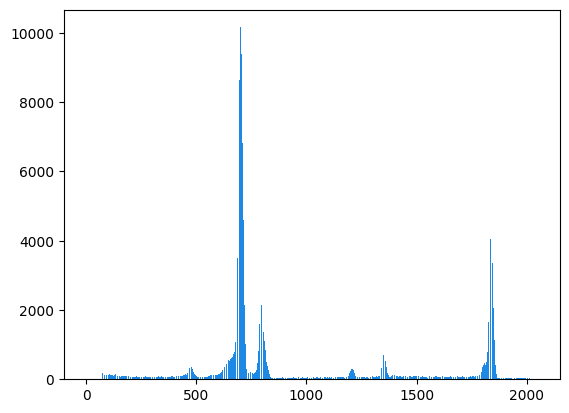

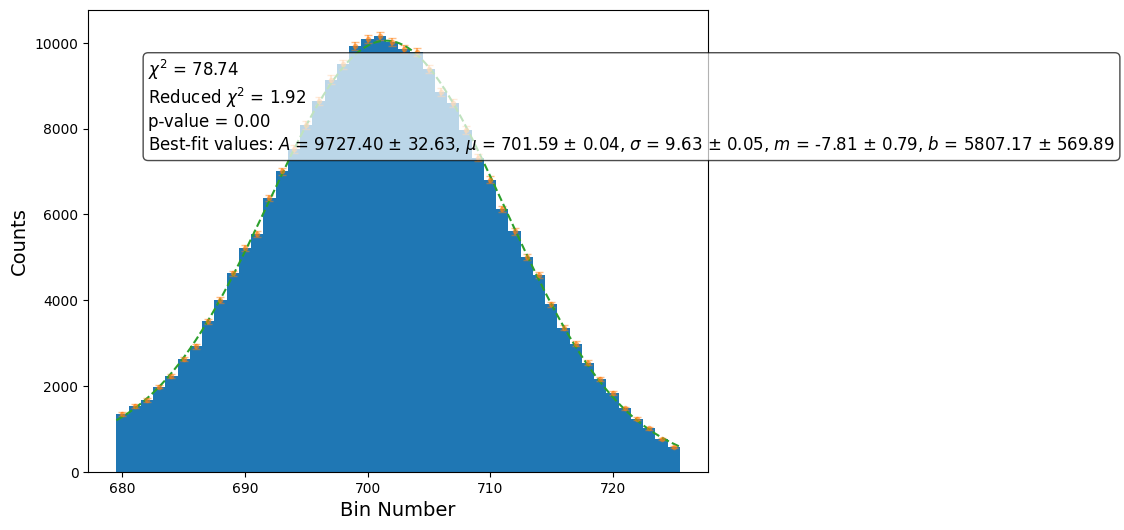

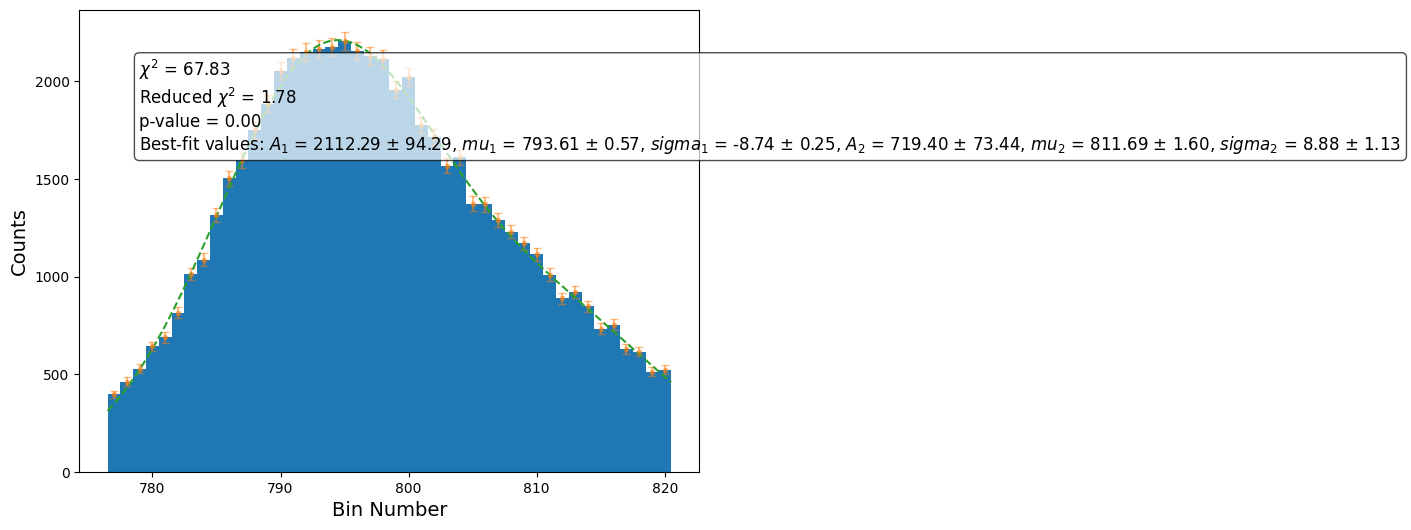

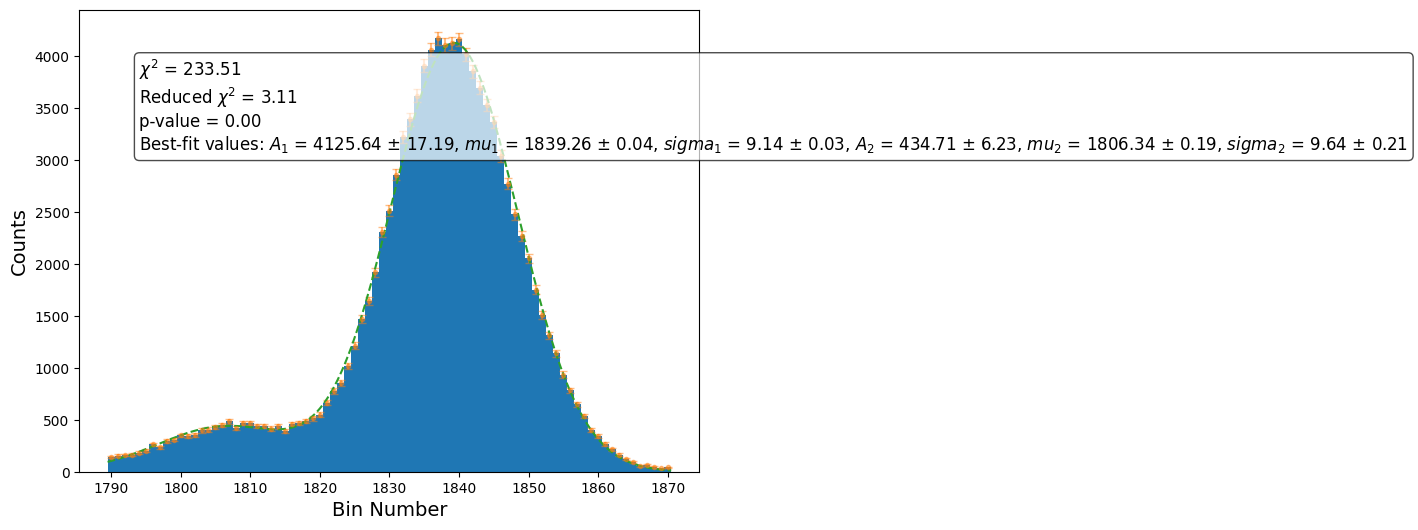

In [ ]:
# lines in this spectra should be at ~31 keV and ~ 35 keV
ba6 = "9_29\\barium_mid_gain_calibration_x_ray_spectra_9_29.Spe"
ba6_calib = {}

# CALIBRATING TO 31keV
range_beg = 680
range_end = 725
data = np.genfromtxt(ba6, delimiter='\n', skip_header=12)

plt.bar(range(2048),data[:2048], color = '#1E88E5')

data_for_hist = []
for bin_num,counts in enumerate(data):
    if bin_num >= range_beg and bin_num <= range_end:
        try:
            for _ in range(int(counts)):
                data_for_hist.append(bin_num)
        except:
            break
fig, ax = plt.subplots(figsize=(8,6))

bins = np.arange(range_beg - 0.5, range_end + 1.5, 1)
hist_counts,bin_edges = ax.hist(data_for_hist,bins=bins)[:2] 
bin_centers = ((bin_edges[:-1] + bin_edges[1:]) / 2)
hist_uncertainties = [x**(0.5) for x in hist_counts]

# inputting 1 instead of 0 for histogram bins with 0 counts to fix divide by 0 error.
had_to_fix_div_by_zero = False
for i in range(len(hist_uncertainties)):
    if hist_uncertainties[i] == 0:
        hist_uncertainties[i] = 1
        had_to_fix_div_by_zero = True
ax.errorbar(bin_centers, hist_counts, yerr=hist_uncertainties, fmt = '.', capsize = 3, alpha = 0.5)

initial_guess = [hist_counts.max(),mode(data_for_hist)[0],20,0,0]
fit_func = gaussian_plus_linear

popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,initial_guess,sigma=hist_uncertainties, absolute_sigma=True)
if had_to_fix_div_by_zero:
    popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,popt,sigma=[popt[1]**0.5]*len(hist_counts), absolute_sigma=True)
chi2_value = 0
for index,bin_center in enumerate(bin_centers):
    chi2_value += (fit_func(bin_center, *popt) - hist_counts[index])**2/hist_uncertainties[index]**2
dof = len(hist_counts) - len(popt)
reduced_chi2 = chi2_value/dof
chi2_prob = chi2.cdf(chi2_value, dof)
p_val = 1 - chi2_prob

overplot_x = np.linspace(range_beg-0.5, range_end+0.5, num=200)
overplot_y = fit_func(overplot_x, *popt)

ax.plot(overplot_x, overplot_y, linestyle='--')
fig.text(
    0.2, 0.8,  # position relative to the figure, not just the axis
    generate_text_string(fit_func,popt,pcov,chi2_value,reduced_chi2,p_val),
    ha='left', va='top',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
)
ax.set_xlabel("Bin Number", fontsize=14)
ax.set_ylabel("Counts", fontsize=14)
ba6_calib[30.85] = (popt[1], pcov[1][1]**0.5)

#--------------------------------------------------------------------------------------------------------------------

# CALIBRATING TO 35keV # Two gaussians for this peak makes sense because at around this energy there are the KM lines and KN lines just a few keV apart
range_beg = 777
range_end = 820
data_for_hist = []
for bin_num,counts in enumerate(data):
    if bin_num >= range_beg and bin_num <= range_end:
        try:
            for _ in range(int(counts)):
                data_for_hist.append(bin_num)
        except:
            break
fig, ax = plt.subplots(figsize=(8,6))

bins = np.arange(range_beg - 0.5, range_end + 1.5, 1)
hist_counts,bin_edges = ax.hist(data_for_hist,bins=bins)[:2] 

bin_centers = ((bin_edges[:-1] + bin_edges[1:]) / 2)
hist_uncertainties = [x**(0.5) for x in hist_counts]
# inputting 1 instead of 0 for histogram bins with 0 counts to fix divide by 0 error.
had_to_fix_div_by_zero = False
for i in range(len(hist_uncertainties)):
    if hist_uncertainties[i] == 0:
        hist_uncertainties[i] = 1
        had_to_fix_div_by_zero = True
ax.errorbar(bin_centers, hist_counts, yerr=hist_uncertainties, fmt = '.', capsize = 3, alpha = 0.5)

initial_guess = [hist_counts.max(),mode(data_for_hist)[0],30,   100,mode(data_for_hist)[0]+10,30]
fit_func = two_gaussians

popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,initial_guess,sigma=hist_uncertainties, absolute_sigma=True)
chi2_value = 0
for index,bin_center in enumerate(bin_centers):
    chi2_value += (fit_func(bin_center, *popt) - hist_counts[index])**2/hist_uncertainties[index]**2
dof = len(hist_counts) - len(popt)
reduced_chi2 = chi2_value/dof
chi2_prob = chi2.cdf(chi2_value, dof)
p_val = 1 - chi2_prob

overplot_x = np.linspace(range_beg-0.5, range_end+0.5, num=200)
overplot_y = fit_func(overplot_x, *popt)

ax.plot(overplot_x, overplot_y, linestyle='--')
fig.text(
    0.2, 0.8,  # position relative to the figure, not just the axis
    generate_text_string(fit_func,popt,pcov,chi2_value,reduced_chi2,p_val),
    ha='left', va='top',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
)
ax.set_xlabel("Bin Number", fontsize=14)
ax.set_ylabel("Counts", fontsize=14)
ba6_calib[34.9869] = (popt[1], pcov[1][1]**0.5)

#--------------------------------------------------------------------------------------------------------------------

# CALIBRATING TO 81keV This should just be one gamma ray peak
range_beg = 1790
range_end = 1870
data_for_hist = []
for bin_num,counts in enumerate(data):
    if bin_num >= range_beg and bin_num <= range_end:
        try:
            for _ in range(int(counts)):
                data_for_hist.append(bin_num)
        except:
            break
fig, ax = plt.subplots(figsize=(8,6))

bins = np.arange(range_beg - 0.5, range_end + 1.5, 1)
hist_counts,bin_edges = ax.hist(data_for_hist,bins=bins)[:2] 

bin_centers = ((bin_edges[:-1] + bin_edges[1:]) / 2)
hist_uncertainties = [x**(0.5) for x in hist_counts]
# inputting 1 instead of 0 for histogram bins with 0 counts to fix divide by 0 error.
had_to_fix_div_by_zero = False
for i in range(len(hist_uncertainties)):
    if hist_uncertainties[i] == 0:
        hist_uncertainties[i] = 1
        had_to_fix_div_by_zero = True
ax.errorbar(bin_centers, hist_counts, yerr=hist_uncertainties, fmt = '.', capsize = 3, alpha = 0.5)

initial_guess = [hist_counts.max(),mode(data_for_hist)[0],10,400,1800,15]
fit_func = two_gaussians

popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,initial_guess,sigma=hist_uncertainties, absolute_sigma=True)
chi2_value = 0
for index,bin_center in enumerate(bin_centers):
    chi2_value += (fit_func(bin_center, *popt) - hist_counts[index])**2/hist_uncertainties[index]**2
dof = len(hist_counts) - len(popt)
reduced_chi2 = chi2_value/dof
chi2_prob = chi2.cdf(chi2_value, dof)
p_val = 1 - chi2_prob

overplot_x = np.linspace(range_beg-0.5, range_end+0.5, num=200)
overplot_y = fit_func(overplot_x, *popt)

ax.plot(overplot_x, overplot_y, linestyle='--')
fig.text(
    0.2, 0.8,  # position relative to the figure, not just the axis
    generate_text_string(fit_func,popt,pcov,chi2_value,reduced_chi2,p_val),
    ha='left', va='top',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
)
ax.set_xlabel("Bin Number", fontsize=14)
ax.set_ylabel("Counts", fontsize=14)
ba6_calib[81] = (popt[1], pcov[1][1]**0.5)

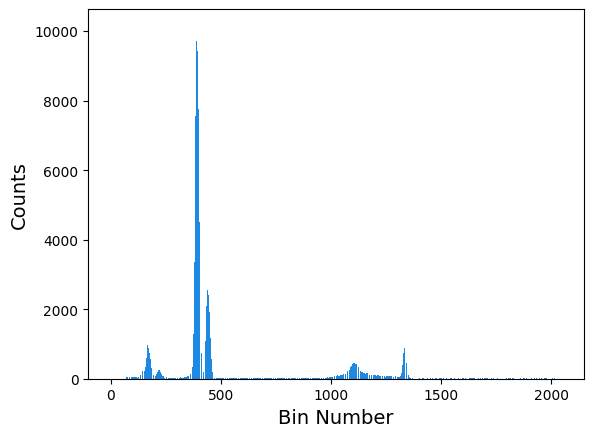

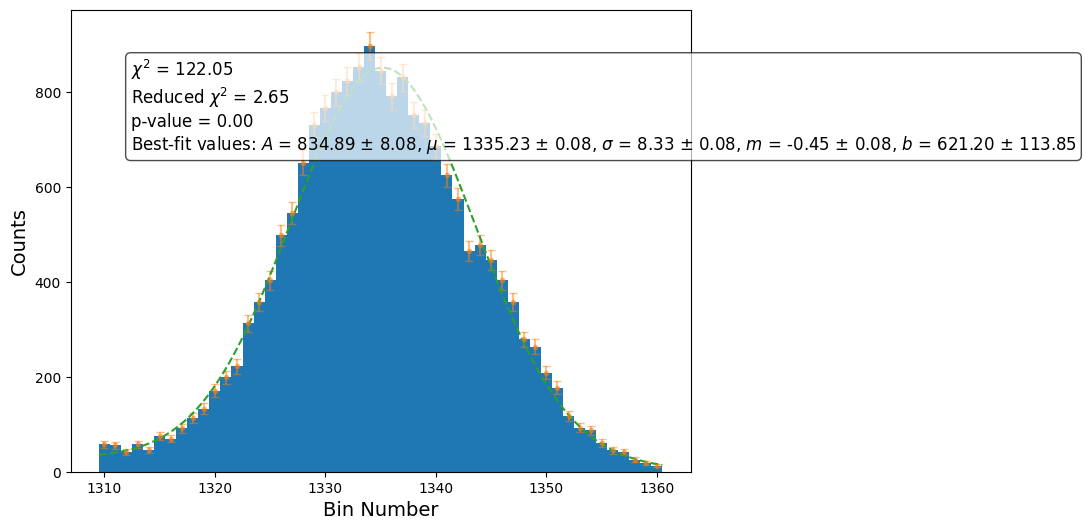

In [ ]:
mo1 = "9_29\\molybdenum_x_ray_spectra_2_9_29.Spe"
data = np.genfromtxt(mo1, delimiter='\n', skip_header=12)
plt.xlabel("Bin Number", fontsize=14)
plt.ylabel("Counts", fontsize=14)
plt.bar(range(2048),data[:2048], color = '#1E88E5')

#--------------------------------------------------------------------------------------------------------------------
# Calibration with 59.5 keV line from Americium gamma ray source

range_beg = 1310
range_end = 1360
data_for_hist = []
for bin_num,counts in enumerate(data):
    if bin_num >= range_beg and bin_num <= range_end:
        try:
            for _ in range(int(counts)):
                data_for_hist.append(bin_num)
        except:
            break
fig, ax = plt.subplots(figsize=(8,6))

bins = np.arange(range_beg - 0.5, range_end + 1.5, 1)
hist_counts,bin_edges = ax.hist(data_for_hist,bins=bins)[:2] 

bin_centers = ((bin_edges[:-1] + bin_edges[1:]) / 2)
hist_uncertainties = [x**(0.5) for x in hist_counts]
# inputting 1 instead of 0 for histogram bins with 0 counts to fix divide by 0 error.
had_to_fix_div_by_zero = False
for i in range(len(hist_uncertainties)):
    if hist_uncertainties[i] == 0:
        hist_uncertainties[i] = 1
        had_to_fix_div_by_zero = True
ax.errorbar(bin_centers, hist_counts, yerr=hist_uncertainties, fmt = '.', capsize = 3, alpha = 0.5)

initial_guess = [hist_counts.max(),mode(data_for_hist)[0],10, 0,0]
fit_func = gaussian_plus_linear

popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,initial_guess,sigma=hist_uncertainties, absolute_sigma=True)
if had_to_fix_div_by_zero:
    popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,popt,sigma=[popt[1]**0.5]*len(hist_counts), absolute_sigma=True)
chi2_value = 0
for index,bin_center in enumerate(bin_centers):
    chi2_value += (fit_func(bin_center, *popt) - hist_counts[index])**2/hist_uncertainties[index]**2
dof = len(hist_counts) - len(popt)
reduced_chi2 = chi2_value/dof
chi2_prob = chi2.cdf(chi2_value, dof)
p_val = 1 - chi2_prob

overplot_x = np.linspace(range_beg-0.5, range_end+0.5, num=200)
overplot_y = fit_func(overplot_x, *popt)

ax.plot(overplot_x, overplot_y, linestyle='--')
fig.text(
    0.2, 0.8,  # position relative to the figure, not just the axis
    generate_text_string(fit_func,popt,pcov,chi2_value,reduced_chi2,p_val),
    ha='left', va='top',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
)
ax.set_xlabel("Bin Number", fontsize=14)
ax.set_ylabel("Counts", fontsize=14)
ba6_calib[59.5] = (popt[1], pcov[1][1]**0.5)

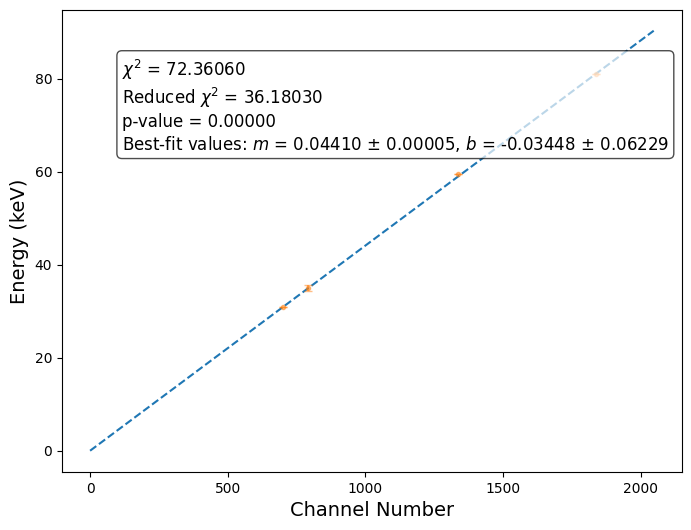

In [ ]:
fit_func = linear
ba6_calib_data_np = np.array([[key,*value] for key,value in ba6_calib.items()])
channel_nums = ba6_calib_data_np[:,1]
energies = ba6_calib_data_np[:,0]
energy_errs = ba6_calib_data_np[:,2]

popt, pcov = curve_fit(fit_func,channel_nums,energies,[0,0],sigma=ba6_calib_data_np[:,2], absolute_sigma=True)

chi2_value = np.sum(((fit_func(channel_nums, *popt) - energies) / energy_errs) ** 2)
dof = len(energies) - len(popt)
reduced_chi2 = chi2_value / dof
chi2_prob = chi2.cdf(chi2_value, dof)
p_val = 1 - chi2_prob

overplot_x = np.linspace(0, 2048, num=200)
overplot_y = linear(overplot_x, *popt)

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(overplot_x, overplot_y, linestyle='--')
ax.errorbar(channel_nums,energies, yerr = ba6_calib_data_np[:,2],fmt = '.', capsize = 3, alpha = 0.5)
ax.set_xlabel("Channel Number", fontsize=14)
ax.set_ylabel("Energy (keV)", fontsize=14)
fig.text(
    0.2, 0.8,  # position relative to the figure, not just the axis
    generate_text_string(fit_func,popt,pcov,chi2_value,reduced_chi2,p_val,precision = 5),
    ha='left', va='top',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
)

ba6_calib_val = popt
ba6_calib_val_err = [pcov[0][0]**0.5, pcov[1][1]**0.5, pcov[0][1]]

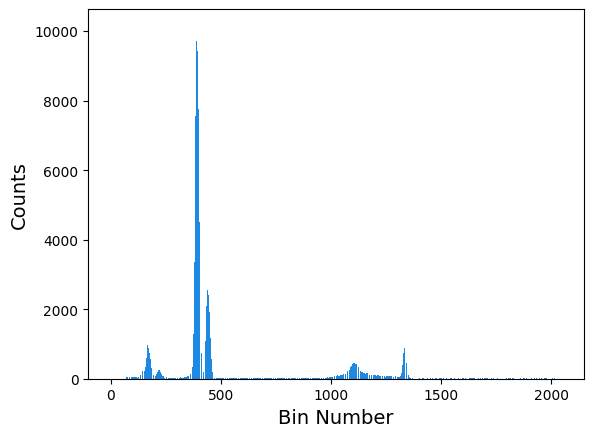

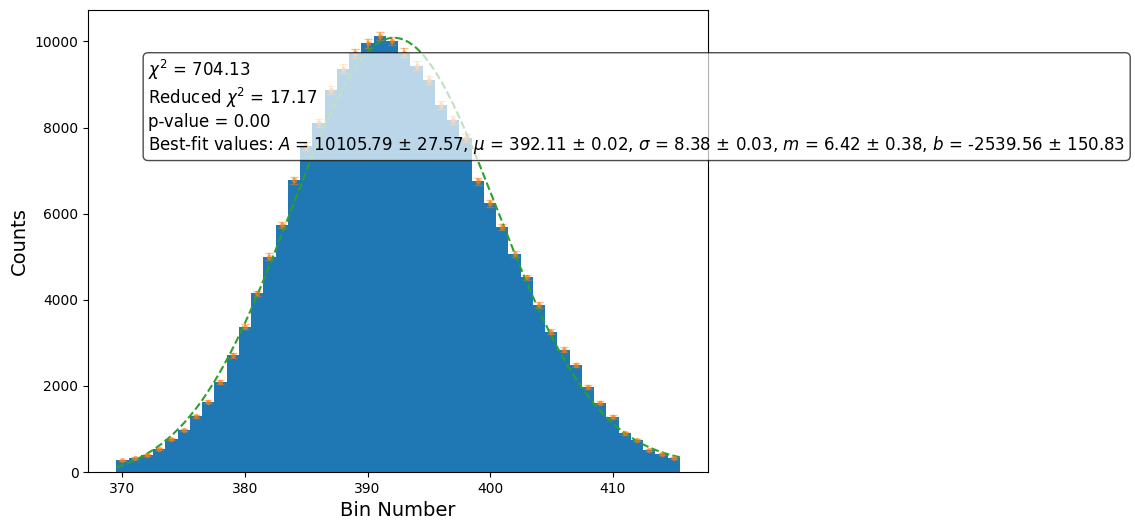

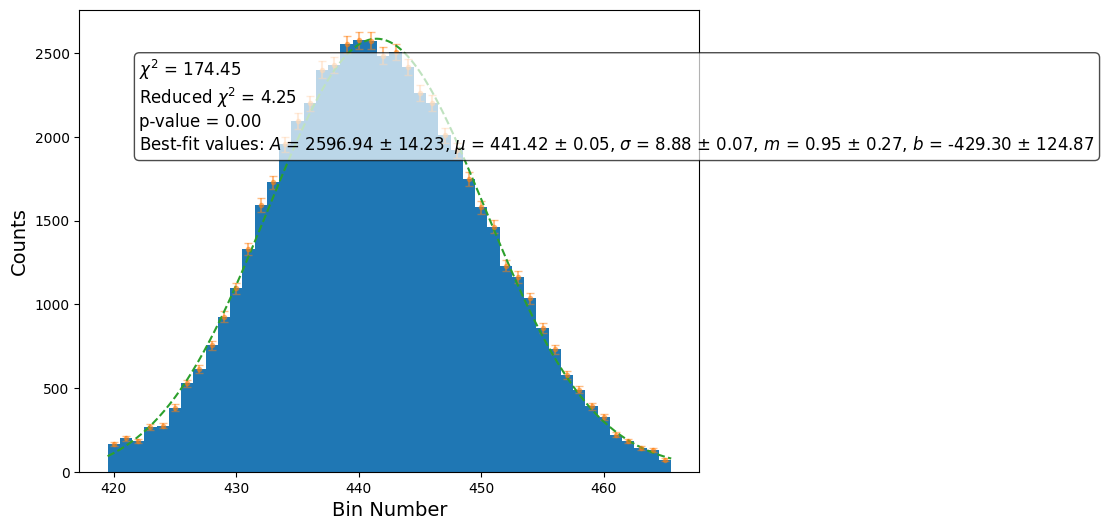

In [ ]:
data = np.genfromtxt(mo1, delimiter='\n', skip_header=12)
plt.xlabel("Bin Number", fontsize=14)
plt.ylabel("Counts", fontsize=14)
plt.bar(range(2048),data[:2048], color = '#1E88E5')

#--------------------------------------------------------------------------------------------------------------------

range_beg = 370
range_end = 415
data_for_hist = []
for bin_num,counts in enumerate(data):
    if bin_num >= range_beg and bin_num <= range_end:
        try:
            for _ in range(int(counts)):
                data_for_hist.append(bin_num)
        except:
            break
fig, ax = plt.subplots(figsize=(8,6))

bins = np.arange(range_beg - 0.5, range_end + 1.5, 1)
hist_counts,bin_edges = ax.hist(data_for_hist,bins=bins)[:2] 

bin_centers = ((bin_edges[:-1] + bin_edges[1:]) / 2)
hist_uncertainties = [x**(0.5) for x in hist_counts]
# inputting 1 instead of 0 for histogram bins with 0 counts to fix divide by 0 error.
had_to_fix_div_by_zero = False
for i in range(len(hist_uncertainties)):
    if hist_uncertainties[i] == 0:
        hist_uncertainties[i] = 1
        had_to_fix_div_by_zero = True
ax.errorbar(bin_centers, hist_counts, yerr=hist_uncertainties, fmt = '.', capsize = 3, alpha = 0.5)

initial_guess = [hist_counts.max(),mode(data_for_hist)[0],10, 0,0]
fit_func = gaussian_plus_linear

popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,initial_guess,sigma=hist_uncertainties, absolute_sigma=True)
if had_to_fix_div_by_zero:
    popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,popt,sigma=[popt[1]**0.5]*len(hist_counts), absolute_sigma=True)
chi2_value = 0
for index,bin_center in enumerate(bin_centers):
    chi2_value += (fit_func(bin_center, *popt) - hist_counts[index])**2/hist_uncertainties[index]**2
dof = len(hist_counts) - len(popt)
reduced_chi2 = chi2_value/dof
chi2_prob = chi2.cdf(chi2_value, dof)
p_val = 1 - chi2_prob

overplot_x = np.linspace(range_beg-0.5, range_end+0.5, num=200)
overplot_y = fit_func(overplot_x, *popt)

ax.plot(overplot_x, overplot_y, linestyle='--')
fig.text(
    0.2, 0.8,  # position relative to the figure, not just the axis
    generate_text_string(fit_func,popt,pcov,chi2_value,reduced_chi2,p_val),
    ha='left', va='top',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
)
ax.set_xlabel("Bin Number", fontsize=14)
ax.set_ylabel("Counts", fontsize=14)

moseleys_lines[("Mo","KL3")] = (get_ener_at_bin(popt[1],*ba6_calib_val), calc_ener_err(ba6_calib_val, ba6_calib_val_err, pcov,popt,1))

#--------------------------------------------------------------------------------------------------------------------

range_beg = 420
range_end = 465
data_for_hist = []
for bin_num,counts in enumerate(data):
    if bin_num >= range_beg and bin_num <= range_end:
        try:
            for _ in range(int(counts)):
                data_for_hist.append(bin_num)
        except:
            break
fig, ax = plt.subplots(figsize=(8,6))

bins = np.arange(range_beg - 0.5, range_end + 1.5, 1)
hist_counts,bin_edges = ax.hist(data_for_hist,bins=bins)[:2] 

bin_centers = ((bin_edges[:-1] + bin_edges[1:]) / 2)
hist_uncertainties = [x**(0.5) for x in hist_counts]
# inputting 1 instead of 0 for histogram bins with 0 counts to fix divide by 0 error.
had_to_fix_div_by_zero = False
for i in range(len(hist_uncertainties)):
    if hist_uncertainties[i] == 0:
        hist_uncertainties[i] = 1
        had_to_fix_div_by_zero = True
ax.errorbar(bin_centers, hist_counts, yerr=hist_uncertainties, fmt = '.', capsize = 3, alpha = 0.5)

initial_guess = [hist_counts.max(),mode(data_for_hist)[0],10, 0,0]
fit_func = gaussian_plus_linear

popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,initial_guess,sigma=hist_uncertainties, absolute_sigma=True)
if had_to_fix_div_by_zero:
    popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,popt,sigma=[popt[1]**0.5]*len(hist_counts), absolute_sigma=True)
chi2_value = 0
for index,bin_center in enumerate(bin_centers):
    chi2_value += (fit_func(bin_center, *popt) - hist_counts[index])**2/hist_uncertainties[index]**2
dof = len(hist_counts) - len(popt)
reduced_chi2 = chi2_value/dof
chi2_prob = chi2.cdf(chi2_value, dof)
p_val = 1 - chi2_prob

overplot_x = np.linspace(range_beg-0.5, range_end+0.5, num=200)
overplot_y = fit_func(overplot_x, *popt)

ax.plot(overplot_x, overplot_y, linestyle='--')
fig.text(
    0.2, 0.8,  # position relative to the figure, not just the axis
    generate_text_string(fit_func,popt,pcov,chi2_value,reduced_chi2,p_val),
    ha='left', va='top',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
)
ax.set_xlabel("Bin Number", fontsize=14)
ax.set_ylabel("Counts", fontsize=14)

moseleys_lines[("Mo","KM3")] = (get_ener_at_bin(popt[1],*ba6_calib_val), calc_ener_err(ba6_calib_val, ba6_calib_val_err, pcov,popt,1))

## 10-10 Moseley's barium max gain, rubidium

In [ ]:
ba5 = "10_10\\barium_max_gain_calibration_10_10.Spe"
ba5_calib = {}
data = np.genfromtxt(ba5, delimiter='\n', skip_header=12)

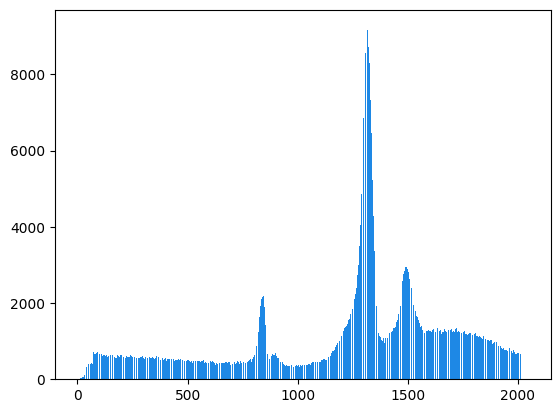

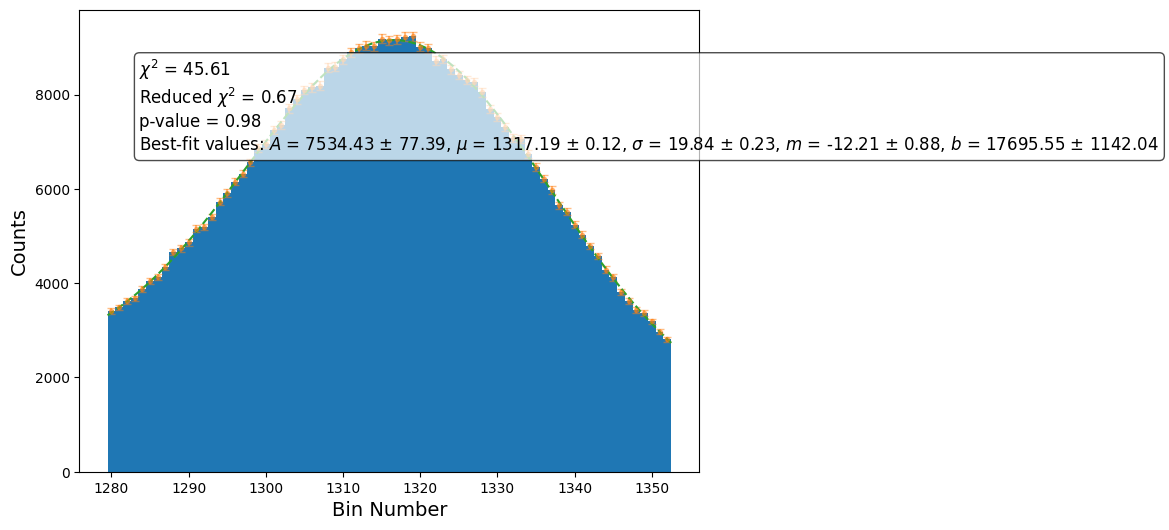

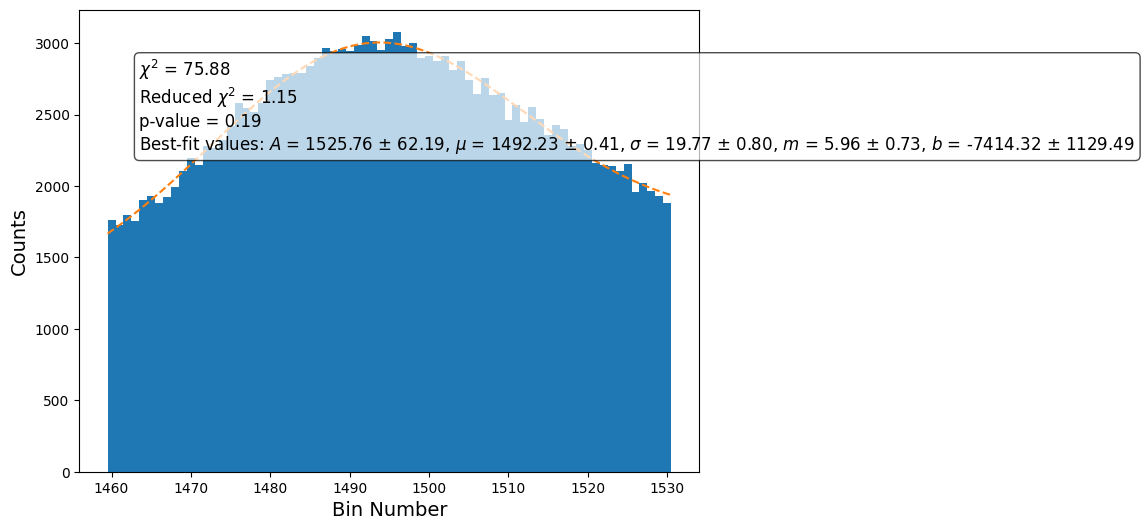

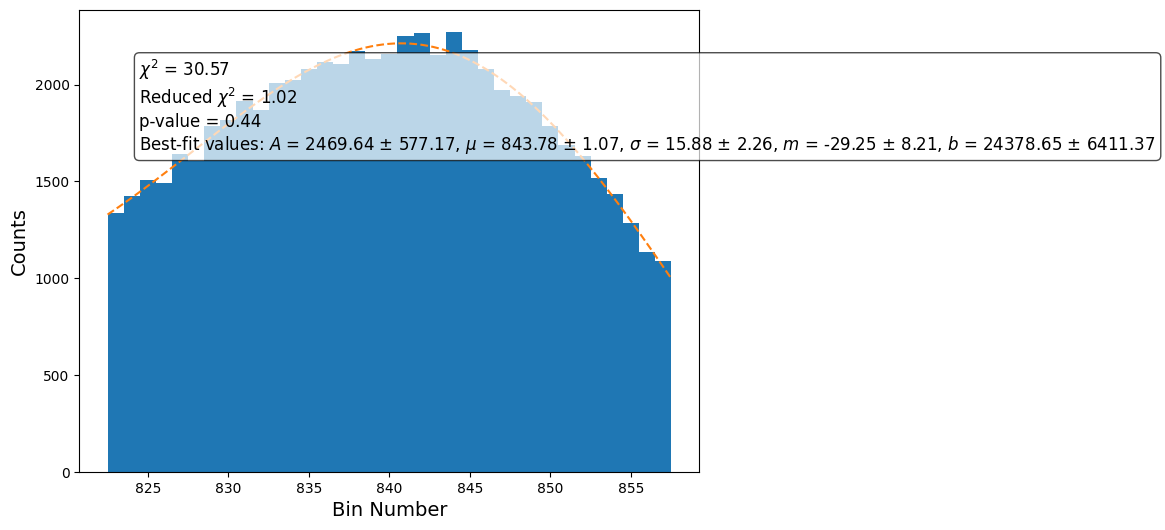

In [ ]:
# CALIBRATING TO 31keV
range_beg = 1280
range_end = 1352

plt.bar(range(2048),data[:2048], color = '#1E88E5')

data_for_hist = []
for bin_num,counts in enumerate(data):
    if bin_num >= range_beg and bin_num <= range_end:
        try:
            for _ in range(int(counts)):
                data_for_hist.append(bin_num)
        except:
            break
fig, ax = plt.subplots(figsize=(8,6))

bins = np.arange(range_beg - 0.5, range_end + 1.5, 1)
hist_counts,bin_edges = ax.hist(data_for_hist,bins=bins)[:2] 

bin_centers = ((bin_edges[:-1] + bin_edges[1:]) / 2)
hist_uncertainties = [x**(0.5) for x in hist_counts]

# inputting 1 instead of 0 for histogram bins with 0 counts to fix divide by 0 error.
had_to_fix_div_by_zero = False
for i in range(len(hist_uncertainties)):
    if hist_uncertainties[i] == 0:
        hist_uncertainties[i] = 1
        had_to_fix_div_by_zero = True
ax.errorbar(bin_centers,hist_counts,yerr=hist_uncertainties,fmt = '.',capsize = 3,alpha = 0.5)

initial_guess = [hist_counts.max(),mode(data_for_hist)[0],20,0,0]
fit_func = gaussian_plus_linear

popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,initial_guess,sigma=hist_uncertainties, absolute_sigma=True)
if had_to_fix_div_by_zero:
    popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,popt,sigma=[popt[1]**0.5]*len(hist_counts), absolute_sigma=True)
chi2_value = 0
for index,bin_center in enumerate(bin_centers):
    chi2_value += (fit_func(bin_center, *popt) - hist_counts[index])**2/hist_uncertainties[index]**2
dof = len(hist_counts) - len(popt)
reduced_chi2 = chi2_value/dof
chi2_prob = chi2.cdf(chi2_value, dof)
p_val = 1 - chi2_prob

overplot_x = np.linspace(range_beg-0.5, range_end+0.5, num=200)
overplot_y = fit_func(overplot_x, *popt)

ax.plot(overplot_x, overplot_y, linestyle='--')
fig.text(
    0.2, 0.8,  # position relative to the figure, not just the axis
    generate_text_string(fit_func,popt,pcov,chi2_value,reduced_chi2,p_val),
    ha='left', va='top',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
)
ax.set_xlabel("Bin Number", fontsize=14)
ax.set_ylabel("Counts", fontsize=14)
ba5_calib[30.85] = (popt[1], pcov[1][1]**0.5)

#-------------------------------------------------------------------------------------------------------------------

# CALIBRATING TO 35keV
range_beg = 1460
range_end = 1530

data_for_hist = []
for bin_num,counts in enumerate(data):
    if bin_num >= range_beg and bin_num <= range_end:
        try:
            for _ in range(int(counts)):
                data_for_hist.append(bin_num)
        except:
            break
fig, ax = plt.subplots(figsize=(8,6))

bins = np.arange(range_beg - 0.5, range_end + 1.5, 1)
hist_counts,bin_edges = ax.hist(data_for_hist,bins=bins)[:2] 

bin_centers = ((bin_edges[:-1] + bin_edges[1:]) / 2)
hist_uncertainties = [x**(0.5) for x in hist_counts]

# ax.errorbar(bin_centers,hist_counts,yerr=hist_uncertainties,fmt = '.',capsize = 3,alpha = 0.5)
# inputting 1 instead of 0 for histogram bins with 0 counts to fix divide by 0 error.
had_to_fix_div_by_zero = False
for i in range(len(hist_uncertainties)):
    if hist_uncertainties[i] == 0:
        hist_uncertainties[i] = 1
        had_to_fix_div_by_zero = True
initial_guess = [hist_counts.max(),mode(data_for_hist)[0],20,0,0]
fit_func = gaussian_plus_linear

popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,initial_guess,sigma=hist_uncertainties, absolute_sigma=True)
if had_to_fix_div_by_zero:
    popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,popt,sigma=[popt[1]**0.5]*len(hist_counts), absolute_sigma=True)
chi2_value = 0
for index,bin_center in enumerate(bin_centers):
    chi2_value += (fit_func(bin_center, *popt) - hist_counts[index])**2/hist_uncertainties[index]**2
dof = len(hist_counts) - len(popt)
reduced_chi2 = chi2_value/dof
chi2_prob = chi2.cdf(chi2_value, dof)
p_val = 1 - chi2_prob

overplot_x = np.linspace(range_beg-0.5, range_end+0.5, num=200)
overplot_y = fit_func(overplot_x, *popt)

ax.plot(overplot_x, overplot_y, linestyle='--')
fig.text(
    0.2, 0.8,  # position relative to the figure, not just the axis
    generate_text_string(fit_func,popt,pcov,chi2_value,reduced_chi2,p_val),
    ha='left', va='top',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
)
ax.set_xlabel("Bin Number", fontsize=14)
ax.set_ylabel("Counts", fontsize=14)
ba5_calib[34.986] = (popt[1], pcov[1][1]**0.5)

#--------------------------------------------------------------------------------------------------------------------
# Calibrating to 20.--- escape peak

range_beg = 823
range_end = 857 

data_for_hist = []
for bin_num,counts in enumerate(data):
    if bin_num >= range_beg and bin_num <= range_end:
        try:
            for _ in range(int(counts)):
                data_for_hist.append(bin_num)
        except:
            break
fig, ax = plt.subplots(figsize=(8,6))

bins = np.arange(range_beg - 0.5, range_end + 1.5, 1)
hist_counts,bin_edges = ax.hist(data_for_hist,bins=bins)[:2] 

bin_centers = ((bin_edges[:-1] + bin_edges[1:]) / 2)
hist_uncertainties = [x**(0.5) for x in hist_counts]

# ax.errorbar(bin_centers,hist_counts,yerr=hist_uncertainties,fmt = '.',capsize = 3,alpha = 0.5)
# inputting 1 instead of 0 for histogram bins with 0 counts to fix divide by 0 error.
had_to_fix_div_by_zero = False
for i in range(len(hist_uncertainties)):
    if hist_uncertainties[i] == 0:
        hist_uncertainties[i] = 1
        had_to_fix_div_by_zero = True
initial_guess = [hist_counts.max(),mode(data_for_hist)[0],20,0,0]
fit_func = gaussian_plus_linear

popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,initial_guess,sigma=hist_uncertainties, absolute_sigma=True)
if had_to_fix_div_by_zero:
    popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,popt,sigma=[popt[1]**0.5]*len(hist_counts), absolute_sigma=True)
chi2_value = 0
for index,bin_center in enumerate(bin_centers):
    chi2_value += (fit_func(bin_center, *popt) - hist_counts[index])**2/hist_uncertainties[index]**2
dof = len(hist_counts) - len(popt)
reduced_chi2 = chi2_value/dof
chi2_prob = chi2.cdf(chi2_value, dof)
p_val = 1 - chi2_prob

overplot_x = np.linspace(range_beg-0.5, range_end+0.5, num=200)
overplot_y = fit_func(overplot_x, *popt)

ax.plot(overplot_x, overplot_y, linestyle='--')
fig.text(
    0.2, 0.8,  # position relative to the figure, not just the axis
    generate_text_string(fit_func,popt,pcov,chi2_value,reduced_chi2,p_val),
    ha='left', va='top',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
)
ax.set_xlabel("Bin Number", fontsize=14)
ax.set_ylabel("Counts", fontsize=14)
ba5_calib[20.964] = (popt[1], pcov[1][1]**0.5)

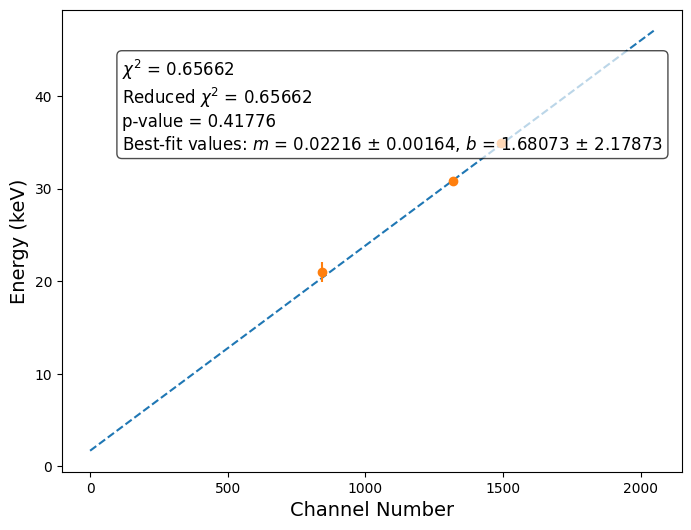

In [ ]:
fit_func = linear
ba5_calib_data_np = np.array([[key,*value] for key,value in ba5_calib.items()])
channel_nums = ba5_calib_data_np[:,1]
energies = ba5_calib_data_np[:,0]
energy_errs = ba5_calib_data_np[:,2]

popt, pcov = curve_fit(fit_func,channel_nums,energies,[0,0],sigma=ba5_calib_data_np[:,2], absolute_sigma=True)

chi2_value = np.sum(((fit_func(channel_nums, *popt) - energies) / energy_errs) ** 2)
dof = len(energies) - len(popt)
reduced_chi2 = chi2_value / dof
chi2_prob = chi2.cdf(chi2_value, dof)
p_val = 1 - chi2_prob

overplot_x = np.linspace(0, 2048, num=200)
overplot_y = linear(overplot_x, *popt)

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(overplot_x, overplot_y, linestyle='--')
ax.errorbar(channel_nums,energies, yerr = ba5_calib_data_np[:,2],fmt = 'o')
ax.set_xlabel("Channel Number", fontsize=14)
ax.set_ylabel("Energy (keV)", fontsize=14)
fig.text(
    0.2, 0.8,  # position relative to the figure, not just the axis
    generate_text_string(fit_func,popt,pcov,chi2_value,reduced_chi2,p_val,precision = 5),
    ha='left', va='top',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
)

ba5_calib_val = popt
ba5_calib_val_err = [pcov[0][0]**0.5, pcov[1][1]**0.5, pcov[0][1]]

<BarContainer object of 2048 artists>

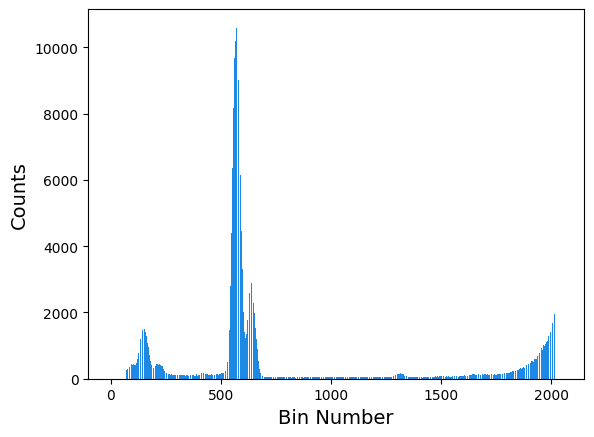

In [ ]:
rb2 = "10_10\\rubidium_x_ray_spectra_10_10.Spe"
data = np.genfromtxt(rb2, delimiter='\n', skip_header=12)
plt.xlabel("Bin Number", fontsize=14)
plt.ylabel("Counts", fontsize=14)
plt.bar(range(2048),data[:2048], color = '#1E88E5')

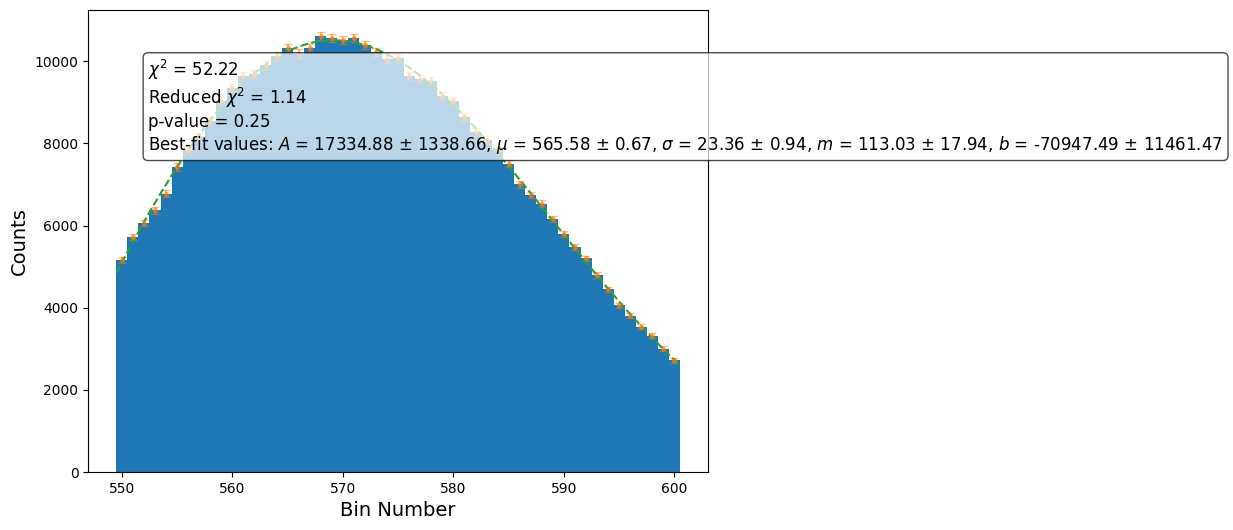

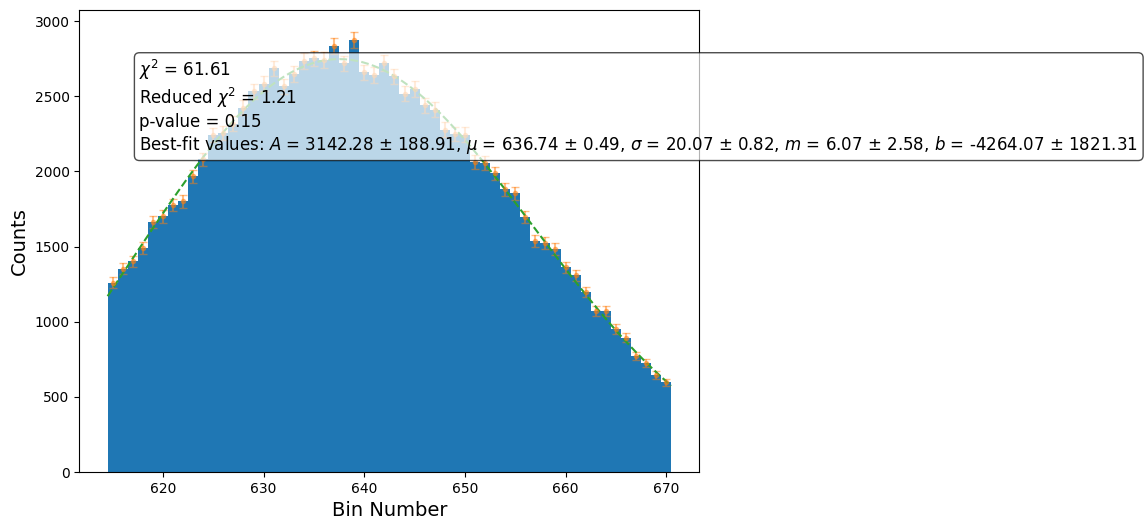

In [ ]:
range_beg = 550
range_end = 600
data_for_hist = []
for bin_num,counts in enumerate(data):
    if bin_num >= range_beg and bin_num <= range_end:
        try:
            for _ in range(int(counts)):
                data_for_hist.append(bin_num)
        except:
            break
fig, ax = plt.subplots(figsize=(8,6))

bins = np.arange(range_beg - 0.5, range_end + 1.5, 1)
hist_counts,bin_edges = ax.hist(data_for_hist,bins=bins)[:2] 

bin_centers = ((bin_edges[:-1] + bin_edges[1:]) / 2)
hist_uncertainties = [x**(0.5) for x in hist_counts]
# inputting 1 instead of 0 for histogram bins with 0 counts to fix divide by 0 error.
had_to_fix_div_by_zero = False
for i in range(len(hist_uncertainties)):
    if hist_uncertainties[i] == 0:
        hist_uncertainties[i] = 1
        had_to_fix_div_by_zero = True
ax.errorbar(bin_centers, hist_counts, yerr=hist_uncertainties, fmt = '.', capsize = 3, alpha = 0.5)

initial_guess = [hist_counts.max(),mode(data_for_hist)[0],10, 0,0]
fit_func = gaussian_plus_linear

popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,initial_guess,sigma=hist_uncertainties, absolute_sigma=True)
if had_to_fix_div_by_zero:
    popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,popt,sigma=[popt[1]**0.5]*len(hist_counts), absolute_sigma=True)
chi2_value = 0
for index,bin_center in enumerate(bin_centers):
    chi2_value += (fit_func(bin_center, *popt) - hist_counts[index])**2/hist_uncertainties[index]**2
dof = len(hist_counts) - len(popt)
reduced_chi2 = chi2_value/dof
chi2_prob = chi2.cdf(chi2_value, dof)
p_val = 1 - chi2_prob

overplot_x = np.linspace(range_beg-0.5, range_end+0.5, num=200)
overplot_y = fit_func(overplot_x, *popt)

ax.plot(overplot_x, overplot_y, linestyle='--')
fig.text(
    0.2, 0.8,  # position relative to the figure, not just the axis
    generate_text_string(fit_func,popt,pcov,chi2_value,reduced_chi2,p_val),
    ha='left', va='top',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
)
ax.set_xlabel("Bin Number", fontsize=14)
ax.set_ylabel("Counts", fontsize=14)

moseleys_lines[("Rb","KL3")] = (get_ener_at_bin(popt[1],*ba5_calib_val), calc_ener_err(ba5_calib_val, ba5_calib_val_err, pcov,popt,1))

#--------------------------------------------------------------------------------------------------------------------

range_beg = 615
range_end = 670
data_for_hist = []
for bin_num,counts in enumerate(data):
    if bin_num >= range_beg and bin_num <= range_end:
        try:
            for _ in range(int(counts)):
                data_for_hist.append(bin_num)
        except:
            break
fig, ax = plt.subplots(figsize=(8,6))

bins = np.arange(range_beg - 0.5, range_end + 1.5, 1)
hist_counts,bin_edges = ax.hist(data_for_hist,bins=bins)[:2] 

bin_centers = ((bin_edges[:-1] + bin_edges[1:]) / 2)
hist_uncertainties = [x**(0.5) for x in hist_counts]
# inputting 1 instead of 0 for histogram bins with 0 counts to fix divide by 0 error.
had_to_fix_div_by_zero = False
for i in range(len(hist_uncertainties)):
    if hist_uncertainties[i] == 0:
        hist_uncertainties[i] = 1
        had_to_fix_div_by_zero = True
ax.errorbar(bin_centers, hist_counts, yerr=hist_uncertainties, fmt = '.', capsize = 3, alpha = 0.5)

initial_guess = [hist_counts.max(),mode(data_for_hist)[0],10, 0,0]
fit_func = gaussian_plus_linear

popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,initial_guess,sigma=hist_uncertainties, absolute_sigma=True)
if had_to_fix_div_by_zero:
    popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,popt,sigma=[popt[1]**0.5]*len(hist_counts), absolute_sigma=True)
chi2_value = 0
for index,bin_center in enumerate(bin_centers):
    chi2_value += (fit_func(bin_center, *popt) - hist_counts[index])**2/hist_uncertainties[index]**2
dof = len(hist_counts) - len(popt)
reduced_chi2 = chi2_value/dof
chi2_prob = chi2.cdf(chi2_value, dof)
p_val = 1 - chi2_prob

overplot_x = np.linspace(range_beg-0.5, range_end+0.5, num=200)
overplot_y = fit_func(overplot_x, *popt)

ax.plot(overplot_x, overplot_y, linestyle='--')
fig.text(
    0.2, 0.8,  # position relative to the figure, not just the axis
    generate_text_string(fit_func,popt,pcov,chi2_value,reduced_chi2,p_val),
    ha='left', va='top',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
)
ax.set_xlabel("Bin Number", fontsize=14)
ax.set_ylabel("Counts", fontsize=14)

moseleys_lines[("Rb","KM3")] = (get_ener_at_bin(popt[1],*ba5_calib_val), calc_ener_err(ba5_calib_val, ba5_calib_val_err, pcov,popt,1))

<BarContainer object of 2048 artists>

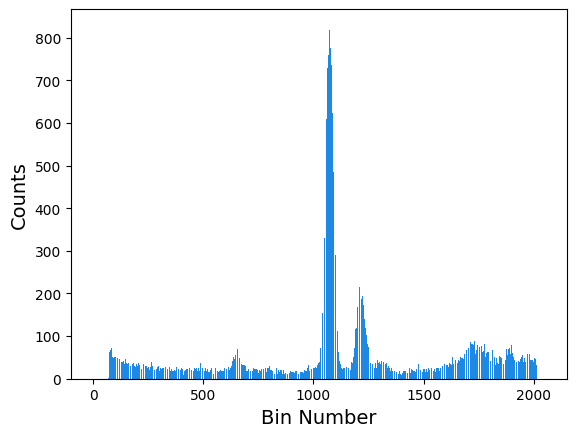

In [ ]:
sn= "10_10\\sn_x_ray_fluoresence_spectra_10_10.Spe"
data = np.genfromtxt(sn, delimiter='\n', skip_header=12)
plt.xlabel("Bin Number", fontsize=14)
plt.ylabel("Counts", fontsize=14)
plt.bar(range(2048),data[:2048], color = '#1E88E5')

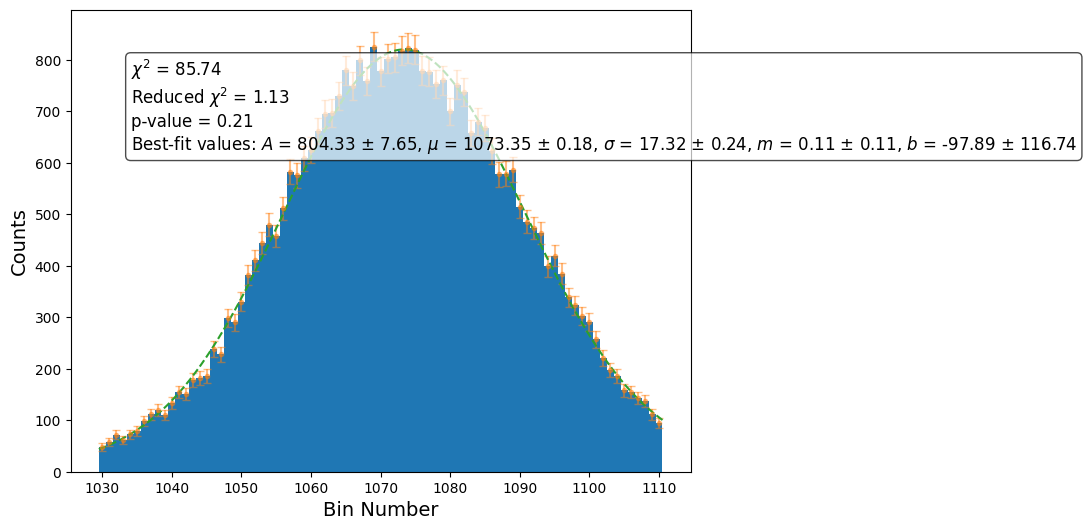

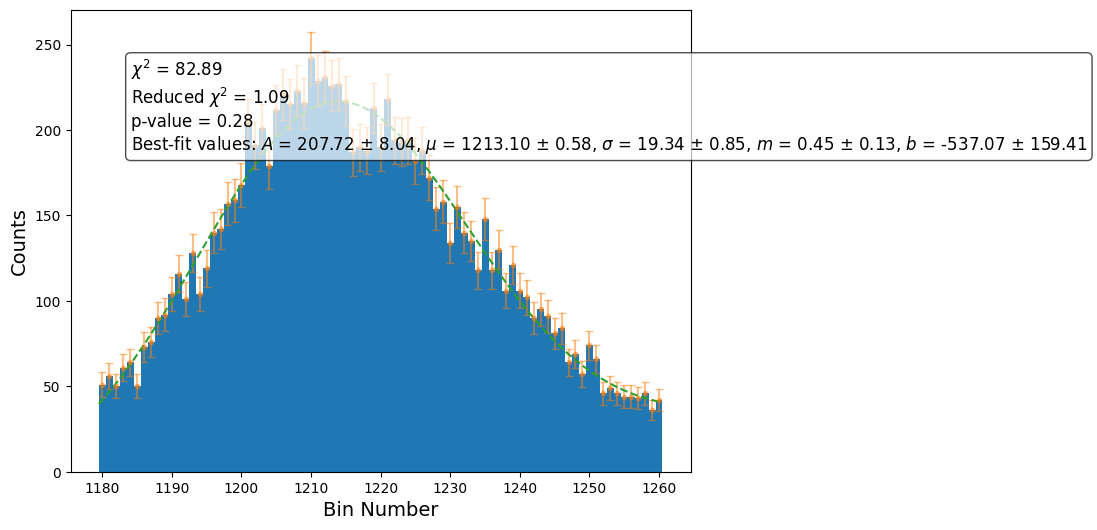

In [ ]:
range_beg = 1030
range_end = 1110
data_for_hist = []
for bin_num,counts in enumerate(data):
    if bin_num >= range_beg and bin_num <= range_end:
        try:
            for _ in range(int(counts)):
                data_for_hist.append(bin_num)
        except:
            break
fig, ax = plt.subplots(figsize=(8,6))

bins = np.arange(range_beg - 0.5, range_end + 1.5, 1)
hist_counts,bin_edges = ax.hist(data_for_hist,bins=bins)[:2] 

bin_centers = ((bin_edges[:-1] + bin_edges[1:]) / 2)
hist_uncertainties = [x**(0.5) for x in hist_counts]
# inputting 1 instead of 0 for histogram bins with 0 counts to fix divide by 0 error.
had_to_fix_div_by_zero = False
for i in range(len(hist_uncertainties)):
    if hist_uncertainties[i] == 0:
        hist_uncertainties[i] = 1
        had_to_fix_div_by_zero = True
ax.errorbar(bin_centers, hist_counts, yerr=hist_uncertainties, fmt = '.', capsize = 3, alpha = 0.5)

initial_guess = [hist_counts.max(),mode(data_for_hist)[0],10, 0,0]
fit_func = gaussian_plus_linear

popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,initial_guess,sigma=hist_uncertainties, absolute_sigma=True)
if had_to_fix_div_by_zero:
    popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,popt,sigma=[popt[1]**0.5]*len(hist_counts), absolute_sigma=True)
chi2_value = 0
for index,bin_center in enumerate(bin_centers):
    chi2_value += (fit_func(bin_center, *popt) - hist_counts[index])**2/hist_uncertainties[index]**2
dof = len(hist_counts) - len(popt)
reduced_chi2 = chi2_value/dof
chi2_prob = chi2.cdf(chi2_value, dof)
p_val = 1 - chi2_prob

overplot_x = np.linspace(range_beg-0.5, range_end+0.5, num=200)
overplot_y = fit_func(overplot_x, *popt)

ax.plot(overplot_x, overplot_y, linestyle='--')
fig.text(
    0.2, 0.8,  # position relative to the figure, not just the axis
    generate_text_string(fit_func,popt,pcov,chi2_value,reduced_chi2,p_val),
    ha='left', va='top',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
)
ax.set_xlabel("Bin Number", fontsize=14)
ax.set_ylabel("Counts", fontsize=14)

moseleys_lines[("Sn","KL3")] = (get_ener_at_bin(popt[1],*ba5_calib_val), calc_ener_err(ba5_calib_val, ba5_calib_val_err, pcov,popt,1))

#--------------------------------------------------------------------------------------------------------------------

range_beg = 1180
range_end = 1260
data_for_hist = []
for bin_num,counts in enumerate(data):
    if bin_num >= range_beg and bin_num <= range_end:
        try:
            for _ in range(int(counts)):
                data_for_hist.append(bin_num)
        except:
            break
fig, ax = plt.subplots(figsize=(8,6))

bins = np.arange(range_beg - 0.5, range_end + 1.5, 1)
hist_counts,bin_edges = ax.hist(data_for_hist,bins=bins)[:2] 

bin_centers = ((bin_edges[:-1] + bin_edges[1:]) / 2)
hist_uncertainties = [x**(0.5) for x in hist_counts]
# inputting 1 instead of 0 for histogram bins with 0 counts to fix divide by 0 error.
had_to_fix_div_by_zero = False
for i in range(len(hist_uncertainties)):
    if hist_uncertainties[i] == 0:
        hist_uncertainties[i] = 1
        had_to_fix_div_by_zero = True
ax.errorbar(bin_centers, hist_counts, yerr=hist_uncertainties, fmt = '.', capsize = 3, alpha = 0.5)

initial_guess = [hist_counts.max(),mode(data_for_hist)[0],10, 0,0]
fit_func = gaussian_plus_linear

popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,initial_guess,sigma=hist_uncertainties, absolute_sigma=True)
if had_to_fix_div_by_zero:
    popt, pcov = curve_fit(fit_func,bin_centers,hist_counts,popt,sigma=[popt[1]**0.5]*len(hist_counts), absolute_sigma=True)
chi2_value = 0
for index,bin_center in enumerate(bin_centers):
    chi2_value += (fit_func(bin_center, *popt) - hist_counts[index])**2/hist_uncertainties[index]**2
dof = len(hist_counts) - len(popt)
reduced_chi2 = chi2_value/dof
chi2_prob = chi2.cdf(chi2_value, dof)
p_val = 1 - chi2_prob

overplot_x = np.linspace(range_beg-0.5, range_end+0.5, num=200)
overplot_y = fit_func(overplot_x, *popt)

ax.plot(overplot_x, overplot_y, linestyle='--')
fig.text(
    0.2, 0.8,  # position relative to the figure, not just the axis
    generate_text_string(fit_func,popt,pcov,chi2_value,reduced_chi2,p_val),
    ha='left', va='top',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
)
ax.set_xlabel("Bin Number", fontsize=14)
ax.set_ylabel("Counts", fontsize=14)

moseleys_lines[("Sn","KM3")] = (get_ener_at_bin(popt[1],*ba5_calib_val), calc_ener_err(ba5_calib_val, ba5_calib_val_err, pcov,popt,1))

## Moseley's Complete

In [ ]:
# Fits for Moseley's
def quartic(x,A,B,sigma):
    return A*(x-sigma)**2 + B*(x-sigma)**4

def quadratic(x,C,sigma):
    return C*(x-sigma)**2

def bohr_sommerfeld(x,A,B,sigma):
    return A*(np.sqrt(1 - B**2*(x - sigma)**2/4) - np.sqrt(1 - B**2*(x-sigma)**2))

In [ ]:
Z_dict = {
    "Bi": 83,
    "Pb": 82,
    "Tb": 65,
    "Ba": 56,
    "Sn": 50,
    "Ag": 47,
    "Mo": 42,
    "Rb": 37,
    "Ge": 32,
    "Cu": 29
}

In [ ]:
# del moseleys_lines[("Rb","KL3")]
# del moseleys_lines[("Sn","KL3")]

In [ ]:
# Parse the two blocks and compute the ratio of statistical/total uncertainty for each line

import re

# Copy the two blocks as raw strings
block = """
# Just statistical uncertainties
# 29 & Cu & KL3 & 8.061 & 0.076 \\
# 32 & Ge & KL3 & 9.831 & 0.159 \\
# 37 & Rb & KL3 & 14.216 & 0.015 \\
# 37 & Rb & KM3 & 15.794 & 0.011 \\
# 42 & Mo & KL3 & 17.259 & 0.001 \\
# 42 & Mo & KM3 & 19.433 & 0.002 \\
# 47 & Ag & KL3 & 22.044 & 0.003 \\
# 47 & Ag & KM3 & 24.867 & 0.017 \\
# 50 & Sn & KL3 & 25.471 & 0.004 \\
# 50 & Sn & KM3 & 28.568 & 0.013 \\
# 56 & Ba & KL3 & 32.049 & 0.003 \\
# 56 & Ba & KM3 & 36.238 & 0.008 \\
# 56 & Ba & KN & 36.770 & 0.081 \\
# 65 & Tb & KL3 & 44.391 & 0.006 \\
# 65 & Tb & KL2 & 43.611 & 0.011 \\
# 65 & Tb & KM3 & 50.322 & 0.006 \\
# 65 & Tb & KN & 51.883 & 0.054 \\
# 82 & Pb & KL2 & 72.636 & 0.007 \\
# 82 & Pb & KL3 & 74.793 & 0.008 \\
# 83 & Bi & KL3 & 77.008 & 0.022 \\

# All uncertainties
# 29 & Cu & KL3 & 8.061 & 0.961 \\
# 32 & Ge & KL3 & 9.831 & 0.243 \\
# 37 & Rb & KL3 & 14.216 & 2.368 \\
# 37 & Rb & KM3 & 15.794 & 2.417 \\
# 42 & Mo & KL3 & 17.259 & 0.065 \\
# 42 & Mo & KM3 & 19.433 & 0.066 \\
# 47 & Ag & KL3 & 22.044 & 0.112 \\
# 47 & Ag & KM3 & 24.867 & 0.115 \\
# 50 & Sn & KL3 & 25.471 & 2.802 \\
# 50 & Sn & KM3 & 28.568 & 2.952 \\
# 56 & Ba & KL3 & 32.049 & 0.121 \\
# 56 & Ba & KM3 & 36.238 & 0.126 \\
# 56 & Ba & KN & 36.770 & 0.150 \\
# 65 & Tb & KL3 & 44.391 & 0.136 \\
# 65 & Tb & KL2 & 43.611 & 0.135 \\
# 65 & Tb & KM3 & 50.322 & 0.144 \\
# 65 & Tb & KN & 51.883 & 0.156 \\
# 82 & Pb & KL2 & 72.636 & 0.170 \\
# 82 & Pb & KL3 & 74.793 & 0.174 \\
# 83 & Bi & KL3 & 77.008 & 0.299 \\
"""

# Extract the two blocks
stat_lines = []
total_lines = []
in_stat = False
in_total = False
for line in block.splitlines():
    if "Just statistical uncertainties" in line:
        in_stat = True
        in_total = False
        continue
    if "All uncertainties" in line:
        in_stat = False
        in_total = True
        continue
    if in_stat and line.strip().startswith("#") and "&" in line:
        stat_lines.append(line)
    if in_total and line.strip().startswith("#") and "&" in line:
        total_lines.append(line)

# Parse the lines into tuples: (Z, element, line, energy, uncertainty)
def parse_lines(lines):
    parsed = []
    for l in lines:
        m = re.findall(r"(\d+) & (\w+) & (\w+) & ([\d.]+) & ([\d.]+)", l)
        if m:
            parsed.append(m[0])
    return parsed

stat_data = parse_lines(stat_lines)
total_data = parse_lines(total_lines)

# Compute the ratio for each line
ratios = []
for s, t in zip(stat_data, total_data):
    key_s = s[:4]
    key_t = t[:4]
    if key_s != key_t:
        print("Warning: mismatch", key_s, key_t)
    stat_unc = float(s[4])
    total_unc = float(t[4])
    ratio = stat_unc / total_unc if total_unc != 0 else float('nan')
    ratios.append((s[0], s[1], s[2], s[3], stat_unc, total_unc, ratio))

# Print results
print("Z  Element  Line   Energy   Stat_Unc  Total_Unc  Ratio")
list_of_ratios = []
for row in ratios:
    print(f"{row[0]:>2}  {row[1]:>2}   {row[2]:>4}  {row[3]:>7}  {row[4]:>8}  {row[5]:>9}  {row[6]:.3f}")
    list_of_ratios.append(row[6])

print(np.mean(list_of_ratios))
# If you want as a list of ratios only:
# ratios_only = [r[-1] for r in ratios]

Z  Element  Line   Energy   Stat_Unc  Total_Unc  Ratio
29  Cu    KL3    8.061     0.076      0.961  0.079
32  Ge    KL3    9.831     0.159      0.243  0.654
37  Rb    KL3   14.216     0.015      2.368  0.006
37  Rb    KM3   15.794     0.011      2.417  0.005
42  Mo    KL3   17.259     0.001      0.065  0.015
42  Mo    KM3   19.433     0.002      0.066  0.030
47  Ag    KL3   22.044     0.003      0.112  0.027
47  Ag    KM3   24.867     0.017      0.115  0.148
50  Sn    KL3   25.471     0.004      2.802  0.001
50  Sn    KM3   28.568     0.013      2.952  0.004
56  Ba    KL3   32.049     0.003      0.121  0.025
56  Ba    KM3   36.238     0.008      0.126  0.063
56  Ba     KN   36.770     0.081       0.15  0.540
65  Tb    KL3   44.391     0.006      0.136  0.044
65  Tb    KL2   43.611     0.011      0.135  0.081
65  Tb    KM3   50.322     0.006      0.144  0.042
65  Tb     KN   51.883     0.054      0.156  0.346
82  Pb    KL2   72.636     0.007       0.17  0.041
82  Pb    KL3   74.793     

In [ ]:
sorted_items = sorted(
    moseleys_lines.items(),
    key=lambda item: Z_dict[item[0][0]]
)

for key, value in sorted_items:
    if key[1] == 'KL3':
        print(f"{Z_dict[key[0]]} & {key[0]} & {value[0]:.3f} & {value[1]:.3f} \\\\")

29 & Cu & 8.061 & 0.961 \\
32 & Ge & 9.831 & 0.243 \\
37 & Rb & 14.216 & 2.368 \\
42 & Mo & 17.259 & 0.065 \\
47 & Ag & 22.044 & 0.112 \\
50 & Sn & 25.471 & 2.802 \\
56 & Ba & 32.049 & 0.121 \\
65 & Tb & 44.391 & 0.136 \\
82 & Pb & 74.793 & 0.174 \\
83 & Bi & 77.008 & 0.299 \\


In [ ]:
# KL3_energies = []
# KL3_energies_err =[]
# KL3_sqrt_energies = []
# KL3_sqrt_energies_err = []
# KL3_Zs = []
# for elt in moseleys_lines.keys():
#     if elt[1] == 'KL3':
#         KL3_energies.append(moseleys_lines[elt][0])
#         if moseleys_lines[elt][1] > 0.5:
#             print("Warning: Large uncertainty on energy for", elt)
#         KL3_energies_err.append(moseleys_lines[elt][1])
#         KL3_Zs.append(Z_dict[elt[0]])
#         sqrt_e = moseleys_lines[elt][0]**0.5
#         sqrt_e_err = 0.5 * moseleys_lines[elt][1] / sqrt_e
#         KL3_sqrt_energies.append(sqrt_e)
#         KL3_sqrt_energies_err.append(sqrt_e_err)

# fit_func = my_linear

# popt, pcov = curve_fit(fit_func,KL3_Zs,KL3_sqrt_energies,[0,0],sigma=KL3_sqrt_energies_err, absolute_sigma=True)

# chi2_value = 0
# for Z,sqrt_energy,energy_err in zip(KL3_Zs,KL3_sqrt_energies,KL3_sqrt_energies_err):
#     chi2_value += (fit_func(Z, *popt) - sqrt_energy)**2/energy_err**2
# dof = len(KL3_Zs) - len(popt)
# reduced_chi2 = chi2_value/dof
# chi2_prob = chi2.cdf(chi2_value, dof)
# p_val = 1 - chi2_prob
# overplot_x = np.linspace(0, 100, num=200)
# overplot_y = my_linear(overplot_x, *popt)

# # --- Residuals ---
# residuals = np.array(KL3_sqrt_energies) - fit_func(np.array(KL3_Zs), *popt)
# pulls = residuals / np.array(KL3_sqrt_energies_err)

# # --- Plot with residuals ---
# fig, (ax, ax_res) = plt.subplots(2, 1, figsize=(8, 7), sharex=True, 
#                                  gridspec_kw={'height_ratios': [3, 1]})

# # -- Generate text ---
# param_names = list(inspect.signature(fit_func).parameters.keys())[1:]

# # Build text dynamically
# precision = 5
# param_text_parts = []
# for i, name in enumerate(param_names):
#     value = popt[i]
#     uncertainty = pcov[i, i]**0.5 if pcov[i, i] >= 0 else float('nan')
#     fmt = f"{{:.{precision}f}}"  # dynamic precision format
#     param_text_parts.append(f"{latexify(name)} = {fmt.format(value)} ± {fmt.format(uncertainty)}")

# param_text = ",\n ".join(param_text_parts)

# # Construct full annotation text
# fmt = f"{{:.{precision}f}}"
# text_display_string_info = (
#     f"$\\chi^2$ = {fmt.format(chi2_value)}\n"
#     f"Reduced $\\chi^2$ = {fmt.format(reduced_chi2)}\n"
#     f"p-value = {fmt.format(p_val)}\n"
#     f"Best-fit values: {param_text}"
# )

# # Main fit plot
# ax.set_title(r"Characteristic $K$-$L_3$ X-Ray Energies", fontsize = 16)
# ax.errorbar(KL3_Zs, [e**0.5 for e in KL3_energies], yerr=KL3_sqrt_energies_err, fmt='o', capsize=3)
# ax.plot(overplot_x, overplot_y, linestyle='--')
# ax.set_ylabel("Square Root of Energy (sqrt(keV))", fontsize=14)
# fig.text(
#     0.14, 0.91,  # position relative to the figure, not just the axis
#     text_display_string_info,
#     ha='left', va='top',
#     fontsize=14,
#     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
# )

# # Residuals plot
# ax_res.errorbar(KL3_Zs, residuals, yerr=KL3_sqrt_energies_err, fmt='o', capsize=3)
# ax_res.axhline(0, color='k', linestyle='--', linewidth=1)
# ax_res.set_xlabel("Atomic Number Z", fontsize=14)
# ax_res.set_ylabel("Residuals", fontsize=14)
# ax_res.set_ylim(-0.5, 0.5)

# plt.tight_layout()

# # plt.savefig("moseleys_law_KL3_linear_with_residuals.pdf")
# # plt.show()

In [ ]:
# KL3_energies = []
# KL3_energies_err =[]
# KL3_sqrt_energies = []
# KL3_sqrt_energies_err = []
# KL3_Zs = []
# for elt in moseleys_lines.keys():
#     if elt[1] == 'KL3':
#         KL3_energies.append(moseleys_lines[elt][0])
#         if moseleys_lines[elt][1] > 0.5:
#             print("Warning: Large uncertainty on energy for", elt)
#         KL3_energies_err.append(moseleys_lines[elt][1])
#         KL3_Zs.append(Z_dict[elt[0]])
#         sqrt_e = moseleys_lines[elt][0]**0.5
#         sqrt_e_err = 0.5 * moseleys_lines[elt][1] / sqrt_e
#         KL3_sqrt_energies.append(sqrt_e)
#         KL3_sqrt_energies_err.append(sqrt_e_err)

# fit_func = linear

# popt, pcov = curve_fit(fit_func,KL3_Zs,KL3_sqrt_energies,[0,0],sigma=KL3_sqrt_energies_err, absolute_sigma=True)

# chi2_value = 0
# for Z,sqrt_energy,energy_err in zip(KL3_Zs,KL3_sqrt_energies,KL3_sqrt_energies_err):
#     chi2_value += (fit_func(Z, *popt) - sqrt_energy)**2/energy_err**2
# dof = len(KL3_Zs) - len(popt)
# reduced_chi2 = chi2_value/dof
# chi2_prob = chi2.cdf(chi2_value, dof)
# p_val = 1 - chi2_prob
# overplot_x = np.linspace(0, 100, num=200)
# overplot_y = linear(overplot_x, *popt)

# # --- Residuals ---
# residuals = np.array(KL3_sqrt_energies) - fit_func(np.array(KL3_Zs), *popt)
# pulls = residuals / np.array(KL3_sqrt_energies_err)

# # --- Plot with residuals ---
# fig, ax = plt.subplots(figsize=(6, 6))

# # -- Generate text ---
# param_names = list(inspect.signature(fit_func).parameters.keys())[1:]

# # Build text dynamically
# precision = 5
# param_text_parts = []
# for i, name in enumerate(param_names):
#     value = popt[i]
#     uncertainty = pcov[i, i]**0.5 if pcov[i, i] >= 0 else float('nan')
#     fmt = f"{{:.{precision}f}}"  # dynamic precision format
#     param_text_parts.append(f"{latexify(name)} = {fmt.format(value)} ± {fmt.format(uncertainty)}")

# param_text = ",\n ".join(param_text_parts)

# # Construct full annotation text
# fmt = f"{{:.{precision}f}}"
# text_display_string_info = (
#     f"$\\chi^2$ = {fmt.format(chi2_value)}\n"
#     f"Reduced $\\chi^2$ = {fmt.format(reduced_chi2)}\n"
#     f"p-value = {fmt.format(p_val)}\n"
#     f"Best-fit values: \n {param_text}"
# )

# # Main fit plot
# ax.set_title(r"Characteristic $K$-$L_3$ X-Ray Energies", fontsize = 16)
# ax.errorbar(KL3_Zs, [e**0.5 for e in KL3_energies], yerr=KL3_sqrt_energies_err, fmt='o', capsize=3)
# ax.plot(overplot_x, overplot_y, linestyle='--')
# ax.set_ylabel("Square Root of Energy (sqrt(keV))", fontsize=14)
# ax.set_xlabel("Atomic Number Z", fontsize=14)
# fig.text(
#     0.15, 0.90,  # position relative to the figure, not just the axis
#     text_display_string_info,
#     ha='left', va='top',
#     fontsize=14,
#     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
# )

# # # Residuals plot
# # ax_res.errorbar(KL3_Zs, residuals, yerr=KL3_sqrt_energies_err, fmt='o', capsize=3)
# # ax_res.axhline(0, color='k', linestyle='--', linewidth=1)
# # ax_res.set_xlabel("Atomic Number Z", fontsize=14)
# # ax_res.set_ylabel("Residuals", fontsize=14)
# # ax_res.set_ylim(-0.5, 0.5)

# plt.tight_layout()

# plt.savefig("moseleys_law_KL3_linear.png",bbox_inches='tight')
# # plt.show()

In [ ]:
# KL3_energies = []
# KL3_energies_err =[]
# KL3_sqrt_energies = []
# KL3_sqrt_energies_err = []
# KL3_Zs = []
# for elt in moseleys_lines.keys():
#     if elt[1] == 'KL3':
#         KL3_energies.append(moseleys_lines[elt][0])
#         if moseleys_lines[elt][1] > 0.5:
#             print("Warning: Large uncertainty on energy for", elt)
#         KL3_energies_err.append(moseleys_lines[elt][1])
#         KL3_Zs.append(Z_dict[elt[0]])
#         sqrt_e = moseleys_lines[elt][0]**0.5
#         sqrt_e_err = 0.5 * moseleys_lines[elt][1] / sqrt_e
#         KL3_sqrt_energies.append(sqrt_e)
#         KL3_sqrt_energies_err.append(sqrt_e_err)

# fit_func = linear

# popt, pcov = curve_fit(fit_func,KL3_Zs,KL3_sqrt_energies,[0,0],sigma=KL3_sqrt_energies_err, absolute_sigma=True)

# chi2_value = 0
# for Z,sqrt_energy,energy_err in zip(KL3_Zs,KL3_sqrt_energies,KL3_sqrt_energies_err):
#     chi2_value += (fit_func(Z, *popt) - sqrt_energy)**2/energy_err**2
# dof = len(KL3_Zs) - len(popt)
# reduced_chi2 = chi2_value/dof
# chi2_prob = chi2.cdf(chi2_value, dof)
# p_val = 1 - chi2_prob
# overplot_x = np.linspace(0, 100, num=200)
# overplot_y = linear(overplot_x, *popt)

# # --- Residuals ---
# residuals = np.array(KL3_sqrt_energies) - fit_func(np.array(KL3_Zs), *popt)
# pulls = residuals / np.array(KL3_sqrt_energies_err)

# # --- Plot with residuals ---
# fig, ax_res = plt.subplots(figsize=(6, 6))

# # -- Generate text ---
# param_names = list(inspect.signature(fit_func).parameters.keys())[1:]

# # Build text dynamically
# precision = 5
# param_text_parts = []
# for i, name in enumerate(param_names):
#     value = popt[i]
#     uncertainty = pcov[i, i]**0.5 if pcov[i, i] >= 0 else float('nan')
#     fmt = f"{{:.{precision}f}}"  # dynamic precision format
#     param_text_parts.append(f"{latexify(name)} = {fmt.format(value)} ± {fmt.format(uncertainty)}")

# param_text = ",\n ".join(param_text_parts)

# # Construct full annotation text
# fmt = f"{{:.{precision}f}}"
# text_display_string_info = (
#     f"$\\chi^2$ = {fmt.format(chi2_value)}\n"
#     f"Reduced $\\chi^2$ = {fmt.format(reduced_chi2)}\n"
#     f"p-value = {fmt.format(p_val)}\n"
#     f"Best-fit values: \n {param_text}"
# )

# # # Main fit plot
# # ax.set_title(r"Characteristic $K$-$L_3$ X-Ray Energies", fontsize = 16)
# # ax.errorbar(KL3_Zs, [e**0.5 for e in KL3_energies], yerr=KL3_sqrt_energies_err, fmt='o', capsize=3)
# # ax.plot(overplot_x, overplot_y, linestyle='--')
# # ax.set_ylabel("Square Root of Energy (sqrt(keV))", fontsize=14)
# # fig.text(
# #     0.15, 0.90,  # position relative to the figure, not just the axis
# #     text_display_string_info,
# #     ha='left', va='top',
# #     fontsize=14,
# #     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
# # )

# # Residuals plot
# ax_res.set_title(r"Residuals of Linear Fit to Characteristic $K$-$L_3$ X-Ray Energies", fontsize = 16)
# ax_res.errorbar(KL3_Zs, residuals, yerr=KL3_sqrt_energies_err, fmt='o', capsize=3)
# ax_res.axhline(0, color='k', linestyle='--', linewidth=1)
# ax_res.set_xlabel("Atomic Number Z", fontsize=14)
# ax_res.set_ylabel("Residuals", fontsize=14)
# ax_res.set_ylim(-0.6, 0.6)

# plt.tight_layout()

# plt.savefig("moseleys_law_KL3_linear_residuals.pdf",bbox_inches='tight')
# # plt.show()

In [ ]:
print(1000*(popt[0])**2/(h*R)) # should be 0.75 and I dont understand why it isnt.
print(np.sqrt(pcov[0][0]  * (2 * popt[0] * 1000/(h*R))**2)) # with error propagation formula

C_KL3 = popt[0]
sigma_KL3 = -popt[1]/popt[0]
print(sigma_KL3) # should be ~1
print(np.sqrt(pcov[1][1]/popt[0]**2 + pcov[0][0]*(popt[1]/popt[0]**2)**2))

# E*1000 = C(Z-sigma)^2*1000 = h*nu = 13.6 ev (3/4) (Z-1)**2
# Try this with real values from like Z = 15 to 30

3171428.1602255316
245393.30595989406
-5.839965545291555
0.22595469568902998


In [ ]:
def generate_text_string(fit_func, popt, pcov, chi2_value, reduced_chi2, p_val, precision=2):
    param_names = list(inspect.signature(fit_func).parameters.keys())[1:]

    # Build text dynamically
    param_text_parts = []
    for i, name in enumerate(param_names):
        value = popt[i]
        uncertainty = pcov[i, i]**0.5 if pcov[i, i] >= 0 else float('nan')
        fmt = f"{{:.{precision}f}}"  # dynamic precision format
        param_text_parts.append(f"{latexify(name)} = {fmt.format(value)} ± {fmt.format(uncertainty)}")

    param_text = ", ".join(param_text_parts)

    # Construct full annotation text
    fmt = f"{{:.{precision}f}}"
    text_display_string_info = (
        f"$\\chi^2$ = {fmt.format(chi2_value)}\n"
        f"p-value = {fmt.format(p_val)}\n"
        f"Best-fit values: {param_text}"
    )

    return text_display_string_info

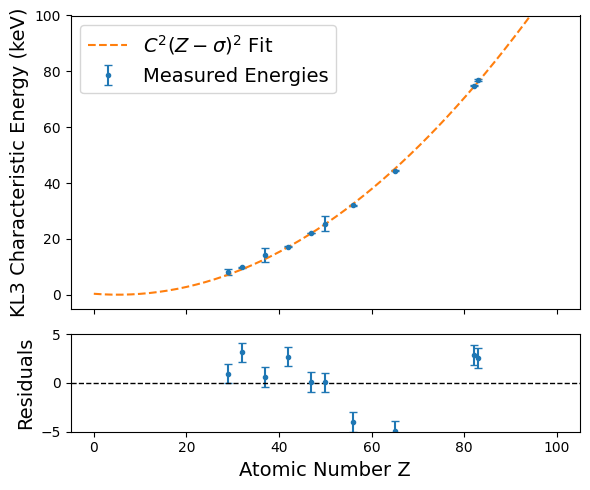

In [ ]:
# Same fit as linear fit just quadratic, squared both sides
KL3_energies = []
KL3_energies_err =[]
KL3_sqrt_energies = []
KL3_sqrt_energies_err = []
KL3_Zs = []
for elt in moseleys_lines.keys():
    if elt[1] == 'KL3':
        KL3_energies.append(moseleys_lines[elt][0])
        if moseleys_lines[elt][1] > 0.5:
            print("Warning: Large uncertainty on energy for", elt)
        KL3_energies_err.append(moseleys_lines[elt][1])
        KL3_Zs.append(Z_dict[elt[0]])
        sqrt_e = moseleys_lines[elt][0]**0.5
        sqrt_e_err = 0.5 * moseleys_lines[elt][1] / sqrt_e
        KL3_sqrt_energies.append(sqrt_e)
        KL3_sqrt_energies_err.append(sqrt_e_err)

fit_func = quadratic

popt, pcov = curve_fit(fit_func,KL3_Zs,KL3_energies,[0,0],sigma=KL3_energies_err, absolute_sigma=True)

chi2_value = 0
for Z,energy,energy_err in zip(KL3_Zs,KL3_energies,KL3_energies_err):
    chi2_value += (fit_func(Z, *popt) - energy)**2/energy_err**2
dof = len(KL3_Zs) - len(popt)
reduced_chi2 = chi2_value/dof
chi2_prob = chi2.cdf(chi2_value, dof)
p_val = 1 - chi2_prob
overplot_x = np.linspace(0, 100, num=200)
overplot_y = fit_func(overplot_x, *popt)

# --- Residuals ---
residuals = np.array(KL3_energies) - fit_func(np.array(KL3_Zs), *popt)
pulls = residuals / np.array(KL3_energies_err)

# --- Plot with residuals ---
fig, (ax, ax_res) = plt.subplots(2, 1, figsize=(6, 5), sharex=True, 
                                 gridspec_kw={'height_ratios': [3, 1]})
# Main fit plot
ax.errorbar(KL3_Zs, KL3_energies, yerr=KL3_energies_err, fmt='o', markersize = 3, capsize=3, label = 'Measured Energies')
ax.plot(overplot_x, overplot_y, linestyle='--', label = r'$C^2 (Z-\sigma)^2$ Fit')
ax.set_ylabel("KL3 Characteristic Energy (keV)", fontsize=14)
ax.set_ylim(-5,100)

# fig.text(
#     0.14, 0.93,  # position relative to the figure, not just the axis
#     generate_text_string(fit_func, popt, pcov, chi2_value, reduced_chi2, p_val, precision=3),
#     ha='left', va='top',
#     fontsize=12,
#     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
# )
ax.legend(fontsize = 14)

# Residuals plot
ax_res.errorbar(KL3_Zs, pulls, yerr=1, fmt='o', markersize = 3, capsize=3)
ax_res.axhline(0, color='k', linestyle='--', linewidth=1)
ax_res.set_xlabel("Atomic Number Z", fontsize=14)
ax_res.set_ylabel("Residuals", fontsize=14)
ax_res.set_ylim(-5, 5)

plt.tight_layout()
plt.savefig("1moseley_naive.pdf",bbox_inches='tight')
plt.show()

In [ ]:
print(1000*(popt[0])/(h*R)) # should be 0.75 and I dont understand why it isnt.
print(np.sqrt(pcov[0][0])*1000/(h*R))

C_KL3 = popt[0]
sigma_KL3 = -popt[1]/popt[0]
print(sigma_KL3) # should be ~1
print(np.sqrt(pcov[1][1]/popt[0]**2 + pcov[0][0]*(popt[1]/popt[0]**2)**2))

# E*1000 = C(Z-sigma)^2*1000 = h*nu = 13.6 ev (3/4) (Z-1)**2
# Try this with real values from like Z = 15 to 30

0.9246311302139495
0.004445388382037518
-409.2477982318462
10.770255669642891


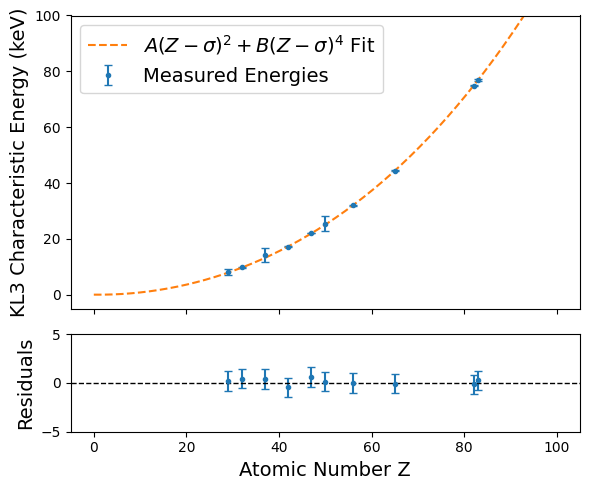

In [ ]:
# Fitting a polynomial of the form A*(x-sigma)**2 + B*(x-sigma)**4 which is theoretically more correct.
KL3_energies = []
KL3_energies_err =[]
KL3_sqrt_energies = []
KL3_sqrt_energies_err = []
KL3_Zs = []
for elt in moseleys_lines.keys():
    if elt[1] == 'KL3':
        KL3_energies.append(moseleys_lines[elt][0])
        if moseleys_lines[elt][1] > 0.5:
            print("Warning: Large uncertainty on energy for", elt)
        KL3_energies_err.append(moseleys_lines[elt][1])
        KL3_Zs.append(Z_dict[elt[0]])
        sqrt_e = moseleys_lines[elt][0]**0.5
        sqrt_e_err = 0.5 * moseleys_lines[elt][1] / sqrt_e
        KL3_sqrt_energies.append(sqrt_e)
        KL3_sqrt_energies_err.append(sqrt_e_err)

fit_func = quartic
popt, pcov = curve_fit(fit_func,KL3_Zs,KL3_energies,[5,5,5],sigma=KL3_energies_err, absolute_sigma=True)

chi2_value = 0
for Z,energy,energy_err in zip(KL3_Zs,KL3_energies,KL3_energies_err):
    chi2_value += (fit_func(Z, *popt) - energy)**2/energy_err**2
dof = len(KL3_Zs) - len(popt)
reduced_chi2 = chi2_value/dof
chi2_prob = chi2.cdf(chi2_value, dof)
p_val = 1 - chi2_prob
overplot_x = np.linspace(0, 100, num=200)
overplot_y = fit_func(overplot_x, *popt)

# --- Residuals ---
residuals = np.array(KL3_energies) - fit_func(np.array(KL3_Zs), *popt)
pulls = residuals / np.array(KL3_energies_err)

# --- Plot with residuals ---
fig, (ax, ax_res) = plt.subplots(2, 1, figsize=(6, 5), sharex=True, 
                                 gridspec_kw={'height_ratios': [3, 1]})

# Main fit plot
ax.errorbar(KL3_Zs, KL3_energies, yerr=KL3_energies_err, fmt='o', markersize = 3, capsize=3, label = 'Measured Energies')
ax.plot(overplot_x, overplot_y, linestyle='--', label = r'$A (Z-\sigma)^2 + B (Z-\sigma)^4$ Fit')
ax.set_ylabel("KL3 Characteristic Energy (keV)", fontsize=14)
# ax.set_yscale('log')
ax.set_ylim(-5,100)
# ax.set_xscale('log')
# fig.text(
#     0.14, 0.93,  # position relative to the figure, not just the axis
#     generate_text_string(fit_func, popt, pcov, chi2_value, reduced_chi2, p_val, precision=3),
#     ha='left', va='top',
#     fontsize=12,
#     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
# )
ax.legend(fontsize = 14)

# Residuals plot
ax_res.errorbar(KL3_Zs, pulls, yerr=1, fmt='o', markersize = 3, capsize=3)
ax_res.axhline(0, color='k', linestyle='--', linewidth=1)
ax_res.set_xlabel("Atomic Number Z", fontsize=14)
ax_res.set_ylabel("Residuals", fontsize=14)
ax_res.set_ylim(-5, 5)

plt.tight_layout()
plt.savefig("1moseley_corrected.pdf",bbox_inches='tight')

In [ ]:
print(1000*(popt[0])/(h*R), 1000*(pcov[0][0]**0.5)/(h*R)) # should be 0.75
print(1000*(popt[1])/(h*R*alpha**2), 1000*(pcov[1][1]**0.5)/(h*R*alpha**2)) # should be 15/64
print(popt[2], pcov[2][2]**0.5)

0.7284478113649392 0.0245279703229521
0.3151349664371733 0.031995802743602746
1.019096343948715 0.6057062378901148


In [ ]:
# # Fitting a polynomial of the form A*(x-sigma)**2 + B*(x-sigma)**4 which is theoretically more correct.
# KL3_energies = []
# KL3_energies_err =[]
# KL3_sqrt_energies = []
# KL3_sqrt_energies_err = []
# KL3_Zs = []
# for elt in moseleys_lines.keys():
#     if elt[1] == 'KL3':
#         KL3_energies.append(moseleys_lines[elt][0])
#         if moseleys_lines[elt][1] > 0.5:
#             print("Warning: Large uncertainty on energy for", elt)
#         KL3_energies_err.append(moseleys_lines[elt][1])
#         KL3_Zs.append(Z_dict[elt[0]])
#         sqrt_e = moseleys_lines[elt][0]**0.5
#         sqrt_e_err = 0.5 * moseleys_lines[elt][1] / sqrt_e
#         KL3_sqrt_energies.append(sqrt_e)
#         KL3_sqrt_energies_err.append(sqrt_e_err)

# fit_func = quartic
# popt, pcov = curve_fit(fit_func,KL3_Zs,KL3_energies,[5,5,5],sigma=KL3_energies_err, absolute_sigma=True)

# chi2_value = 0
# for Z,energy,energy_err in zip(KL3_Zs,KL3_energies,KL3_energies_err):
#     chi2_value += (fit_func(Z, *popt) - energy)**2/energy_err**2
# dof = len(KL3_Zs) - len(popt)
# reduced_chi2 = chi2_value/dof
# chi2_prob = chi2.cdf(chi2_value, dof)
# p_val = 1 - chi2_prob
# overplot_x = np.linspace(0, 100, num=200)
# overplot_y = fit_func(overplot_x, *popt)

# # --- Residuals ---
# residuals = np.array(KL3_energies) - fit_func(np.array(KL3_Zs), *popt)
# pulls = residuals / np.array(KL3_energies)

# # -- Generate text ---
# param_names = list(inspect.signature(fit_func).parameters.keys())[1:]

# # Build text dynamically
# precision = 5
# param_text_parts = []
# for i, name in enumerate(param_names):
#     value = popt[i]
#     uncertainty = pcov[i, i]**0.5 if pcov[i, i] >= 0 else float('nan')
#     fmt = f"{{:.{precision}f}}"  # dynamic precision format
#     param_text_parts.append(f"{latexify(name)} = {fmt.format(value)} ± {fmt.format(uncertainty)}")

# param_text = ",\n ".join(param_text_parts)

# # Construct full annotation text
# fmt = f"{{:.{precision}f}}"
# text_display_string_info = (
#     f"$\\chi^2$ = {fmt.format(chi2_value)}\n"
#     f"Reduced $\\chi^2$ = {fmt.format(reduced_chi2)}\n"
#     f"p-value = {fmt.format(p_val)}\n"
#     f"Best-fit values: \n {param_text}"
# )

# # --- Plot with residuals ---
# fig, ax = plt.subplots(figsize=(6, 6))

# ax.set_title(r"Characteristic $K$-$L_3$ X-Ray Energies", fontsize = 16)
# ax.errorbar(KL3_Zs,KL3_energies,yerr=KL3_energies_err, fmt = '.', capsize = 3)
# ax.plot(overplot_x, overplot_y, linestyle='--')
# ax.set_xlabel("Atomic Number Z", fontsize=14)
# ax.set_ylabel("KL3 Characteristic Energy (KeV)", fontsize=14)
# fig.text(
#     0.15, 0.85,  # position relative to the figure, not just the axis
#     text_display_string_info,
#     ha='left', va='top',
#     fontsize=12,
#     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
# )

# # Residuals plot
# # ax_res.errorbar(KL3_Zs, residuals, yerr=KL3_energies_err, fmt='o', capsize=3)
# # ax_res.axhline(0, color='k', linestyle='--', linewidth=1)
# # ax_res.set_xlabel("Z", fontsize=14)
# # ax_res.set_ylabel("Residuals", fontsize=12)
# # ax_res.set_ylim(-4, 4)

# plt.savefig("moseleys_law_KL3_quadratic.png",bbox_inches='tight')

In [ ]:
# # Fitting a polynomial of the form A*(x-sigma)**2 + B*(x-sigma)**4 which is theoretically more correct.
# KL3_energies = []
# KL3_energies_err =[]
# KL3_sqrt_energies = []
# KL3_sqrt_energies_err = []
# KL3_Zs = []
# for elt in moseleys_lines.keys():
#     if elt[1] == 'KL3':
#         KL3_energies.append(moseleys_lines[elt][0])
#         if moseleys_lines[elt][1] > 0.5:
#             print("Warning: Large uncertainty on energy for", elt)
#         KL3_energies_err.append(moseleys_lines[elt][1])
#         KL3_Zs.append(Z_dict[elt[0]])
#         sqrt_e = moseleys_lines[elt][0]**0.5
#         sqrt_e_err = 0.5 * moseleys_lines[elt][1] / sqrt_e
#         KL3_sqrt_energies.append(sqrt_e)
#         KL3_sqrt_energies_err.append(sqrt_e_err)

# fit_func = quartic
# popt, pcov = curve_fit(fit_func,KL3_Zs,KL3_energies,[5,5,5],sigma=KL3_energies_err, absolute_sigma=True)

# chi2_value = 0
# for Z,energy,energy_err in zip(KL3_Zs,KL3_energies,KL3_energies_err):
#     chi2_value += (fit_func(Z, *popt) - energy)**2/energy_err**2
# dof = len(KL3_Zs) - len(popt)
# reduced_chi2 = chi2_value/dof
# chi2_prob = chi2.cdf(chi2_value, dof)
# p_val = 1 - chi2_prob
# overplot_x = np.linspace(0, 100, num=200)
# overplot_y = fit_func(overplot_x, *popt)

# # --- Residuals ---
# residuals = np.array(KL3_energies) - fit_func(np.array(KL3_Zs), *popt)
# pulls = residuals / np.array(KL3_energies)

# # -- Generate text ---
# param_names = list(inspect.signature(fit_func).parameters.keys())[1:]

# # Build text dynamically
# precision = 5
# param_text_parts = []
# for i, name in enumerate(param_names):
#     value = popt[i]
#     uncertainty = pcov[i, i]**0.5 if pcov[i, i] >= 0 else float('nan')
#     fmt = f"{{:.{precision}f}}"  # dynamic precision format
#     param_text_parts.append(f"{latexify(name)} = {fmt.format(value)} ± {fmt.format(uncertainty)}")

# param_text = ",\n ".join(param_text_parts)

# # Construct full annotation text
# fmt = f"{{:.{precision}f}}"
# text_display_string_info = (
#     f"$\\chi^2$ = {fmt.format(chi2_value)}\n"
#     f"Reduced $\\chi^2$ = {fmt.format(reduced_chi2)}\n"
#     f"p-value = {fmt.format(p_val)}\n"
#     f"Best-fit values: \n {param_text}"
# )

# # --- Plot with residuals ---
# fig, ax_res = plt.subplots(figsize=(6, 6))

# # ax.set_title(r"Characteristic $K$-$L_3$ X-Ray Energies", fontsize = 16)
# # ax.errorbar(KL3_Zs,KL3_energies,yerr=KL3_energies_err, fmt = '.', capsize = 3)
# # ax.plot(overplot_x, overplot_y, linestyle='--')
# # ax.set_xlabel("Z", fontsize=14)
# # ax.set_ylabel("KL3 Characteristic Energy (KeV)", fontsize=14)
# # fig.text(
# #     0.15, 0.85,  # position relative to the figure, not just the axis
# #     text_display_string_info,
# #     ha='left', va='top',
# #     fontsize=12,
# #     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
# # )


# ax_res.set_title(r"Residuals of Quartic Fit to Characteristic $K$-$L_3$ X-Ray Energies", fontsize = 16)
# ax_res.errorbar(KL3_Zs, residuals, yerr=KL3_energies_err, fmt='o', capsize=3)
# ax_res.axhline(0, color='k', linestyle='--', linewidth=1)
# ax_res.set_xlabel("Atomic Number Z", fontsize=14)
# ax_res.set_ylabel("Residuals", fontsize=12)
# ax_res.set_ylim(-4, 4)

# plt.savefig("moseleys_law_KL3_quadratic_residuals.png",bbox_inches='tight')

In [ ]:
# # Fitting a polynomial of the form A*(x-sigma)**2 + B*(x-sigma)**4 which is theoretically more correct.
# KL3_energies = []
# KL3_energies_err =[]
# KL3_sqrt_energies = []
# KL3_sqrt_energies_err = []
# KL3_Zs = []
# for elt in moseleys_lines.keys():
#     if elt[1] == 'KL3':
#         KL3_energies.append(moseleys_lines[elt][0])
#         if moseleys_lines[elt][1] > 0.5:
#             print("Warning: Large uncertainty on energy for", elt)
#         KL3_energies_err.append(moseleys_lines[elt][1])
#         KL3_Zs.append(Z_dict[elt[0]])
#         sqrt_e = moseleys_lines[elt][0]**0.5
#         sqrt_e_err = 0.5 * moseleys_lines[elt][1] / sqrt_e
#         KL3_sqrt_energies.append(sqrt_e)
#         KL3_sqrt_energies_err.append(sqrt_e_err)

# fit_func = bohr_sommerfeld
# popt, pcov = curve_fit(fit_func,KL3_Zs,KL3_energies,[511,(1/137)**2,1],sigma=KL3_energies_err, absolute_sigma=True, maxfev = 80000)

# chi2_value = 0
# for Z,energy,energy_err in zip(KL3_Zs,KL3_energies,KL3_energies_err):
#     chi2_value += (fit_func(Z, *popt) - energy)**2/energy_err**2
# dof = len(KL3_Zs) - len(popt)
# reduced_chi2 = chi2_value/dof
# chi2_prob = chi2.cdf(chi2_value, dof)
# p_val = 1 - chi2_prob
# overplot_x = np.linspace(0, 100, num=200)
# overplot_y = fit_func(overplot_x, *popt)

# # --- Residuals ---
# residuals = np.array(KL3_energies) - fit_func(np.array(KL3_Zs), *popt)
# pulls = residuals / np.array(KL3_energies)

# # -- Generate text ---
# param_names = list(inspect.signature(fit_func).parameters.keys())[1:]

# # Build text dynamically
# precision = 5
# param_text_parts = []
# for i, name in enumerate(param_names):
#     value = popt[i]
#     uncertainty = pcov[i, i]**0.5 if pcov[i, i] >= 0 else float('nan')
#     fmt = f"{{:.{precision}f}}"  # dynamic precision format
#     param_text_parts.append(f"{latexify(name)} = {fmt.format(value)} ± {fmt.format(uncertainty)}")

# param_text = ",\n ".join(param_text_parts)

# # Construct full annotation text
# fmt = f"{{:.{precision}f}}"
# text_display_string_info = (
#     f"$\\chi^2$ = {fmt.format(chi2_value)}\n"
#     f"Reduced $\\chi^2$ = {fmt.format(reduced_chi2)}\n"
#     f"p-value = {fmt.format(p_val)}\n"
#     f"Best-fit values: \n {param_text}"
# )

# # --- Plot with residuals ---
# fig, (ax, ax_res) = plt.subplots(2, 1, figsize=(8, 8), sharex=True, 
#                                  gridspec_kw={'height_ratios': [3, 1]})

# ax.errorbar(KL3_Zs,KL3_energies,yerr=KL3_energies_err, fmt = '.', capsize = 3)
# ax.plot(overplot_x, overplot_y, linestyle='--')
# ax.set_xlabel("Z", fontsize=14)
# ax.set_ylabel("KL3 Characteristic Energy (KeV)", fontsize=14)
# fig.text(
#     0.15, 0.85,  # position relative to the figure, not just the axis
#     text_display_string_info,
#     ha='left', va='top',
#     fontsize=12,
#     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
# )

# # Residuals plot
# ax_res.errorbar(KL3_Zs, residuals, yerr=KL3_energies_err, fmt='o', capsize=3)
# ax_res.axhline(0, color='k', linestyle='--', linewidth=1)
# ax_res.set_xlabel("Z", fontsize=14)
# ax_res.set_ylabel("Residuals", fontsize=12)
# ax_res.set_ylim(-4, 4)

# # plt.savefig("moseleys_law_KL3_quadratic_with_residuals.png")

In [ ]:
# KL2_energies = []
# KL2_energies_err = []
# KL2_Zs = []
# for elt in moseleys_lines.keys():
#     if elt[1] == 'KL2':
#         KL2_energies.append(moseleys_lines[elt][0])
#         if moseleys_lines[elt][1] > 0.5:
#             print("Warning: Large uncertainty on energy for", elt)
#         KL2_energies_err.append(moseleys_lines[elt][1])
#         KL2_Zs.append(Z_dict[elt[0]])

# fit_func = linear

# popt, pcov = curve_fit(fit_func,KL2_Zs,[e**0.5 for e in KL2_energies],[0,0],sigma=KL2_energies_err, absolute_sigma=True)

# overplot_x = np.linspace(0, 100, num=200)
# overplot_y = linear(overplot_x, *popt)

# fig, ax = plt.subplots(figsize=(8,6))

# ax.errorbar(KL2_Zs,[e**0.5 for e in KL2_energies],yerr=KL2_energies_err, fmt = '.', capsize = 3)
# ax.plot(overplot_x, overplot_y, linestyle='--')
# ax.set_xlabel("Z", fontsize=14)
# ax.set_ylabel("Sqrt(KL2 Characteristic Energy) (KeV**0.5)", fontsize=14)
# fig.text(
#     0.2, 0.8,  # position relative to the figure, not just the axis
#     generate_text_string(fit_func, popt, pcov, chi2_value, reduced_chi2, p_val, precision=5),
#     ha='left', va='top',
#     fontsize=12,
#     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
# )


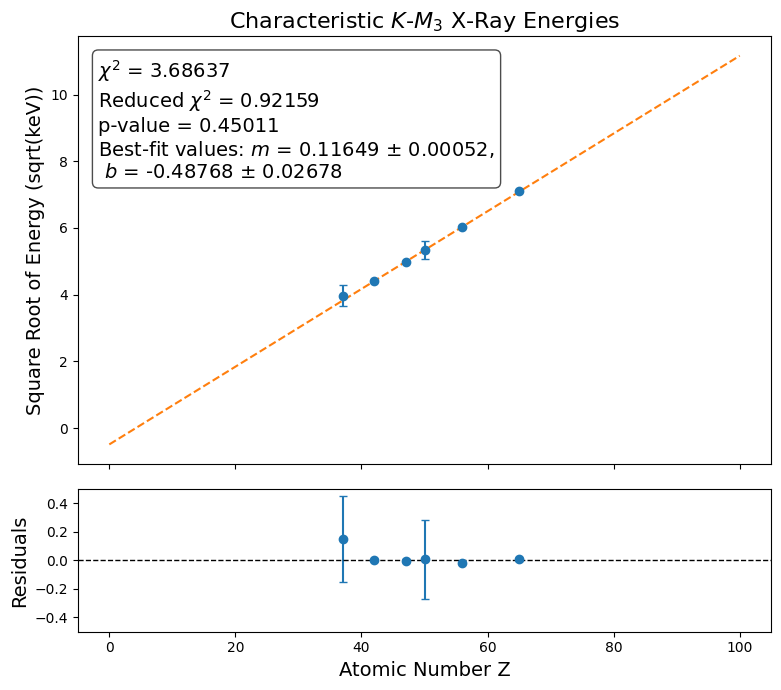

In [ ]:
KM3_energies = []
KM3_energies_err =[]
KM3_sqrt_energies = []
KM3_sqrt_energies_err = []
KM3_Zs = []
for elt in moseleys_lines.keys():
    if elt[1] == 'KM3':
        KM3_energies.append(moseleys_lines[elt][0])
        if moseleys_lines[elt][1] > 0.5:
            print("Warning: Large uncertainty on energy for", elt)
        KM3_energies_err.append(moseleys_lines[elt][1])
        KM3_Zs.append(Z_dict[elt[0]])
        sqrt_e = moseleys_lines[elt][0]**0.5
        sqrt_e_err = 0.5 * moseleys_lines[elt][1] / sqrt_e
        KM3_sqrt_energies.append(sqrt_e)
        KM3_sqrt_energies_err.append(sqrt_e_err)

fit_func = linear

popt, pcov = curve_fit(fit_func,KM3_Zs,KM3_sqrt_energies,[0,0],sigma=KM3_sqrt_energies_err, absolute_sigma=True)

chi2_value = 0
for Z,sqrt_energy,energy_err in zip(KM3_Zs,KM3_sqrt_energies,KM3_sqrt_energies_err):
    chi2_value += (fit_func(Z, *popt) - sqrt_energy)**2/energy_err**2
dof = len(KM3_Zs) - len(popt)
reduced_chi2 = chi2_value/dof
chi2_prob = chi2.cdf(chi2_value, dof)
p_val = 1 - chi2_prob
overplot_x = np.linspace(0, 100, num=200)
overplot_y = linear(overplot_x, *popt)

# --- Residuals ---
residuals = np.array(KM3_sqrt_energies) - fit_func(np.array(KM3_Zs), *popt)
pulls = residuals / np.array(KM3_sqrt_energies_err)

# --- Plot with residuals ---
fig, (ax, ax_res) = plt.subplots(2, 1, figsize=(8, 7), sharex=True, 
                                 gridspec_kw={'height_ratios': [3, 1]})

# -- Generate text ---
param_names = list(inspect.signature(fit_func).parameters.keys())[1:]

# Build text dynamically
precision = 5
param_text_parts = []
for i, name in enumerate(param_names):
    value = popt[i]
    uncertainty = pcov[i, i]**0.5 if pcov[i, i] >= 0 else float('nan')
    fmt = f"{{:.{precision}f}}"  # dynamic precision format
    param_text_parts.append(f"{latexify(name)} = {fmt.format(value)} ± {fmt.format(uncertainty)}")

param_text = ",\n ".join(param_text_parts)

# Construct full annotation text
fmt = f"{{:.{precision}f}}"
text_display_string_info = (
    f"$\\chi^2$ = {fmt.format(chi2_value)}\n"
    f"Reduced $\\chi^2$ = {fmt.format(reduced_chi2)}\n"
    f"p-value = {fmt.format(p_val)}\n"
    f"Best-fit values: {param_text}"
)

# Main fit plot
ax.set_title(r"Characteristic $K$-$M_3$ X-Ray Energies", fontsize = 16)
ax.errorbar(KM3_Zs, [e**0.5 for e in KM3_energies], yerr=KM3_sqrt_energies_err, fmt='o', capsize=3)
ax.plot(overplot_x, overplot_y, linestyle='--')
ax.set_ylabel("Square Root of Energy (sqrt(keV))", fontsize=14)
fig.text(
    0.14, 0.91,  # position relative to the figure, not just the axis
    text_display_string_info,
    ha='left', va='top',
    fontsize=14,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
)

# Residuals plot
ax_res.errorbar(KM3_Zs, residuals, yerr=KM3_sqrt_energies_err, fmt='o', capsize=3)
ax_res.axhline(0, color='k', linestyle='--', linewidth=1)
ax_res.set_xlabel("Atomic Number Z", fontsize=14)
ax_res.set_ylabel("Residuals", fontsize=14)
ax_res.set_ylim(-0.5, 0.5)

plt.tight_layout()

plt.savefig("moseleys_law_KM3_linear_with_residuals.png")
# plt.show()

In [ ]:
print((1000*(popt[0])**2/h)/R) # should be 1 - 1/9 ?
C_KM3 = popt[0]
sigma_KM3 = -popt[1]
print(sigma_KM3)

0.9974200221655477
0.48768382316682024


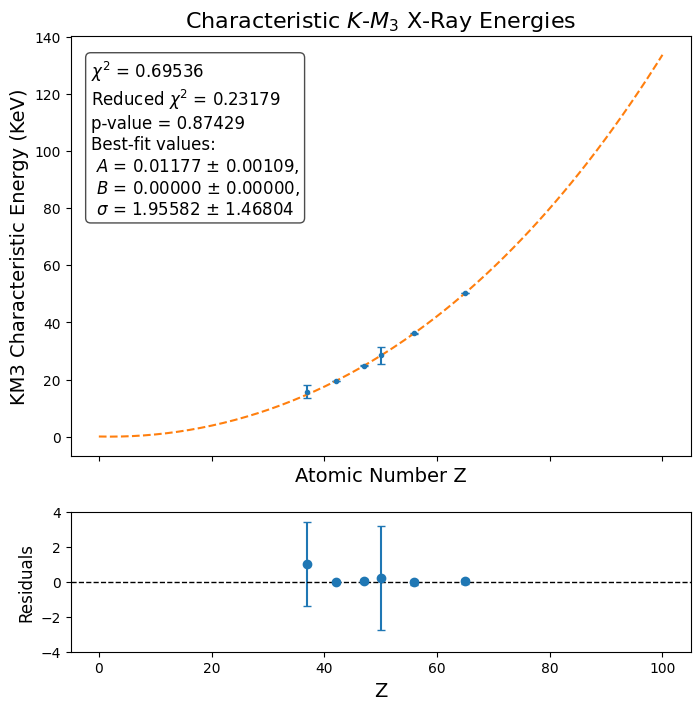

In [ ]:
# Fitting a polynomial of the form A*(x-sigma)**2 + B*(x-sigma)**4 which is theoretically more correct.
KM3_energies = []
KM3_energies_err =[]
KM3_sqrt_energies = []
KM3_sqrt_energies_err = []
KM3_Zs = []
for elt in moseleys_lines.keys():
    if elt[1] == 'KM3':
        KM3_energies.append(moseleys_lines[elt][0])
        if moseleys_lines[elt][1] > 0.5:
            print("Warning: Large uncertainty on energy for", elt)
        KM3_energies_err.append(moseleys_lines[elt][1])
        KM3_Zs.append(Z_dict[elt[0]])
        sqrt_e = moseleys_lines[elt][0]**0.5
        sqrt_e_err = 0.5 * moseleys_lines[elt][1] / sqrt_e
        KM3_sqrt_energies.append(sqrt_e)
        KM3_sqrt_energies_err.append(sqrt_e_err)

fit_func = polynomial
popt, pcov = curve_fit(fit_func,KM3_Zs,KM3_energies,[5,5,5],sigma=KM3_energies_err, absolute_sigma=True)

chi2_value = 0
for Z,energy,energy_err in zip(KM3_Zs,KM3_energies,KM3_energies_err):
    chi2_value += (fit_func(Z, *popt) - energy)**2/energy_err**2
dof = len(KM3_Zs) - len(popt)
reduced_chi2 = chi2_value/dof
chi2_prob = chi2.cdf(chi2_value, dof)
p_val = 1 - chi2_prob
overplot_x = np.linspace(0, 100, num=200)
overplot_y = fit_func(overplot_x, *popt)

# --- Residuals ---
residuals = np.array(KM3_energies) - fit_func(np.array(KM3_Zs), *popt)
pulls = residuals / np.array(KM3_energies)

# -- Generate text ---
param_names = list(inspect.signature(fit_func).parameters.keys())[1:]

# Build text dynamically
precision = 5
param_text_parts = []
for i, name in enumerate(param_names):
    value = popt[i]
    uncertainty = pcov[i, i]**0.5 if pcov[i, i] >= 0 else float('nan')
    fmt = f"{{:.{precision}f}}"  # dynamic precision format
    param_text_parts.append(f"{latexify(name)} = {fmt.format(value)} ± {fmt.format(uncertainty)}")

param_text = ",\n ".join(param_text_parts)

# Construct full annotation text
fmt = f"{{:.{precision}f}}"
text_display_string_info = (
    f"$\\chi^2$ = {fmt.format(chi2_value)}\n"
    f"Reduced $\\chi^2$ = {fmt.format(reduced_chi2)}\n"
    f"p-value = {fmt.format(p_val)}\n"
    f"Best-fit values: \n {param_text}"
)

# --- Plot with residuals ---
fig, (ax, ax_res) = plt.subplots(2, 1, figsize=(8, 8), sharex=True, 
                                 gridspec_kw={'height_ratios': [3, 1]})

ax.errorbar(KM3_Zs,KM3_energies,yerr=KM3_energies_err, fmt = '.', capsize = 3)
ax.plot(overplot_x, overplot_y, linestyle='--')
ax.set_xlabel("Atomic Number Z", fontsize=14)
ax.set_ylabel("KM3 Characteristic Energy (KeV)", fontsize=14)
ax.set_title(r"Characteristic $K$-$M_3$ X-Ray Energies", fontsize = 16)

fig.text(
    0.15, 0.85,  # position relative to the figure, not just the axis
    text_display_string_info,
    ha='left', va='top',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
)

# Residuals plot
ax_res.errorbar(KM3_Zs, residuals, yerr=KM3_energies_err, fmt='o', capsize=3)
ax_res.axhline(0, color='k', linestyle='--', linewidth=1)
ax_res.set_xlabel("Z", fontsize=14)
ax_res.set_ylabel("Residuals", fontsize=12)
ax_res.set_ylim(-4, 4)
plt.savefig("moseleys_law_KM3_quadratic_with_residuals.png")

In [ ]:
print(1000*(popt[0])/(h*R), 1000*(pcov[0][0]**0.5)/(h*R)) # should be 0.75
print(1000*(popt[1])/(h*R*alpha**2), 1000*(pcov[1][1]**0.5)/(h*R*alpha**2)) # should be 11/64
print(popt[2])

0.8650404243908318 0.0797472213834197
0.3083536196560748 0.16449896853900148
1.9558196734003725


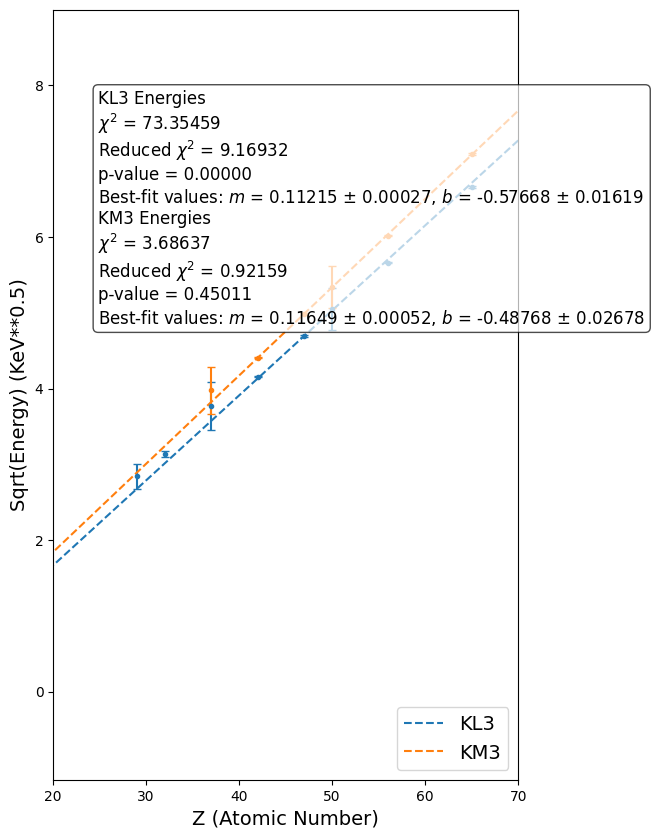

In [ ]:
KL3_energies = []
KL3_energies_err = []
KL3_sqrt_energies = []
KL3_sqrt_energies_err = []
KL3_Zs = []
for elt in moseleys_lines.keys():
    if elt[1] == 'KL3':
        KL3_energies.append(moseleys_lines[elt][0])
        if moseleys_lines[elt][1] > 0.5:
            print("Warning: Large uncertainty on energy for", elt)
        KL3_energies_err.append(moseleys_lines[elt][1])
        KL3_Zs.append(Z_dict[elt[0]])
        sqrt_e = moseleys_lines[elt][0]**0.5
        sqrt_e_err = 0.5 * moseleys_lines[elt][1] / sqrt_e
        KL3_sqrt_energies.append(sqrt_e)
        KL3_sqrt_energies_err.append(sqrt_e_err)


fit_func = linear

popt, pcov = curve_fit(fit_func,KL3_Zs,KL3_sqrt_energies,[0,0],sigma=KL3_sqrt_energies_err, absolute_sigma=True)

chi2_value = 0
for Z,sqrt_energy,energy_err in zip(KL3_Zs,KL3_sqrt_energies,KL3_sqrt_energies_err):
    chi2_value += (fit_func(Z, *popt) - sqrt_energy)**2/energy_err**2
dof = len(KL3_Zs) - len(popt)
reduced_chi2 = chi2_value/dof
chi2_prob = chi2.cdf(chi2_value, dof)
p_val = 1 - chi2_prob
overplot_x = np.linspace(0, 100, num=200)
overplot_y = linear(overplot_x, *popt)

fig, ax = plt.subplots(figsize=(6,10))
text_display_string_info = ""

ax.errorbar(KL3_Zs,[e**0.5 for e in KL3_energies],yerr=KL3_sqrt_energies_err, fmt = '.', capsize = 3, color = 'tab:blue')
ax.plot(overplot_x, overplot_y, linestyle='--', color = 'tab:blue', label = 'KL3')

text_display_string_info += "KL3 Energies\n" + generate_text_string(fit_func, popt, pcov, chi2_value, reduced_chi2, p_val, precision=5)

KM3_energies = []
KM3_energies_err = []
KM3_sqrt_energies = []
KM3_sqrt_energies_err = []
KM3_Zs = []
for elt in moseleys_lines.keys():
    if elt[1] == 'KM3':
        KM3_energies.append(moseleys_lines[elt][0])
        if moseleys_lines[elt][1] > 0.5:
            print("Warning: Large uncertainty on energy for", elt)
        KM3_energies_err.append(moseleys_lines[elt][1])
        KM3_Zs.append(Z_dict[elt[0]])
        sqrt_e = moseleys_lines[elt][0]**0.5
        sqrt_e_err = 0.5 * moseleys_lines[elt][1] / sqrt_e
        KM3_sqrt_energies.append(sqrt_e)
        KM3_sqrt_energies_err.append(sqrt_e_err)


fit_func = linear

popt, pcov = curve_fit(fit_func,KM3_Zs,KM3_sqrt_energies,[0,0],sigma=KM3_sqrt_energies_err, absolute_sigma=True)

chi2_value = 0
for Z,sqrt_energy,energy_err in zip(KM3_Zs,KM3_sqrt_energies,KM3_sqrt_energies_err):
    chi2_value += (fit_func(Z, *popt) - sqrt_energy)**2/energy_err**2
dof = len(KM3_Zs) - len(popt)
reduced_chi2 = chi2_value/dof
chi2_prob = chi2.cdf(chi2_value, dof)
p_val = 1 - chi2_prob
overplot_x = np.linspace(0, 100, num=200)
overplot_y = linear(overplot_x, *popt)

ax.errorbar(KM3_Zs,[e**0.5 for e in KM3_energies],yerr=KM3_sqrt_energies_err, fmt = '.', capsize = 3, color = 'tab:orange')
ax.plot(overplot_x, overplot_y, linestyle='--',color = 'tab:orange', label = 'KM3')

ax.set_xlim(20, 70)
ax.set_ylim(top = 9)
ax.set_xlabel("Z (Atomic Number)", fontsize=14)
ax.set_ylabel("Sqrt(Energy) (KeV**0.5)", fontsize=14)
text_display_string_info += "\nKM3 Energies\n" + generate_text_string(fit_func, popt, pcov, chi2_value, reduced_chi2, p_val, precision=5)
fig.text(
    0.2, 0.8,  # position relative to the figure, not just the axis
    text_display_string_info,
    ha='left', va='top',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
)
plt.legend(loc = "lower right",prop = {'size': 14})

In [ ]:
KM3_energies, KM3_Zs, KL3_energies, KL3_Zs

([np.float64(50.32178885074003),
  np.float64(36.23777799155302),
  np.float64(24.867144071512605),
  np.float64(19.43345832359438),
  np.float64(15.79364823572036),
  np.float64(28.568305335902984)],
 [65, 56, 47, 42, 37, 50],
 [np.float64(74.79260430908418),
  np.float64(77.00811140268783),
  np.float64(44.39055139294454),
  np.float64(9.830858477764522),
  np.float64(32.04896541144594),
  np.float64(22.044249007283344),
  np.float64(8.061163984950479),
  np.float64(17.258793174164182),
  np.float64(14.216343692497889),
  np.float64(25.47065169975709)],
 [82, 83, 65, 32, 56, 47, 29, 42, 37, 50])

In [ ]:
n = 2
l = 1
alpha = 1/137
for z in KL3_Zs:
    print(z,h*R*alpha**2*(z-sigma_KL3)**4/(n**3 * l * (l+1))/1000, "in keV")
# this should be the energy difference between KL3 and KL2
# based on eqn 8.17 here https://archive.org/details/in.ernet.dli.2015.135707/page/605/mode/2up

82 2638.5299101957658 in keV
83 2660.0799098074776 in keV
65 2291.8218059599985 in keV
32 1717.4723716650997 in keV
56 2122.7402766233736 in keV
47 1963.1915709054738 in keV
29 1671.2388607695427 in keV
42 1878.537796739113 in keV
37 1796.651728139529 in keV
50 2015.3379617898001 in keV


In [ ]:
for z in KM3_Zs:
    print(z,(z-sigma_KM3)**4)

65 17320903.350012243
56 9496364.858959723
47 4680280.332299031
42 2969667.7451817407
37 1777286.8763740608
50 6009702.4799467055


## Misc (Moseley Comparison with NIST Data)

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.optimize import curve_fit
# from scipy.stats import chi2

# # --- Define the Moseley linear function ---
# def linear(Z, a, b):
#     return a * (Z - b)

# # --- Helper for formatting fit text on the plot ---
# def generate_text_string(fit_func, popt, pcov, chi2_value, reduced_chi2, p_val, precision=4):
#     perr = np.sqrt(np.diag(pcov))
#     txt = (
#         f"Fit function: {fit_func.__name__}\n"
#         f"a = {popt[0]:.{precision}f} ± {perr[0]:.{precision}f}\n"
#         f"b = {popt[1]:.{precision}f} ± {perr[1]:.{precision}f}\n"
#         f"χ² = {chi2_value:.3f}\n"
#         f"Reduced χ² = {reduced_chi2:.3f}\n"
#         f"p-value = {p_val:.3f}"
#     )
#     return txt


# # --- Real Kα (KL3) X-ray energies (in keV) for elements Z = 15–30 ---
# # Data from NIST X-ray Transition Energies
# data = {
#     15: ("P", 2.013),
#     16: ("S", 2.308),
#     17: ("Cl", 2.622),
#     18: ("Ar", 2.957),
#     19: ("K", 3.312),
#     20: ("Ca", 3.691),
#     21: ("Sc", 4.091),
#     22: ("Ti", 4.511),
#     23: ("V", 4.952),
#     24: ("Cr", 5.414),
#     25: ("Mn", 5.899),
#     26: ("Fe", 6.404),
#     27: ("Co", 6.930),
#     28: ("Ni", 7.478),
#     29: ("Cu", 8.048),
#     30: ("Zn", 8.638),
# }

# # Assume small (1%) uncertainty for each energy
# moseleys_lines_1 = {}
# Z_dict = {}
# for Z, (sym, E) in data.items():
#     moseleys_lines_1[(sym, "KL3")] = (E, 0.01 * E)
#     Z_dict[sym] = Z

# # --- Collect values ---
# KL3_energies = []
# KL3_energies_err = []
# KL3_sqrt_energies = []
# KL3_sqrt_energies_err = []
# KL3_Zs = []

# for elt in moseleys_lines_1.keys():
#     if elt[1] == 'KL3':
#         Z = Z_dict[elt[0]]
#         energy, energy_err = moseleys_lines_1[elt]
#         sqrt_e = np.sqrt(energy)
#         sqrt_e_err = 0.5 * energy_err / sqrt_e

#         KL3_Zs.append(Z)
#         KL3_energies.append(energy)
#         KL3_energies_err.append(energy_err)
#         KL3_sqrt_energies.append(sqrt_e)
#         KL3_sqrt_energies_err.append(sqrt_e_err)

# KL3_Zs = np.array(KL3_Zs)
# KL3_sqrt_energies = np.array(KL3_sqrt_energies)
# KL3_sqrt_energies_err = np.array(KL3_sqrt_energies_err)

# # --- Fit ---
# popt, pcov = curve_fit(
#     linear,
#     KL3_Zs,
#     KL3_sqrt_energies,
#     p0=[1, 0],
#     sigma=KL3_sqrt_energies_err,
#     absolute_sigma=True
# )

# # --- Chi-squared statistics ---
# chi2_value = np.sum(((linear(KL3_Zs, *popt) - KL3_sqrt_energies) / KL3_sqrt_energies_err) ** 2)
# dof = len(KL3_Zs) - len(popt)
# reduced_chi2 = chi2_value / dof
# p_val = 1 - chi2.cdf(chi2_value, dof)

# # --- Plot ---
# fig, ax = plt.subplots(figsize=(8,6))

# ax.errorbar(
#     KL3_Zs,
#     KL3_sqrt_energies,
#     yerr=KL3_sqrt_energies_err,
#     fmt='o',
#     color='black',
#     ecolor='gray',
#     capsize=3,
#     label='Data'
# )

# Z_fit = np.linspace(14, 31, 200)
# sqrtE_fit = linear(Z_fit, *popt)
# ax.plot(Z_fit, sqrtE_fit, 'r--', label='Best fit')

# ax.set_xlabel("Atomic Number Z", fontsize=14)
# ax.set_ylabel(r"$\sqrt{E_{K\alpha}}$ (keV$^{1/2}$)", fontsize=14)
# ax.legend()

# # Annotate fit statistics
# fit_text = generate_text_string(linear, popt, pcov, chi2_value, reduced_chi2, p_val)
# fig.text(
#     0.05, 0.95,
#     fit_text,
#     ha='left', va='top',
#     fontsize=12,
#     bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="black", alpha=0.7)
# )

# plt.tight_layout()
# plt.show()


In [ ]:
# print((1000*(popt[0])**2/h)/R) # should be 1 - 1/9 ?
# C_KM3 = popt[0]
# sigma = -popt[1]
# print(sigma)

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.optimize import curve_fit
# from scipy.stats import chi2

# # --- Define the linear function ---
# def linear(Z, a, b):
#     return a * (Z - b)

# # --- Helper for fit text annotation ---
# def generate_text_string(fit_func, popt, pcov, chi2_value, reduced_chi2, p_val, precision=4):
#     perr = np.sqrt(np.diag(pcov))
#     txt = (
#         f"Fit function: {fit_func.__name__}\n"
#         f"a = {popt[0]:.{precision}f} ± {perr[0]:.{precision}f}\n"
#         f"b = {popt[1]:.{precision}f} ± {perr[1]:.{precision}f}\n"
#         f"χ² = {chi2_value:.3f}\n"
#         f"Reduced χ² = {reduced_chi2:.3f}\n"
#         f"p-value = {p_val:.3f}"
#     )
#     return txt


# # --- Real Kα (KL3) X-ray energies (in keV) for elements Z = 35–50 ---
# # Data source: NIST X-ray Transition Energies (KL3)
# data = {
#     35: ("Br", 11.92),
#     36: ("Kr", 12.65),
#     37: ("Rb", 13.39),
#     38: ("Sr", 14.16),
#     39: ("Y", 14.96),
#     40: ("Zr", 15.77),
#     41: ("Nb", 16.61),
#     42: ("Mo", 17.48),
#     43: ("Tc", 18.38),
#     44: ("Ru", 19.28),
#     45: ("Rh", 20.22),
#     46: ("Pd", 21.18),
#     47: ("Ag", 22.16),
#     48: ("Cd", 23.17),
#     49: ("In", 24.21),
#     50: ("Sn", 25.27),
# }

# # --- Build Moseley data dicts with small uncertainties ---
# moseleys_lines_1 = {}
# Z_dict = {}
# for Z, (sym, E) in data.items():
#     moseleys_lines_1[(sym, "KL3")] = (E, 0.01 * E)
#     Z_dict[sym] = Z

# # --- Extract the data arrays ---
# KL3_energies = []
# KL3_energies_err = []
# KL3_sqrt_energies = []
# KL3_sqrt_energies_err = []
# KL3_Zs = []

# for elt in moseleys_lines_1.keys():
#     if elt[1] == 'KL3':
#         Z = Z_dict[elt[0]]
#         energy, energy_err = moseleys_lines_1[elt]
#         sqrt_e = np.sqrt(energy)
#         sqrt_e_err = 0.5 * energy_err / sqrt_e

#         KL3_Zs.append(Z)
#         KL3_energies.append(energy)
#         KL3_energies_err.append(energy_err)
#         KL3_sqrt_energies.append(sqrt_e)
#         KL3_sqrt_energies_err.append(sqrt_e_err)

# KL3_Zs = np.array(KL3_Zs)
# KL3_sqrt_energies = np.array(KL3_sqrt_energies)
# KL3_sqrt_energies_err = np.array(KL3_sqrt_energies_err)

# # --- Perform linear fit ---
# popt, pcov = curve_fit(
#     linear,
#     KL3_Zs,
#     KL3_sqrt_energies,
#     p0=[1, 0],
#     sigma=KL3_sqrt_energies_err,
#     absolute_sigma=True
# )

# # --- Compute chi-squared statistics ---
# chi2_value = np.sum(((linear(KL3_Zs, *popt) - KL3_sqrt_energies) / KL3_sqrt_energies_err) ** 2)
# dof = len(KL3_Zs) - len(popt)
# reduced_chi2 = chi2_value / dof
# p_val = 1 - chi2.cdf(chi2_value, dof)

# # --- Plot the data and best-fit line ---
# fig, ax = plt.subplots(figsize=(8,6))
# ax.errorbar(
#     KL3_Zs,
#     KL3_sqrt_energies,
#     yerr=KL3_sqrt_energies_err,
#     fmt='o',
#     color='black',
#     ecolor='gray',
#     capsize=3,
#     label='Data'
# )

# Z_fit = np.linspace(34, 51, 200)
# sqrtE_fit = linear(Z_fit, *popt)
# ax.plot(Z_fit, sqrtE_fit, 'r--', label='Best Fit')

# ax.set_xlabel("Atomic Number Z", fontsize=14)
# ax.set_ylabel(r"$\sqrt{E_{K\alpha}}$ (keV$^{1/2}$)", fontsize=14)
# ax.legend()

# # Annotate with fit info
# fit_text = generate_text_string(linear, popt, pcov, chi2_value, reduced_chi2, p_val)
# fig.text(
#     0.05, 0.95,
#     fit_text,
#     ha='left', va='top',
#     fontsize=12,
#     bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="black", alpha=0.7)
# )

# plt.tight_layout()
# plt.show()


In [ ]:
# print((1000*(popt[0])**2/h)/R) # should be 1 - 1/9 ?
# sigma = -popt[1]
# print(sigma)